# Modelling Optimization - Homarus Americanus

Purpose:
* Run Model with data Homarus Americanus only 

In [46]:
# data cleaning 
import pandas as pd
import datetime as dt
from datetime import datetime
import numpy as np

# visualizations
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
# modelling - prophet
from prophet import Prophet
from prophet.utilities import regressor_coefficients
from prophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

import itertools
# modelling - other
from sklearn.metrics import r2_score 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
# import statsmodels.API as sm
import warnings; 
warnings.simplefilter('ignore')
#surpress scientific notation
pd.options.display.float_format = '{:,.2f}'.format

In [47]:
# import model data log
data_log = pd.read_csv('data/model_data_log.csv')

# import model data in dollars (not log)
model_data_grouped = pd.read_csv('data/model_data_grouped.csv')
# model_data_grouped

In [48]:
# Function to get the variable name of a DataFrame
def get_variable_name(dataframe, namespace):
    ''' for documentation, when want to refer to the name of the dataframe, not the dataframe itself
    '''
    for name, obj in namespace.items():
        if obj is dataframe:
            return name
    return None

## Baseline Model 1: Prophet
this time using only US data, with Homarus Americanus commodities

In [12]:
homarus_comm = ["0306.12",
"0306.22",
"0306.32",
"0306.92",
"1605.30"]

In [95]:
# us data - not adjusted for inflation
us_data = pd.read_csv('data/data_clean.csv')
us_data = us_data[us_data['Country'].str.contains('United States')].reset_index(drop=True)
#filter for only HA commodities
us_data = us_data[['Period','Commodity', 'Value']]


In [96]:
us_data

,Period,Commodity,Value
0,2017-05-01,"1605.30.10 - lobster, prepared or preserved, f...",2454203
1,2018-06-01,"1605.30.10 - lobster, prepared or preserved, f...",2199419
2,2014-06-01,"1605.30.11 - lobster meat, frozen, cooked by s...",1299983
3,2014-10-01,"1605.30.11 - lobster meat, frozen, cooked by s...",151542
4,2014-11-01,"1605.30.11 - lobster meat, frozen, cooked by s...",634072
...,...,...,...
27368,1997-07-01,"0306.22.10 - lobsters, (homarus spp), live (te...",2702
27369,1997-12-01,"0306.22.10 - lobsters, (homarus spp), live (te...",9230
27370,1990-07-01,"0306.22.10 - lobsters, (homarus spp), live (te...",2615
27371,1988-09-01,"0306.22.10 - lobsters, (homarus spp), live (te...",11710


In [97]:
# drop commodity column 
us_data = us_data.drop(columns = ['Commodity'])
# sum sales by period 
us_data = us_data.groupby('Period').sum().reset_index()
us_data = us_data.rename(columns= {'Period': 'ds', 'Value':'y'})
us_data

,ds,y
0,1988-01-01,14515954
1,1988-02-01,12230446
2,1988-03-01,15530879
3,1988-04-01,12658205
4,1988-05-01,38072540
...,...,...
424,2023-05-01,192319380
425,2023-06-01,321985092
426,2023-07-01,176271374
427,2023-08-01,150469147


In [106]:
# Apply log to see if results improve 
us_data_log = us_data.copy()
us_data_log['y'] = np.log(us_data_log['y'])
us_data_log

,ds,y
0,1988-01-01,16.49
1,1988-02-01,16.32
2,1988-03-01,16.56
3,1988-04-01,16.35
4,1988-05-01,17.46
...,...,...
424,2023-05-01,19.07
425,2023-06-01,19.59
426,2023-07-01,18.99
427,2023-08-01,18.83


In [107]:
def df_year_filter(df_name, start_year, end_year):
    ''' filters data based on period year for modelling
    '''
    df_name['ds'] = pd.to_datetime(df_name['ds'])
    result = df_name.loc[(df_name['ds'].dt.year >= start_year) & (df_name['ds'].dt.year <= end_year)].reset_index(drop=True)
    return result

In [108]:
# create train data set for years 1988 to 2017, will predict years 2018,2019
train_data = df_year_filter(us_data_log, start_year=1988, end_year=2017)
# train_data
test_data = df_year_filter(us_data_log, start_year=2018, end_year=2019)
# test_data

In [109]:
# initialise model, no custom params
m=Prophet()
# fit train data to model
m.fit(train_data)

12:17:20 - cmdstanpy - INFO - Chain [1] start processing
12:17:20 - cmdstanpy - INFO - Chain [1] done processing


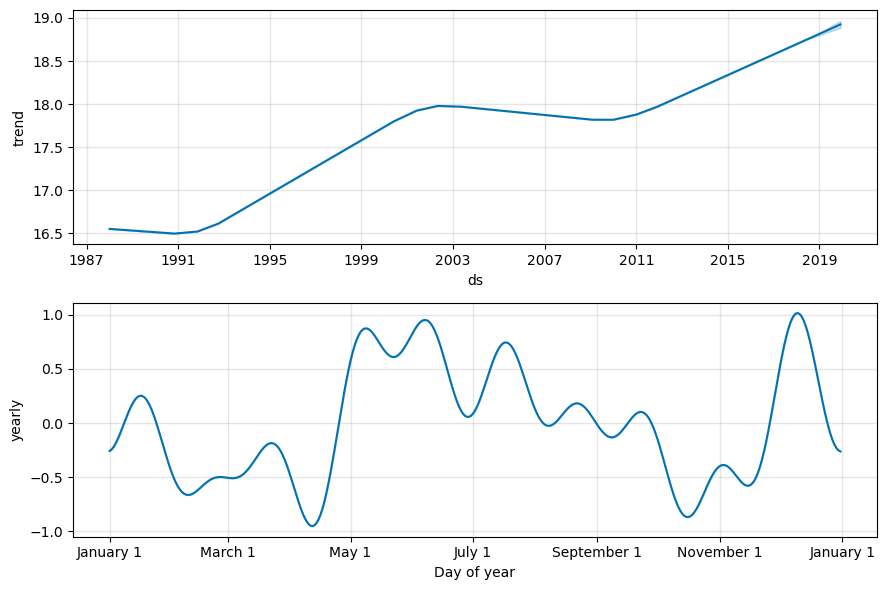

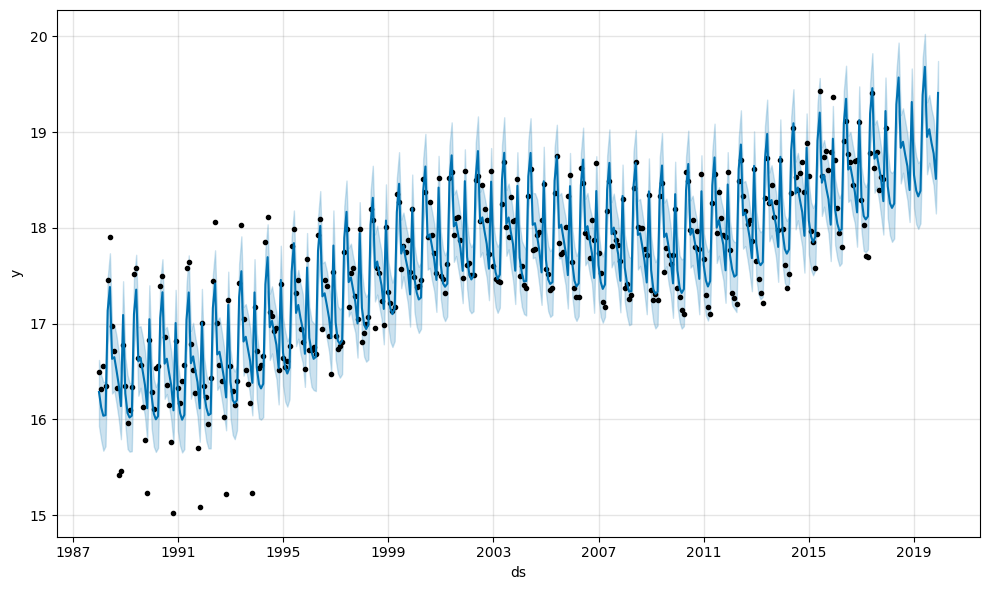

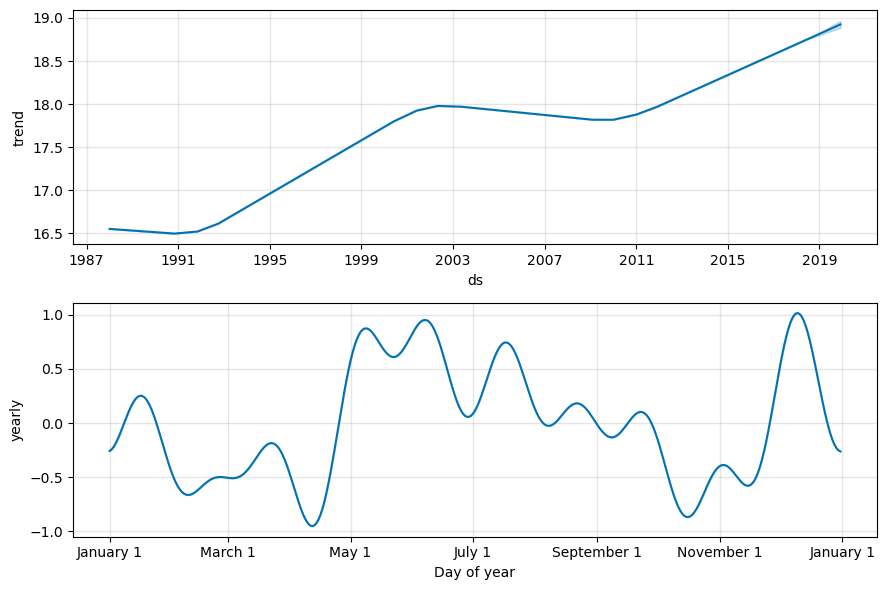

In [110]:
# predict 2018, 2019
future = m.make_future_dataframe(periods = 24, freq="MS")
forecast = m.predict(future)
fig = m.plot(forecast)
m.plot_components(forecast)

In [111]:
forecast = m.predict(future)
predictions = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
predictions

,ds,yhat,yhat_lower,yhat_upper
0,1988-01-01,16.29,15.96,16.63
1,1988-02-01,16.13,15.79,16.46
2,1988-03-01,16.04,15.69,16.36
3,1988-04-01,16.04,15.73,16.41
4,1988-05-01,17.14,16.81,17.49
...,...,...,...,...
379,2019-08-01,19.03,18.70,19.40
380,2019-09-01,18.89,18.53,19.23
381,2019-10-01,18.78,18.45,19.14
382,2019-11-01,18.51,18.15,18.86


In [112]:
# get actual values for each period, between 1988 and 2017, values NOT IN LOG
actuals = df_year_filter(us_data_log, 1988, 2019)
actuals = actuals.rename(columns={'y': 'y-actual'})
actuals

,ds,y-actual
0,1988-01-01,16.49
1,1988-02-01,16.32
2,1988-03-01,16.56
3,1988-04-01,16.35
4,1988-05-01,17.46
...,...,...
379,2019-08-01,18.90
380,2019-09-01,18.80
381,2019-10-01,18.76
382,2019-11-01,18.56


In [113]:
# join actual values and predicted values into one DF
model_eval = predictions.merge(actuals, on='ds', how = 'inner')
model_eval = model_eval.rename(columns={'yhat': 'y-predicted'})
model_eval

,ds,y-predicted,yhat_lower,yhat_upper,y-actual
0,1988-01-01,16.29,15.96,16.63,16.49
1,1988-02-01,16.13,15.79,16.46,16.32
2,1988-03-01,16.04,15.69,16.36,16.56
3,1988-04-01,16.04,15.73,16.41,16.35
4,1988-05-01,17.14,16.81,17.49,17.46
...,...,...,...,...,...
379,2019-08-01,19.03,18.70,19.40,18.90
380,2019-09-01,18.89,18.53,19.23,18.80
381,2019-10-01,18.78,18.45,19.14,18.76
382,2019-11-01,18.51,18.15,18.86,18.56


### Evaluate Model Performance

In [114]:
# return vals to original, take exponent
model_eval_exp = model_eval.copy()
model_eval_exp

,ds,y-predicted,yhat_lower,yhat_upper,y-actual
0,1988-01-01,16.29,15.96,16.63,16.49
1,1988-02-01,16.13,15.79,16.46,16.32
2,1988-03-01,16.04,15.69,16.36,16.56
3,1988-04-01,16.04,15.73,16.41,16.35
4,1988-05-01,17.14,16.81,17.49,17.46
...,...,...,...,...,...
379,2019-08-01,19.03,18.70,19.40,18.90
380,2019-09-01,18.89,18.53,19.23,18.80
381,2019-10-01,18.78,18.45,19.14,18.76
382,2019-11-01,18.51,18.15,18.86,18.56


In [118]:
# return values to original non - log $
model_eval_exp[['y-predicted', 'yhat_lower', 'yhat_upper', 'y-actual']] = np.exp(model_eval_exp[['y-predicted', 'yhat_lower', 'yhat_upper', 'y-actual']])

In [119]:
model_eval_exp

,ds,y-predicted,yhat_lower,yhat_upper,y-actual
0,1988-01-01,"11,834,676.03","8,556,940.73","16,767,638.77","14,515,954.00"
1,1988-02-01,"10,070,261.45","7,174,132.28","14,070,042.16","12,230,446.00"
2,1988-03-01,"9,237,191.08","6,505,818.76","12,755,934.08","15,530,879.00"
3,1988-04-01,"9,288,181.16","6,750,353.34","13,323,872.67","12,658,205.00"
4,1988-05-01,"27,735,015.75","19,944,556.54","39,323,100.52","38,072,540.00"
...,...,...,...,...,...
379,2019-08-01,"184,188,843.17","131,609,716.16","266,931,209.07","161,107,661.00"
380,2019-09-01,"159,925,874.66","111,832,833.94","223,791,909.80","145,986,062.00"
381,2019-10-01,"142,896,264.35","103,368,807.95","204,365,044.76","140,249,272.00"
382,2019-11-01,"109,586,930.22","75,963,698.34","155,865,376.26","114,726,807.00"


In [120]:
#split results for test and train to get metrics for each. 
model_eval_exp_train = df_year_filter(model_eval_exp, 1988, 2017)
model_eval_exp_test = df_year_filter(model_eval_exp, 2018, 2019)


In [121]:
## Baseline Model Documentation:

baseline_rmse = mean_squared_error(model_eval_exp['y-predicted'],model_eval_exp['y-actual'], squared = False)
baseline_rmse_test = mean_squared_error(model_eval_exp_test['y-predicted'],model_eval_exp_test['y-actual'], squared = False)
baseline_rmse_train =  mean_squared_error(model_eval_exp_train['y-predicted'],model_eval_exp_train['y-actual'], squared = False)

baseline_mse = mean_squared_error(model_eval_exp['y-predicted'],model_eval_exp['y-actual'], squared = True)
baseline_mse_test = mean_squared_error(model_eval_exp_test['y-predicted'],model_eval_exp_test['y-actual'], squared = True)
baseline_mse_train =  mean_squared_error(model_eval_exp_train['y-predicted'],model_eval_exp_train['y-actual'], squared = True)

# print(f'baseline rmse for 1988 to 2019 {baseline_rmse} \n baseline mse for 1988 to 2019 {baseline_mse}')

mape_val = mean_absolute_percentage_error(model_eval_exp['y-predicted'],model_eval_exp['y-actual'])
mape_val_test =mean_absolute_percentage_error(model_eval_exp_test['y-predicted'],model_eval_exp_test['y-actual'])
mape_val_train = mean_absolute_percentage_error(model_eval_exp_train['y-predicted'],model_eval_exp_train['y-actual'])

# print(f'mape for 1988 to 2019 {mape_val}')
baseline_results_dict = {'RMSE':[baseline_rmse,baseline_rmse_test,baseline_rmse_train], 'MSE':[baseline_mse,baseline_mse_test,baseline_mse_train], 
'MAPE':[mape_val,mape_val_test,mape_val_train]}
baseline_results = pd.DataFrame(data=baseline_results_dict, index = ['1988 to 2019', 'test: 1988-2017', 'train:2018-2019'])
baseline_results

                                        


,RMSE,MSE,MAPE
1988 to 2019,"19,456,742.70","378,564,836,351,763.31",0.20
test: 1988-2017,"41,226,684.89","1,699,639,546,909,267.25",0.20
train:2018-2019,"17,043,860.74","290,493,188,981,263.00",0.20


In [122]:
baseline_results.to_dict()

{'RMSE': {'1988 to 2019': 19456742.69634471,
  'test: 1988-2017': 41226684.88866486,
  'train:2018-2019': 17043860.741664812},
 'MSE': {'1988 to 2019': 378564836351763.3,
  'test: 1988-2017': 1699639546909267.2,
  'train:2018-2019': 290493188981263.0},
 'MAPE': {'1988 to 2019': 0.20208558343125485,
  'test: 1988-2017': 0.20206824094191264,
  'train:2018-2019': 0.202086739597211}}

#### Visualise Actuals vs Prediction

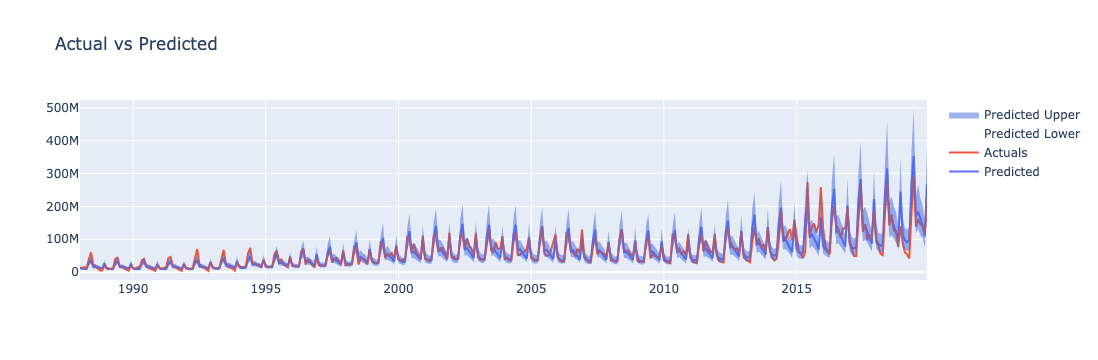

In [123]:
## plot predicted values against actuals, for test range (2018 and 2019 only)
fig = go.Figure()
x_vals1 = df_year_filter(model_eval_exp, 1988, 2019)['ds']


# fig = px.line(preds, title='prediction vs actual', )
fig.add_trace(go.Scatter(
    x=x_vals1,
    y= model_eval_exp['y-predicted'], name = 'Predicted'
))
fig.add_trace(go.Scatter(
    x=x_vals1,
    y= model_eval_exp['y-actual'], name = 'Actuals'
))

fig.update_layout(title='Actual vs Predicted')

fig.add_trace(go.Scatter(x=x_vals1, y=model_eval_exp['yhat_upper'],
    fill=None,
    mode='lines',
    line_color='royalblue',line_width=0, name='Predicted Lower'
    ))
fig.add_trace(go.Scatter(
    x=x_vals1, y=model_eval_exp['yhat_lower'],
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines', line_color='royalblue', line_width=0, name='Predicted Upper'))

fig.show()

In [15]:
df_compare = model_eval_exp

## Model 2: Prophet Tuned with CV

### Get Best Params

??? How to use same test train split for comparison?
Train = 1988 to 2017
Test = 2018, 2019

Attempt:
* Use full dataset to get the best params. 
* Re run model with best params, for test, and train seperately, to get seperate scores for easier comparisons

In [125]:
documentation = {}
documentation['description'] = 'Tuned Prophet Model, with CV, using non-indexed values, non-log values, and filtered commodities for Homarus Americanus Commodities only'

In [126]:
# Prophet suggested ranges

changepoint_range = [0.001, 0.101,0.201,0.301,0.401,0.5]

# print('changepoint_range:',changepoint_range)

seasonality_range=[0.01, 1.01, 3.01, 5.0, 7.01, 10]
# print('seasonality_range: ', seasonality_range)

# holidays_range =  np.arange(0.01, 10, 0.5) 
holidays_range=  [0.01, 1.01, 3.01, 5.0, 7.01, 10]
# print('holidays_range: ', holidays_range)

seasonanility_mode = ['additive', 'multiplicative']
yearly_seasonality = [True, False] 

In [127]:

param_grid = {  
    'changepoint_prior_scale': changepoint_range,
    'seasonality_prior_scale': seasonality_range,
    'seasonality_mode':seasonanility_mode, 
    'yearly_seasonality':  yearly_seasonality  
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# all_params
documentation['params_options']= param_grid
documentation

{'description': 'Tuned Prophet Model, with CV, using non-indexed values, non-log values, and filtered commodities for Homarus Americanus Commodities only',
 'params_options': {'changepoint_prior_scale': [0.001,
   0.101,
   0.201,
   0.301,
   0.401,
   0.5],
  'seasonality_prior_scale': [0.01, 1.01, 3.01, 5.0, 7.01, 10],
  'seasonality_mode': ['additive', 'multiplicative'],
  'yearly_seasonality': [True, False]}}

QUESTION: 
* run model for entire data or just training range set given CV?
* default code df_cv value at index 0 meaning? 
* for each loop df_p returns RMSE's for many time horizons how to get one value ?
    * reconclie df_p, vs df_cv meaning
    * take average of all RMSE's in the loop (over different horizons)

In [128]:
# # Use cross-validationa to evaluate all parameters
## takes ~~3 minutes to run

## variables 
cv_cutoffs = pd.to_datetime(['2018-01-01', '2019-01-01']) # manually set dates for new prediction
cv_initial = '10593 days' # number of days from 1988 to 2017
cv_period = '365 days'
cv_horizon = '365 days'
cv_parallel = 'processes'

## Lists to store metrics for each param combo
rmses = []  # Store the RMSEs for each params here
mapes = []# Store the MAPES for each params here
rmses_avg = [] # to compare, the avg rmse for all horizons
mapes_avg = [] # to compare, the avg MAPE for all horizons

# for each unique param combo, run a prophet model 
for params in all_params:
    print(params)
    m = Prophet(**params).fit(us_data)  
    # initial/train from 1988 to 2017 
    # then after 2017, predict one year out every on Jan 1 2018, and Jan 1 2019
    df_cv = cross_validation(m, initial=cv_initial, period=cv_period, horizon = cv_horizon, parallel=cv_parallel, cutoffs=cv_cutoffs)
    print(df_cv)
    # get metrics for overall predictions made using CV, not just on one horizon
    rmse_val = np.sqrt(mean_squared_error(df_cv['y'],df_cv['yhat']))
    mape_val = mean_absolute_percentage_error(df_cv['y'],df_cv['yhat'])
    df_p = performance_metrics(df_cv, rolling_window=1)
    # print(df_p)
    rmses.append(rmse_val)
    mapes.append(mape_val)
    rmses_avg.append(df_p['rmse'].mean())
    mapes_avg.append(df_p['mape'].mean())

documentation[".fit()"] =  get_variable_name(us_data, locals())
documentation['cv_param_cutoffs'] = cv_cutoffs
documentation['cv_param_initial'] = cv_initial
documentation['cv_param_period'] = cv_period
documentation['cv_param_horizon'] = cv_horizon
documentation['cv_param_parallel'] = cv_parallel

# dd/mm/YY H:M:S
now = datetime.now()
dt_string = now.strftime("%Y-%m-%d %H:%M")
documentation["model_prediction_date:"] =  dt_string


12:20:53 - cmdstanpy - INFO - Chain [1] start processing
12:20:53 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True}


12:20:54 - cmdstanpy - INFO - Chain [1] start processing
12:20:54 - cmdstanpy - INFO - Chain [1] start processing
12:20:54 - cmdstanpy - INFO - Chain [1] done processing
12:20:54 - cmdstanpy - INFO - Chain [1] done processing
12:20:54 - cmdstanpy - INFO - Chain [1] start processing
12:20:54 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  83,218,833.83  52,979,493.26 111,483,516.02   80965152   
1  2018-03-01  79,957,769.80  48,216,857.69 112,624,755.24   55383560   
2  2018-04-01  79,288,796.14  49,000,068.31 107,977,915.90   51622955   
3  2018-05-01 124,702,374.24  95,467,271.91 153,468,131.23  176968819   
4  2018-06-01 148,658,592.44 117,867,252.92 175,877,828.82  274311951   
5  2018-07-01 100,850,746.71  69,851,169.19 131,661,164.07  141734086   
6  2018-08-01 105,781,731.64  75,504,891.01 135,121,844.62  175208071   
7  2018-09-01 100,605,736.23  71,075,796.79 130,529,298.92  126732400   
8  2018-10-01 100,111,722.78  70,051,366.44 128,243,491.61  125340703   
9  2018-11-01  96,309,393.36  66,660,137.39 125,166,505.19   76371568   
10 2018-12-01 136,698,071.21 106,680,875.64 168,042,305.74  139650313   
11 2019-01-01  92,440,116.82  61,972,370.41 121,783,660.22   87750515   
12 2019-02-01  87,225,023.90  54,351,300.11 118,988

12:20:54 - cmdstanpy - INFO - Chain [1] start processing
12:20:54 - cmdstanpy - INFO - Chain [1] start processing
12:20:54 - cmdstanpy - INFO - Chain [1] done processing
12:20:54 - cmdstanpy - INFO - Chain [1] done processing
12:20:54 - cmdstanpy - INFO - Chain [1] start processing
12:20:54 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 104,464,821.29 57,809,781.25 150,338,040.50   80965152   
1  2018-03-01 104,680,595.24 60,479,120.84 150,314,229.04   55383560   
2  2018-04-01 104,919,487.83 57,067,426.12 150,173,267.25   51622955   
3  2018-05-01 105,150,674.21 60,309,822.74 148,663,976.47  176968819   
4  2018-06-01 105,389,566.81 63,318,394.39 154,075,140.59  274311951   
5  2018-07-01 105,620,753.19 61,219,955.63 152,178,090.62  141734086   
6  2018-08-01 105,859,645.78 58,598,545.87 151,912,812.14  175208071   
7  2018-09-01 106,098,538.37 61,063,376.91 151,606,430.05  126732400   
8  2018-10-01 106,329,724.75 60,884,330.12 152,972,161.33  125340703   
9  2018-11-01 106,568,617.35 62,675,426.15 149,978,156.92   76371568   
10 2018-12-01 106,799,803.73 60,096,141.30 152,754,656.00  139650313   
11 2019-01-01 107,038,696.32 64,111,582.42 152,493,633.19   87750515   
12 2019-02-01 108,613,053.39 58,395,090.73 155,141,577.91   5976

12:20:55 - cmdstanpy - INFO - Chain [1] start processing
12:20:55 - cmdstanpy - INFO - Chain [1] start processing
12:20:55 - cmdstanpy - INFO - Chain [1] done processing
12:20:55 - cmdstanpy - INFO - Chain [1] done processing
12:20:55 - cmdstanpy - INFO - Chain [1] start processing
12:20:55 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 101,990,538.29 60,449,321.96 144,804,152.70   80965152   
1  2018-03-01 100,749,418.04 62,605,788.88 144,991,102.56   55383560   
2  2018-04-01 100,073,754.96 54,590,861.63 139,260,283.11   51622955   
3  2018-05-01 109,520,303.94 65,527,844.51 150,229,859.59  176968819   
4  2018-06-01 115,167,831.69 71,872,570.19 153,726,753.73  274311951   
5  2018-07-01 104,501,041.50 60,822,625.80 148,889,309.16  141734086   
6  2018-08-01 105,899,444.63 64,358,807.05 145,705,179.04  175208071   
7  2018-09-01 105,008,053.04 64,501,200.23 148,907,777.50  126732400   
8  2018-10-01 105,801,440.87 63,548,238.98 145,639,271.01  125340703   
9  2018-11-01 105,603,297.33 62,696,664.68 147,187,852.92   76371568   
10 2018-12-01 115,536,621.49 76,275,962.07 154,791,815.16  139650313   
11 2019-01-01 105,832,429.87 62,443,655.75 149,507,511.64   87750515   
12 2019-02-01 107,298,438.97 61,665,991.38 154,903,367.55   5976

12:20:55 - cmdstanpy - INFO - Chain [1] start processing
12:20:55 - cmdstanpy - INFO - Chain [1] start processing
12:20:55 - cmdstanpy - INFO - Chain [1] done processing
12:20:55 - cmdstanpy - INFO - Chain [1] done processing
12:20:55 - cmdstanpy - INFO - Chain [1] start processing
12:20:55 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 104,464,821.29 60,996,600.41 149,265,712.29   80965152   
1  2018-03-01 104,680,595.24 61,047,063.84 152,265,205.37   55383560   
2  2018-04-01 104,919,487.83 61,194,693.89 148,509,545.49   51622955   
3  2018-05-01 105,150,674.21 62,175,891.20 155,174,267.58  176968819   
4  2018-06-01 105,389,566.81 63,963,764.62 152,356,434.84  274311951   
5  2018-07-01 105,620,753.19 62,455,569.00 150,372,768.37  141734086   
6  2018-08-01 105,859,645.78 57,763,412.64 150,177,420.70  175208071   
7  2018-09-01 106,098,538.37 58,863,079.06 153,164,611.29  126732400   
8  2018-10-01 106,329,724.75 59,689,291.73 151,876,642.13  125340703   
9  2018-11-01 106,568,617.35 60,626,634.41 150,692,294.65   76371568   
10 2018-12-01 106,799,803.73 63,038,720.23 153,227,730.29  139650313   
11 2019-01-01 107,038,696.32 60,313,741.86 149,644,825.59   87750515   
12 2019-02-01 108,613,053.39 56,495,360.69 154,248,003.17   5976

12:20:56 - cmdstanpy - INFO - Chain [1] start processing
12:20:56 - cmdstanpy - INFO - Chain [1] start processing
12:20:56 - cmdstanpy - INFO - Chain [1] done processing
12:20:56 - cmdstanpy - INFO - Chain [1] done processing
12:20:56 - cmdstanpy - INFO - Chain [1] start processing
12:20:56 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  73,565,076.65  33,787,831.81 111,238,605.59   80965152   
1  2018-03-01  73,157,818.48  36,799,063.49 110,667,260.61   55383560   
2  2018-04-01  75,373,313.04  35,159,051.08 117,137,744.44   51622955   
3  2018-05-01 123,130,515.56  83,171,610.95 164,174,538.44  176968819   
4  2018-06-01 150,207,749.83 108,173,094.69 186,922,467.21  274311951   
5  2018-07-01 102,916,220.62  67,417,510.78 141,433,023.37  141734086   
6  2018-08-01 107,152,187.45  68,774,495.70 145,115,111.56  175208071   
7  2018-09-01 100,570,781.90  62,188,362.20 137,817,810.80  126732400   
8  2018-10-01  98,051,216.38  57,641,923.02 137,593,022.11  125340703   
9  2018-11-01  92,750,209.20  56,196,759.94 130,640,962.85   76371568   
10 2018-12-01 131,792,188.99  93,373,610.98 172,741,412.32  139650313   
11 2019-01-01  84,564,857.07  44,657,171.09 124,058,722.74   87750515   
12 2019-02-01  80,050,104.07  29,767,120.43 129,416

12:20:56 - cmdstanpy - INFO - Chain [1] start processing
12:20:56 - cmdstanpy - INFO - Chain [1] start processing
12:20:56 - cmdstanpy - INFO - Chain [1] done processing
12:20:56 - cmdstanpy - INFO - Chain [1] done processing
12:20:56 - cmdstanpy - INFO - Chain [1] start processing
12:20:56 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 104,464,821.29 59,765,796.91 151,692,002.55   80965152   
1  2018-03-01 104,680,595.24 55,731,949.28 147,688,774.52   55383560   
2  2018-04-01 104,919,487.83 60,908,570.10 148,338,876.81   51622955   
3  2018-05-01 105,150,674.21 62,584,673.51 149,577,463.16  176968819   
4  2018-06-01 105,389,566.81 60,890,075.06 148,723,643.75  274311951   
5  2018-07-01 105,620,753.19 60,445,323.99 149,417,037.30  141734086   
6  2018-08-01 105,859,645.78 57,653,858.34 147,864,631.10  175208071   
7  2018-09-01 106,098,538.37 64,103,262.95 150,688,840.80  126732400   
8  2018-10-01 106,329,724.75 60,624,123.64 154,430,030.98  125340703   
9  2018-11-01 106,568,617.35 59,462,984.92 151,650,156.34   76371568   
10 2018-12-01 106,799,803.73 60,291,344.26 150,564,021.67  139650313   
11 2019-01-01 107,038,696.32 60,767,691.37 151,651,827.64   87750515   
12 2019-02-01 108,613,053.39 58,368,858.76 155,699,608.88   5976

12:20:57 - cmdstanpy - INFO - Chain [1] start processing
12:20:57 - cmdstanpy - INFO - Chain [1] start processing
12:20:57 - cmdstanpy - INFO - Chain [1] done processing
12:20:57 - cmdstanpy - INFO - Chain [1] done processing
12:20:57 - cmdstanpy - INFO - Chain [1] start processing
12:20:57 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 100,993,624.49 58,625,125.77 140,358,510.55   80965152   
1  2018-03-01  99,379,975.23 58,307,517.85 141,250,148.36   55383560   
2  2018-04-01  98,472,152.87 57,037,344.52 139,955,893.75   51622955   
3  2018-05-01 110,278,705.72 70,879,046.34 152,654,472.69  176968819   
4  2018-06-01 117,313,047.30 73,209,171.10 158,201,017.40  274311951   
5  2018-07-01 103,854,876.57 63,878,959.23 145,871,468.07  141734086   
6  2018-08-01 105,549,994.32 64,869,792.96 148,263,394.86  175208071   
7  2018-09-01 104,367,208.49 62,632,239.24 142,377,309.86  126732400   
8  2018-10-01 105,304,293.79 64,372,634.73 148,166,451.93  125340703   
9  2018-11-01 104,994,472.61 63,545,763.07 147,317,249.69   76371568   
10 2018-12-01 117,412,746.41 78,699,366.65 157,036,814.63  139650313   
11 2019-01-01 105,162,058.66 62,828,616.71 145,249,358.88   87750515   
12 2019-02-01 105,475,052.98 61,092,936.64 149,627,099.49   5976

12:20:57 - cmdstanpy - INFO - Chain [1] start processing
12:20:57 - cmdstanpy - INFO - Chain [1] start processing
12:20:57 - cmdstanpy - INFO - Chain [1] done processing
12:20:57 - cmdstanpy - INFO - Chain [1] done processing
12:20:57 - cmdstanpy - INFO - Chain [1] start processing
12:20:57 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 104,464,821.29 58,242,129.67 151,500,371.12   80965152   
1  2018-03-01 104,680,595.24 59,858,486.63 150,137,513.44   55383560   
2  2018-04-01 104,919,487.83 61,458,117.72 146,216,135.64   51622955   
3  2018-05-01 105,150,674.21 60,699,781.13 152,282,469.73  176968819   
4  2018-06-01 105,389,566.81 60,794,853.71 149,501,697.57  274311951   
5  2018-07-01 105,620,753.19 61,381,446.54 149,500,766.64  141734086   
6  2018-08-01 105,859,645.78 57,189,627.56 151,821,228.37  175208071   
7  2018-09-01 106,098,538.37 59,735,553.01 153,047,327.00  126732400   
8  2018-10-01 106,329,724.75 62,061,537.80 146,081,140.78  125340703   
9  2018-11-01 106,568,617.35 60,597,703.31 151,349,869.50   76371568   
10 2018-12-01 106,799,803.73 61,631,103.57 152,973,414.90  139650313   
11 2019-01-01 107,038,696.32 61,299,079.83 150,769,406.11   87750515   
12 2019-02-01 108,613,053.39 59,622,238.05 155,582,707.88   5976

12:20:58 - cmdstanpy - INFO - Chain [1] start processing
12:20:58 - cmdstanpy - INFO - Chain [1] start processing
12:20:58 - cmdstanpy - INFO - Chain [1] done processing
12:20:58 - cmdstanpy - INFO - Chain [1] done processing
12:20:58 - cmdstanpy - INFO - Chain [1] start processing
12:20:58 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  73,608,641.50  34,198,893.74 110,918,549.50   80965152   
1  2018-03-01  72,919,728.36  36,643,815.38 110,649,689.40   55383560   
2  2018-04-01  74,886,032.17  34,828,341.07 112,864,656.03   51622955   
3  2018-05-01 123,700,337.60  87,716,041.17 163,278,211.39  176968819   
4  2018-06-01 151,209,517.10 113,970,188.53 190,289,882.04  274311951   
5  2018-07-01 102,538,036.32  63,806,969.80 144,730,573.70  141734086   
6  2018-08-01 106,949,430.01  68,617,115.25 144,692,294.61  175208071   
7  2018-09-01 100,319,476.96  62,226,465.89 139,514,284.26  126732400   
8  2018-10-01  97,938,983.27  60,623,501.08 136,338,251.53  125340703   
9  2018-11-01  92,665,496.05  55,426,187.02 133,585,695.42   76371568   
10 2018-12-01 132,940,874.07  93,955,451.87 172,563,077.41  139650313   
11 2019-01-01  84,674,716.45  46,515,004.44 121,280,602.09   87750515   
12 2019-02-01  80,055,847.65  33,196,670.14 128,584

12:20:58 - cmdstanpy - INFO - Chain [1] start processing
12:20:58 - cmdstanpy - INFO - Chain [1] start processing
12:20:58 - cmdstanpy - INFO - Chain [1] done processing
12:20:58 - cmdstanpy - INFO - Chain [1] done processing
12:20:58 - cmdstanpy - INFO - Chain [1] start processing
12:20:58 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 104,464,821.29 58,537,158.18 147,210,734.54   80965152   
1  2018-03-01 104,680,595.24 59,615,763.20 146,865,743.45   55383560   
2  2018-04-01 104,919,487.83 58,514,579.27 150,571,090.98   51622955   
3  2018-05-01 105,150,674.21 58,761,506.54 150,098,656.49  176968819   
4  2018-06-01 105,389,566.81 61,164,475.64 152,150,665.04  274311951   
5  2018-07-01 105,620,753.19 64,381,250.81 152,418,473.25  141734086   
6  2018-08-01 105,859,645.78 59,745,300.04 146,432,894.11  175208071   
7  2018-09-01 106,098,538.37 62,629,383.98 153,269,584.54  126732400   
8  2018-10-01 106,329,724.75 60,000,257.38 150,344,795.85  125340703   
9  2018-11-01 106,568,617.35 60,427,767.03 151,120,144.17   76371568   
10 2018-12-01 106,799,803.73 57,429,565.12 152,362,483.31  139650313   
11 2019-01-01 107,038,696.32 64,014,165.95 152,938,868.38   87750515   
12 2019-02-01 108,613,053.39 60,403,749.66 159,896,412.81   5976

12:20:59 - cmdstanpy - INFO - Chain [1] start processing
12:20:59 - cmdstanpy - INFO - Chain [1] start processing
12:20:59 - cmdstanpy - INFO - Chain [1] done processing
12:20:59 - cmdstanpy - INFO - Chain [1] done processing
12:20:59 - cmdstanpy - INFO - Chain [1] start processing
12:20:59 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 100,995,868.79 61,586,043.17 144,507,899.63   80965152   
1  2018-03-01  99,382,456.71 59,410,537.14 143,519,089.96   55383560   
2  2018-04-01  98,474,782.44 62,255,295.06 142,086,373.69   51622955   
3  2018-05-01 110,279,783.56 68,793,620.38 149,519,736.40  176968819   
4  2018-06-01 117,313,200.95 80,191,898.66 159,246,988.66  274311951   
5  2018-07-01 103,856,871.91 61,782,174.71 144,958,593.10  141734086   
6  2018-08-01 105,551,798.66 65,017,918.78 145,034,293.24  175208071   
7  2018-09-01 104,369,194.30 61,538,518.99 141,535,279.57  126732400   
8  2018-10-01 105,306,189.53 63,664,151.17 149,113,219.24  125340703   
9  2018-11-01 104,996,453.79 65,809,821.66 144,558,668.08   76371568   
10 2018-12-01 117,413,115.43 76,180,594.82 157,508,699.22  139650313   
11 2019-01-01 105,164,119.26 67,333,976.65 146,743,522.69   87750515   
12 2019-02-01 105,477,538.23 63,851,988.57 146,818,520.43   5976

12:20:59 - cmdstanpy - INFO - Chain [1] start processing
12:20:59 - cmdstanpy - INFO - Chain [1] start processing
12:20:59 - cmdstanpy - INFO - Chain [1] done processing
12:20:59 - cmdstanpy - INFO - Chain [1] done processing
12:21:00 - cmdstanpy - INFO - Chain [1] start processing
12:21:00 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 104,464,821.29 56,913,847.38 149,202,874.60   80965152   
1  2018-03-01 104,680,595.24 61,770,088.99 154,788,380.57   55383560   
2  2018-04-01 104,919,487.83 59,314,077.12 150,649,780.47   51622955   
3  2018-05-01 105,150,674.21 61,443,273.72 150,851,100.85  176968819   
4  2018-06-01 105,389,566.81 56,996,334.25 151,371,265.19  274311951   
5  2018-07-01 105,620,753.19 58,616,203.38 152,851,563.32  141734086   
6  2018-08-01 105,859,645.78 58,694,057.09 150,599,840.47  175208071   
7  2018-09-01 106,098,538.37 63,931,138.36 151,227,346.23  126732400   
8  2018-10-01 106,329,724.75 59,866,510.99 154,404,280.45  125340703   
9  2018-11-01 106,568,617.35 64,057,125.03 150,361,936.13   76371568   
10 2018-12-01 106,799,803.73 60,907,095.51 149,440,797.18  139650313   
11 2019-01-01 107,038,696.32 62,451,640.17 153,446,296.55   87750515   
12 2019-02-01 108,613,053.39 62,043,111.04 159,815,634.95   5976

12:21:00 - cmdstanpy - INFO - Chain [1] start processing
12:21:00 - cmdstanpy - INFO - Chain [1] start processing
12:21:00 - cmdstanpy - INFO - Chain [1] done processing
12:21:00 - cmdstanpy - INFO - Chain [1] done processing
12:21:00 - cmdstanpy - INFO - Chain [1] start processing
12:21:00 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  73,582,517.44  35,455,404.24 113,693,337.96   80965152   
1  2018-03-01  73,307,911.59  34,395,900.81 113,042,746.06   55383560   
2  2018-04-01  75,558,987.65  36,125,204.94 114,539,110.90   51622955   
3  2018-05-01 122,930,174.39  85,333,786.16 162,061,829.84  176968819   
4  2018-06-01 149,875,791.42 109,348,147.71 186,804,626.97  274311951   
5  2018-07-01 103,000,791.93  63,895,134.83 144,772,052.69  141734086   
6  2018-08-01 107,169,409.64  69,236,053.58 147,302,125.15  175208071   
7  2018-09-01 100,611,929.44  59,868,766.94 141,606,614.01  126732400   
8  2018-10-01  98,074,366.80  57,765,861.32 138,806,000.96  125340703   
9  2018-11-01  92,823,869.45  54,836,347.02 131,396,208.89   76371568   
10 2018-12-01 131,515,671.85  92,745,635.76 171,266,782.58  139650313   
11 2019-01-01  84,559,807.86  44,935,239.95 119,596,679.91   87750515   
12 2019-02-01  75,533,210.30  24,620,621.50 122,063

12:21:00 - cmdstanpy - INFO - Chain [1] start processing
12:21:00 - cmdstanpy - INFO - Chain [1] start processing
12:21:00 - cmdstanpy - INFO - Chain [1] done processing
12:21:00 - cmdstanpy - INFO - Chain [1] done processing
12:21:01 - cmdstanpy - INFO - Chain [1] start processing
12:21:01 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 104,464,821.29 60,078,356.98 148,053,079.90   80965152   
1  2018-03-01 104,680,595.24 59,088,284.03 148,714,061.58   55383560   
2  2018-04-01 104,919,487.83 57,172,910.82 148,119,894.81   51622955   
3  2018-05-01 105,150,674.21 57,373,131.90 150,305,965.98  176968819   
4  2018-06-01 105,389,566.81 61,036,038.93 150,593,705.46  274311951   
5  2018-07-01 105,620,753.19 62,763,453.41 148,193,123.91  141734086   
6  2018-08-01 105,859,645.78 61,061,818.62 152,945,052.88  175208071   
7  2018-09-01 106,098,538.37 61,367,901.23 153,331,926.49  126732400   
8  2018-10-01 106,329,724.75 61,278,713.03 155,134,590.05  125340703   
9  2018-11-01 106,568,617.35 62,195,231.28 151,237,479.26   76371568   
10 2018-12-01 106,799,803.73 61,381,500.05 150,345,468.94  139650313   
11 2019-01-01 107,038,696.32 61,348,451.69 151,310,662.82   87750515   
12 2019-02-01 108,613,053.39 61,431,880.12 159,822,083.68   5976

12:21:01 - cmdstanpy - INFO - Chain [1] start processing
12:21:01 - cmdstanpy - INFO - Chain [1] start processing
12:21:01 - cmdstanpy - INFO - Chain [1] done processing
12:21:01 - cmdstanpy - INFO - Chain [1] done processing
12:21:01 - cmdstanpy - INFO - Chain [1] start processing
12:21:01 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 100,997,655.19 59,528,226.65 143,396,005.98   80965152   
1  2018-03-01  99,384,465.00 57,600,230.24 139,601,804.73   55383560   
2  2018-04-01  98,476,951.10 60,801,527.17 139,110,824.78   51622955   
3  2018-05-01 110,280,375.41 70,866,698.98 152,725,498.30  176968819   
4  2018-06-01 117,312,876.15 76,934,937.31 156,139,357.96  274311951   
5  2018-07-01 103,858,380.98 63,622,461.46 147,908,358.06  141734086   
6  2018-08-01 105,553,117.30 57,877,260.46 147,186,580.00  175208071   
7  2018-09-01 104,370,692.28 64,924,633.28 145,759,991.47  126732400   
8  2018-10-01 105,307,607.47 63,862,207.14 148,732,196.43  125340703   
9  2018-11-01 104,997,957.38 68,597,151.53 148,361,679.49   76371568   
10 2018-12-01 117,413,002.67 74,650,113.25 158,848,175.12  139650313   
11 2019-01-01 105,165,696.98 59,476,835.71 143,022,581.08   87750515   
12 2019-02-01 105,470,842.28 60,213,970.34 147,506,968.00   5976

12:21:02 - cmdstanpy - INFO - Chain [1] start processing
12:21:02 - cmdstanpy - INFO - Chain [1] start processing
12:21:02 - cmdstanpy - INFO - Chain [1] done processing
12:21:02 - cmdstanpy - INFO - Chain [1] done processing
12:21:02 - cmdstanpy - INFO - Chain [1] start processing
12:21:02 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 104,464,821.29 58,404,544.62 147,192,765.72   80965152   
1  2018-03-01 104,680,595.24 57,275,323.11 147,427,737.01   55383560   
2  2018-04-01 104,919,487.83 56,945,723.70 146,610,811.32   51622955   
3  2018-05-01 105,150,674.21 60,766,565.27 152,378,003.66  176968819   
4  2018-06-01 105,389,566.81 60,057,312.70 151,029,989.65  274311951   
5  2018-07-01 105,620,753.19 60,973,689.90 149,027,653.45  141734086   
6  2018-08-01 105,859,645.78 62,428,472.55 146,909,762.69  175208071   
7  2018-09-01 106,098,538.37 63,420,680.95 150,979,517.54  126732400   
8  2018-10-01 106,329,724.75 61,624,663.64 152,040,164.77  125340703   
9  2018-11-01 106,568,617.35 62,703,215.27 151,374,071.56   76371568   
10 2018-12-01 106,799,803.73 60,160,951.11 154,066,768.80  139650313   
11 2019-01-01 107,038,696.32 61,468,612.11 151,203,379.13   87750515   
12 2019-02-01 108,613,053.39 62,291,799.20 156,662,965.52   5976

12:21:02 - cmdstanpy - INFO - Chain [1] start processing
12:21:02 - cmdstanpy - INFO - Chain [1] start processing
12:21:02 - cmdstanpy - INFO - Chain [1] done processing
12:21:02 - cmdstanpy - INFO - Chain [1] done processing
12:21:02 - cmdstanpy - INFO - Chain [1] start processing
12:21:02 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  73,571,209.94  36,101,896.26 113,078,507.87   80965152   
1  2018-03-01  73,237,543.16  33,441,984.65 112,715,141.22   55383560   
2  2018-04-01  75,449,266.27  37,814,696.31 115,318,248.29   51622955   
3  2018-05-01 123,019,107.97  84,171,203.26 165,656,471.88  176968819   
4  2018-06-01 150,040,735.29 112,221,957.32 188,272,633.53  274311951   
5  2018-07-01 102,919,023.75  65,586,164.95 141,571,363.36  141734086   
6  2018-08-01 107,121,471.90  67,572,281.73 143,375,253.66  175208071   
7  2018-09-01 100,554,357.67  63,308,615.10 138,525,659.86  126732400   
8  2018-10-01  98,038,535.90  58,921,495.30 137,164,949.64  125340703   
9  2018-11-01  92,784,128.82  51,887,477.18 128,935,102.50   76371568   
10 2018-12-01 131,692,986.96  91,186,386.63 172,720,315.84  139650313   
11 2019-01-01  84,559,316.48  47,247,119.71 123,847,717.04   87750515   
12 2019-02-01  80,057,130.94  30,550,999.94 132,376

12:21:03 - cmdstanpy - INFO - Chain [1] start processing
12:21:03 - cmdstanpy - INFO - Chain [1] start processing
12:21:03 - cmdstanpy - INFO - Chain [1] done processing
12:21:03 - cmdstanpy - INFO - Chain [1] done processing
12:21:03 - cmdstanpy - INFO - Chain [1] start processing
12:21:03 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 104,464,821.29 60,087,880.70 148,794,174.20   80965152   
1  2018-03-01 104,680,595.24 58,760,475.98 149,217,089.54   55383560   
2  2018-04-01 104,919,487.83 58,695,726.72 150,923,501.80   51622955   
3  2018-05-01 105,150,674.21 58,648,532.41 150,328,228.50  176968819   
4  2018-06-01 105,389,566.81 61,938,593.98 151,720,454.51  274311951   
5  2018-07-01 105,620,753.19 61,610,480.61 151,261,069.01  141734086   
6  2018-08-01 105,859,645.78 57,324,885.34 149,564,461.26  175208071   
7  2018-09-01 106,098,538.37 61,702,376.73 150,033,187.50  126732400   
8  2018-10-01 106,329,724.75 60,415,955.37 149,363,866.20  125340703   
9  2018-11-01 106,568,617.35 58,273,073.84 149,170,322.63   76371568   
10 2018-12-01 106,799,803.73 60,512,122.87 151,377,121.85  139650313   
11 2019-01-01 107,038,696.32 58,085,004.03 153,235,794.62   87750515   
12 2019-02-01 108,613,053.39 58,727,679.70 156,178,592.11   5976

12:21:03 - cmdstanpy - INFO - Chain [1] start processing
12:21:03 - cmdstanpy - INFO - Chain [1] start processing
12:21:03 - cmdstanpy - INFO - Chain [1] done processing
12:21:03 - cmdstanpy - INFO - Chain [1] done processing
12:21:03 - cmdstanpy - INFO - Chain [1] start processing
12:21:03 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 100,997,252.95 59,257,242.37 142,879,951.51   80965152   
1  2018-03-01  99,384,120.09 57,736,079.35 139,920,507.63   55383560   
2  2018-04-01  98,476,630.17 59,929,501.04 138,418,878.82   51622955   
3  2018-05-01 110,279,691.84 68,054,053.03 151,017,290.03  176968819   
4  2018-06-01 117,311,939.67 76,087,308.71 157,469,319.63  274311951   
5  2018-07-01 103,857,876.50 59,945,571.18 141,374,242.57  141734086   
6  2018-08-01 105,552,581.86 63,432,292.05 145,700,430.33  175208071   
7  2018-09-01 104,370,201.80 62,272,050.14 143,718,473.13  126732400   
8  2018-10-01 105,307,090.07 67,845,938.43 144,847,215.13  125340703   
9  2018-11-01 104,997,475.35 63,738,294.33 144,600,214.76   76371568   
10 2018-12-01 117,412,103.01 79,382,396.78 159,766,964.83  139650313   
11 2019-01-01 105,165,195.51 63,589,408.44 144,910,574.13   87750515   
12 2019-02-01 105,473,521.50 61,220,002.95 152,996,972.25   5976

12:21:04 - cmdstanpy - INFO - Chain [1] start processing
12:21:04 - cmdstanpy - INFO - Chain [1] start processing
12:21:04 - cmdstanpy - INFO - Chain [1] done processing
12:21:04 - cmdstanpy - INFO - Chain [1] done processing
12:21:04 - cmdstanpy - INFO - Chain [1] start processing
12:21:04 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 104,464,821.29 56,518,848.82 150,821,922.41   80965152   
1  2018-03-01 104,680,595.24 59,053,168.38 152,888,167.31   55383560   
2  2018-04-01 104,919,487.83 57,251,980.09 148,005,888.28   51622955   
3  2018-05-01 105,150,674.21 61,677,435.77 148,476,715.83  176968819   
4  2018-06-01 105,389,566.81 59,285,546.62 151,681,232.05  274311951   
5  2018-07-01 105,620,753.19 59,059,489.10 151,087,170.81  141734086   
6  2018-08-01 105,859,645.78 57,728,905.42 149,640,575.06  175208071   
7  2018-09-01 106,098,538.37 60,584,176.30 152,484,157.26  126732400   
8  2018-10-01 106,329,724.75 60,789,786.76 151,174,402.93  125340703   
9  2018-11-01 106,568,617.35 59,188,561.50 149,582,856.59   76371568   
10 2018-12-01 106,799,803.73 64,413,142.56 154,267,332.86  139650313   
11 2019-01-01 107,038,696.32 58,021,391.89 152,877,485.99   87750515   
12 2019-02-01 108,613,053.39 60,307,543.44 157,219,469.79   5976

12:21:04 - cmdstanpy - INFO - Chain [1] start processing
12:21:04 - cmdstanpy - INFO - Chain [1] start processing
12:21:04 - cmdstanpy - INFO - Chain [1] done processing
12:21:04 - cmdstanpy - INFO - Chain [1] done processing
12:21:04 - cmdstanpy - INFO - Chain [1] start processing
12:21:04 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  73,577,201.79  32,214,085.34 111,181,749.53   80965152   
1  2018-03-01  73,251,768.11  33,909,951.90 112,809,783.75   55383560   
2  2018-04-01  75,467,594.96  38,934,319.89 115,019,774.19   51622955   
3  2018-05-01 123,017,139.41  84,927,010.40 163,933,211.87  176968819   
4  2018-06-01 150,032,512.42 110,532,227.27 188,131,641.58  274311951   
5  2018-07-01 102,935,277.06  62,451,481.56 140,570,851.73  141734086   
6  2018-08-01 107,133,791.99  70,886,933.67 147,802,625.99  175208071   
7  2018-09-01 100,567,269.33  64,167,210.84 139,327,449.26  126732400   
8  2018-10-01  98,049,142.02  63,414,559.27 137,927,579.82  125340703   
9  2018-11-01  92,796,125.02  55,057,609.57 129,598,257.48   76371568   
10 2018-12-01 131,683,733.27  93,963,081.18 173,116,927.89  139650313   
11 2019-01-01  84,565,316.19  44,904,537.65 122,911,664.57   87750515   
12 2019-02-01  80,057,270.23  32,941,056.28 128,059

12:21:05 - cmdstanpy - INFO - Chain [1] start processing
12:21:05 - cmdstanpy - INFO - Chain [1] start processing
12:21:05 - cmdstanpy - INFO - Chain [1] done processing
12:21:05 - cmdstanpy - INFO - Chain [1] done processing
12:21:05 - cmdstanpy - INFO - Chain [1] start processing
12:21:05 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 104,464,821.29 58,437,169.97 154,331,905.35   80965152   
1  2018-03-01 104,680,595.24 57,940,494.72 150,648,177.64   55383560   
2  2018-04-01 104,919,487.83 58,472,948.97 150,376,270.64   51622955   
3  2018-05-01 105,150,674.21 61,300,493.29 151,736,307.05  176968819   
4  2018-06-01 105,389,566.81 58,492,584.56 150,315,676.19  274311951   
5  2018-07-01 105,620,753.19 58,489,355.30 150,060,907.13  141734086   
6  2018-08-01 105,859,645.78 63,361,438.97 150,572,536.87  175208071   
7  2018-09-01 106,098,538.37 59,521,029.13 150,673,547.59  126732400   
8  2018-10-01 106,329,724.75 59,688,481.68 151,739,458.30  125340703   
9  2018-11-01 106,568,617.35 61,839,514.55 154,069,157.70   76371568   
10 2018-12-01 106,799,803.73 65,013,647.74 155,055,442.82  139650313   
11 2019-01-01 107,038,696.32 60,610,398.49 151,834,179.05   87750515   
12 2019-02-01 108,613,053.39 58,336,415.10 157,668,626.56   5976

12:21:05 - cmdstanpy - INFO - Chain [1] start processing
12:21:05 - cmdstanpy - INFO - Chain [1] start processing
12:21:05 - cmdstanpy - INFO - Chain [1] done processing
12:21:05 - cmdstanpy - INFO - Chain [1] done processing
12:21:05 - cmdstanpy - INFO - Chain [1] start processing
12:21:05 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 100,997,320.25 59,018,947.93 138,797,069.72   80965152   
1  2018-03-01  99,384,114.86 56,418,136.56 142,288,961.96   55383560   
2  2018-04-01  98,476,540.33 58,905,937.58 138,153,639.26   51622955   
3  2018-05-01 110,280,271.18 65,262,706.38 151,020,755.89  176968819   
4  2018-06-01 117,312,930.70 78,964,073.16 160,047,898.07  274311951   
5  2018-07-01 103,858,097.68 62,075,960.37 145,732,436.11  141734086   
6  2018-08-01 105,552,859.17 67,806,910.63 146,303,092.56  175208071   
7  2018-09-01 104,370,431.54 61,757,098.66 146,546,935.27  126732400   
8  2018-10-01 105,307,338.94 61,611,626.99 144,977,401.60  125340703   
9  2018-11-01 104,997,680.59 65,123,080.58 149,991,604.35   76371568   
10 2018-12-01 117,413,030.91 75,526,406.16 159,995,387.81  139650313   
11 2019-01-01 105,165,420.75 62,883,510.44 147,857,163.69   87750515   
12 2019-02-01 105,475,130.01 61,962,130.08 150,131,110.88   5976

12:21:06 - cmdstanpy - INFO - Chain [1] start processing
12:21:06 - cmdstanpy - INFO - Chain [1] start processing
12:21:06 - cmdstanpy - INFO - Chain [1] done processing
12:21:06 - cmdstanpy - INFO - Chain [1] done processing
12:21:06 - cmdstanpy - INFO - Chain [1] start processing
12:21:06 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 104,464,821.29 59,929,651.77 152,205,564.49   80965152   
1  2018-03-01 104,680,595.24 55,457,768.43 151,625,009.99   55383560   
2  2018-04-01 104,919,487.83 61,034,082.55 148,484,133.61   51622955   
3  2018-05-01 105,150,674.21 60,010,453.43 149,635,927.16  176968819   
4  2018-06-01 105,389,566.81 62,922,612.09 151,128,995.25  274311951   
5  2018-07-01 105,620,753.19 60,924,564.73 152,715,494.22  141734086   
6  2018-08-01 105,859,645.78 60,767,468.04 149,787,028.42  175208071   
7  2018-09-01 106,098,538.37 60,578,581.81 152,949,310.63  126732400   
8  2018-10-01 106,329,724.75 55,013,927.22 151,382,218.95  125340703   
9  2018-11-01 106,568,617.35 61,792,619.34 151,862,254.00   76371568   
10 2018-12-01 106,799,803.73 61,584,188.17 149,560,434.55  139650313   
11 2019-01-01 107,038,696.32 66,029,272.27 152,976,907.12   87750515   
12 2019-02-01 108,613,053.39 59,039,053.32 154,950,832.67   5976

12:21:06 - cmdstanpy - INFO - Chain [1] start processing
12:21:06 - cmdstanpy - INFO - Chain [1] start processing
12:21:06 - cmdstanpy - INFO - Chain [1] done processing
12:21:06 - cmdstanpy - INFO - Chain [1] done processing
12:21:06 - cmdstanpy - INFO - Chain [1] start processing
12:21:06 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 116,750,229.58  92,932,506.56 141,415,102.66   80965152   
1  2018-03-01 113,573,571.98  90,623,027.75 138,094,910.88   55383560   
2  2018-04-01 113,638,510.12  92,791,860.00 137,505,580.53   51622955   
3  2018-05-01 161,435,148.98 136,516,492.02 184,549,439.22  176968819   
4  2018-06-01 186,721,609.51 162,668,112.86 210,450,013.08  274311951   
5  2018-07-01 137,831,154.40 114,166,407.43 160,884,880.40  141734086   
6  2018-08-01 143,594,463.00 120,799,526.01 167,281,860.56  175208071   
7  2018-09-01 138,739,060.62 115,210,565.42 163,434,775.65  126732400   
8  2018-10-01 138,636,956.48 114,431,521.51 163,829,728.81  125340703   
9  2018-11-01 134,927,408.20 111,075,940.54 157,862,676.25   76371568   
10 2018-12-01 177,098,426.15 153,178,272.17 202,900,297.49  139650313   
11 2019-01-01 132,318,537.21 110,434,211.71 156,575,518.47   87750515   
12 2019-02-01 120,450,544.77  94,652,000.77 145,948

12:21:07 - cmdstanpy - INFO - Chain [1] start processing
12:21:07 - cmdstanpy - INFO - Chain [1] start processing
12:21:07 - cmdstanpy - INFO - Chain [1] done processing
12:21:07 - cmdstanpy - INFO - Chain [1] done processing
12:21:07 - cmdstanpy - INFO - Chain [1] start processing
12:21:07 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 127,475,101.61 88,292,800.39 168,632,401.12   80965152   
1  2018-03-01 128,072,158.84 87,619,284.89 166,152,872.08   55383560   
2  2018-04-01 128,733,186.48 84,454,489.41 164,539,682.45   51622955   
3  2018-05-01 129,372,890.65 87,839,446.79 168,219,568.46  176968819   
4  2018-06-01 130,033,918.30 86,718,944.01 170,434,333.13  274311951   
5  2018-07-01 130,673,622.47 89,130,820.70 169,951,931.23  141734086   
6  2018-08-01 131,334,650.11 89,016,392.95 171,955,066.25  175208071   
7  2018-09-01 131,995,677.75 93,299,658.70 170,550,876.01  126732400   
8  2018-10-01 132,635,381.92 90,414,481.69 175,496,095.92  125340703   
9  2018-11-01 133,296,409.57 95,703,993.00 170,928,177.82   76371568   
10 2018-12-01 133,936,113.74 91,356,037.97 173,313,121.80  139650313   
11 2019-01-01 134,597,141.38 94,264,345.41 172,951,631.79   87750515   
12 2019-02-01 133,546,449.14 93,758,542.18 174,374,970.72   5976

12:21:07 - cmdstanpy - INFO - Chain [1] start processing
12:21:07 - cmdstanpy - INFO - Chain [1] start processing
12:21:07 - cmdstanpy - INFO - Chain [1] done processing
12:21:07 - cmdstanpy - INFO - Chain [1] done processing
12:21:07 - cmdstanpy - INFO - Chain [1] start processing
12:21:07 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 127,991,688.75  93,447,935.01 160,918,846.83   80965152   
1  2018-03-01 125,697,959.70  87,815,196.24 160,757,492.76   55383560   
2  2018-04-01 124,591,362.32  89,676,892.50 159,631,730.84   51622955   
3  2018-05-01 143,394,766.03 106,759,525.03 178,352,696.78  176968819   
4  2018-06-01 155,925,863.88 120,330,703.07 191,276,738.17  274311951   
5  2018-07-01 134,672,830.22  97,839,508.50 171,582,152.39  141734086   
6  2018-08-01 137,719,754.01 104,248,984.14 173,428,942.04  175208071   
7  2018-09-01 136,015,558.64 102,353,948.54 171,649,354.08  126732400   
8  2018-10-01 137,880,942.38 101,228,761.49 171,956,545.79  125340703   
9  2018-11-01 137,664,007.99 104,704,273.90 171,542,587.31   76371568   
10 2018-12-01 158,064,638.04 120,969,131.44 193,775,175.51  139650313   
11 2019-01-01 138,111,407.38 102,065,816.01 172,814,384.98   87750515   
12 2019-02-01 131,797,241.15  93,726,314.18 167,506

12:21:08 - cmdstanpy - INFO - Chain [1] start processing
12:21:08 - cmdstanpy - INFO - Chain [1] start processing
12:21:08 - cmdstanpy - INFO - Chain [1] done processing
12:21:08 - cmdstanpy - INFO - Chain [1] done processing
12:21:08 - cmdstanpy - INFO - Chain [1] start processing
12:21:08 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 127,475,101.61 86,262,944.56 169,858,345.25   80965152   
1  2018-03-01 128,072,158.84 86,005,675.68 172,349,625.22   55383560   
2  2018-04-01 128,733,186.48 89,648,620.01 166,199,601.12   51622955   
3  2018-05-01 129,372,890.65 86,965,496.98 169,597,322.03  176968819   
4  2018-06-01 130,033,918.30 88,114,733.75 169,975,368.37  274311951   
5  2018-07-01 130,673,622.47 91,765,337.76 171,745,169.17  141734086   
6  2018-08-01 131,334,650.11 90,191,633.52 172,281,580.41  175208071   
7  2018-09-01 131,995,677.75 90,165,910.56 175,115,172.07  126732400   
8  2018-10-01 132,635,381.92 92,906,150.79 169,977,228.62  125340703   
9  2018-11-01 133,296,409.57 93,907,423.51 175,944,232.71   76371568   
10 2018-12-01 133,936,113.74 94,762,824.39 176,700,835.07  139650313   
11 2019-01-01 134,597,141.38 93,476,859.04 171,928,572.34   87750515   
12 2019-02-01 133,546,449.14 89,476,579.66 173,912,414.40   5976

12:21:08 - cmdstanpy - INFO - Chain [1] start processing
12:21:08 - cmdstanpy - INFO - Chain [1] start processing
12:21:08 - cmdstanpy - INFO - Chain [1] done processing
12:21:08 - cmdstanpy - INFO - Chain [1] done processing
12:21:08 - cmdstanpy - INFO - Chain [1] start processing
12:21:08 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 112,942,258.31  89,731,826.31 136,222,759.92   80965152   
1  2018-03-01 110,027,776.42  85,463,779.09 133,715,774.04   55383560   
2  2018-04-01 111,313,155.74  88,579,055.50 135,142,400.37   51622955   
3  2018-05-01 163,718,026.60 139,396,113.09 188,532,238.47  176968819   
4  2018-06-01 195,727,926.95 173,496,391.84 219,010,068.50  274311951   
5  2018-07-01 139,636,783.23 116,916,012.65 163,446,736.28  141734086   
6  2018-08-01 146,532,685.42 124,744,007.14 169,990,771.22  175208071   
7  2018-09-01 141,083,382.53 116,833,887.56 164,800,234.16  126732400   
8  2018-10-01 138,471,206.86 115,261,286.08 161,482,204.23  125340703   
9  2018-11-01 132,874,230.00 109,102,962.80 155,291,307.69   76371568   
10 2018-12-01 181,289,056.36 156,783,166.92 203,363,589.26  139650313   
11 2019-01-01 130,844,356.77 107,787,341.95 153,163,100.56   87750515   
12 2019-02-01 116,612,917.39  92,783,187.69 143,028

12:21:09 - cmdstanpy - INFO - Chain [1] start processing
12:21:09 - cmdstanpy - INFO - Chain [1] start processing
12:21:09 - cmdstanpy - INFO - Chain [1] done processing
12:21:09 - cmdstanpy - INFO - Chain [1] done processing
12:21:09 - cmdstanpy - INFO - Chain [1] start processing
12:21:09 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 127,475,101.61 87,011,081.26 168,890,528.65   80965152   
1  2018-03-01 128,072,158.84 85,453,694.84 166,779,993.54   55383560   
2  2018-04-01 128,733,186.48 89,390,574.98 169,394,170.93   51622955   
3  2018-05-01 129,372,890.65 90,324,908.37 169,563,364.68  176968819   
4  2018-06-01 130,033,918.30 87,123,119.81 172,021,016.09  274311951   
5  2018-07-01 130,673,622.47 89,749,997.06 168,821,760.66  141734086   
6  2018-08-01 131,334,650.11 92,194,483.85 172,996,980.84  175208071   
7  2018-09-01 131,995,677.75 92,105,850.88 171,264,756.98  126732400   
8  2018-10-01 132,635,381.92 90,168,130.27 175,021,867.85  125340703   
9  2018-11-01 133,296,409.57 91,468,256.24 174,913,239.18   76371568   
10 2018-12-01 133,936,113.74 91,149,776.35 176,232,752.71  139650313   
11 2019-01-01 134,597,141.38 97,712,250.24 174,017,804.30   87750515   
12 2019-02-01 133,546,449.14 89,153,625.84 175,428,512.12   5976

12:21:09 - cmdstanpy - INFO - Chain [1] start processing
12:21:09 - cmdstanpy - INFO - Chain [1] start processing
12:21:09 - cmdstanpy - INFO - Chain [1] done processing
12:21:09 - cmdstanpy - INFO - Chain [1] done processing
12:21:09 - cmdstanpy - INFO - Chain [1] start processing
12:21:10 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  79,638,246.63  63,169,114.08  97,791,191.04   80965152   
1  2018-03-01  67,530,822.99  49,603,463.76  84,038,250.64   55383560   
2  2018-04-01  66,953,650.72  48,269,172.73  84,064,604.68   51622955   
3  2018-05-01 181,576,312.70 164,314,271.54 199,355,663.20  176968819   
4  2018-06-01 277,208,809.82 259,672,734.05 295,154,295.60  274311951   
5  2018-07-01 139,551,595.33 121,073,905.07 157,364,674.41  141734086   
6  2018-08-01 155,882,620.59 138,739,119.72 173,239,364.54  175208071   
7  2018-09-01 141,689,521.84 125,513,785.59 158,661,940.59  126732400   
8  2018-10-01 137,308,526.55 120,377,117.78 155,071,625.05  125340703   
9  2018-11-01 125,956,766.07 107,605,990.53 143,073,449.46   76371568   
10 2018-12-01 242,018,419.06 224,083,794.47 260,535,092.74  139650313   
11 2019-01-01 112,545,832.11  95,539,899.46 130,139,719.27   87750515   
12 2019-02-01  81,677,205.87  63,943,968.73 101,572

12:21:10 - cmdstanpy - INFO - Chain [1] start processing
12:21:10 - cmdstanpy - INFO - Chain [1] start processing
12:21:10 - cmdstanpy - INFO - Chain [1] done processing
12:21:10 - cmdstanpy - INFO - Chain [1] done processing
12:21:10 - cmdstanpy - INFO - Chain [1] start processing
12:21:10 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 127,475,101.61 86,650,989.52 166,894,009.44   80965152   
1  2018-03-01 128,072,158.84 85,720,155.08 165,191,361.98   55383560   
2  2018-04-01 128,733,186.48 88,845,865.07 166,521,269.13   51622955   
3  2018-05-01 129,372,890.65 86,224,986.37 168,605,848.67  176968819   
4  2018-06-01 130,033,918.30 87,295,350.98 172,049,673.67  274311951   
5  2018-07-01 130,673,622.47 87,519,711.27 171,235,571.60  141734086   
6  2018-08-01 131,334,650.11 90,872,132.46 172,082,412.36  175208071   
7  2018-09-01 131,995,677.75 92,639,967.77 172,153,424.50  126732400   
8  2018-10-01 132,635,381.92 92,950,654.02 175,747,572.49  125340703   
9  2018-11-01 133,296,409.57 93,467,915.11 172,806,846.23   76371568   
10 2018-12-01 133,936,113.74 91,726,067.48 173,703,919.96  139650313   
11 2019-01-01 134,597,141.38 95,717,418.07 177,825,116.45   87750515   
12 2019-02-01 133,546,449.14 87,391,660.57 177,568,321.07   5976

12:21:11 - cmdstanpy - INFO - Chain [1] start processing
12:21:11 - cmdstanpy - INFO - Chain [1] start processing
12:21:11 - cmdstanpy - INFO - Chain [1] done processing
12:21:11 - cmdstanpy - INFO - Chain [1] done processing
12:21:11 - cmdstanpy - INFO - Chain [1] start processing
12:21:11 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 112,672,898.34  88,525,117.41 134,368,366.88   80965152   
1  2018-03-01 109,768,097.06  86,603,970.68 133,275,344.95   55383560   
2  2018-04-01 111,060,718.11  87,825,971.43 134,953,445.81   51622955   
3  2018-05-01 163,387,000.01 140,193,057.40 186,413,130.50  176968819   
4  2018-06-01 195,505,392.84 170,038,762.93 219,232,222.19  274311951   
5  2018-07-01 139,358,343.98 117,100,418.54 162,790,359.24  141734086   
6  2018-08-01 146,286,673.35 123,411,271.49 169,694,956.64  175208071   
7  2018-09-01 140,858,809.24 118,846,663.06 165,912,767.38  126732400   
8  2018-10-01 138,178,419.69 115,162,240.65 163,041,004.24  125340703   
9  2018-11-01 132,552,057.63 110,046,140.10 157,584,390.43   76371568   
10 2018-12-01 181,020,069.73 158,742,320.75 203,724,381.41  139650313   
11 2019-01-01 130,600,472.66 105,883,933.85 155,141,996.74   87750515   
12 2019-02-01 116,649,726.70  89,676,028.40 140,947

12:21:11 - cmdstanpy - INFO - Chain [1] start processing
12:21:11 - cmdstanpy - INFO - Chain [1] start processing
12:21:11 - cmdstanpy - INFO - Chain [1] done processing
12:21:11 - cmdstanpy - INFO - Chain [1] done processing
12:21:11 - cmdstanpy - INFO - Chain [1] start processing
12:21:11 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 127,475,101.61 85,298,032.54 167,153,535.30   80965152   
1  2018-03-01 128,072,158.84 85,887,909.47 167,673,853.83   55383560   
2  2018-04-01 128,733,186.48 87,345,969.71 171,124,763.65   51622955   
3  2018-05-01 129,372,890.65 89,324,027.22 168,979,598.50  176968819   
4  2018-06-01 130,033,918.30 87,933,217.69 167,570,664.16  274311951   
5  2018-07-01 130,673,622.47 88,894,679.15 171,943,999.08  141734086   
6  2018-08-01 131,334,650.11 93,236,789.92 171,618,565.05  175208071   
7  2018-09-01 131,995,677.75 92,439,130.80 174,077,421.52  126732400   
8  2018-10-01 132,635,381.92 92,936,621.49 173,614,852.75  125340703   
9  2018-11-01 133,296,409.57 92,659,613.91 174,730,604.29   76371568   
10 2018-12-01 133,936,113.74 92,331,857.62 175,051,304.80  139650313   
11 2019-01-01 134,597,141.38 94,143,084.68 172,800,500.26   87750515   
12 2019-02-01 133,546,449.14 91,242,593.65 176,406,458.68   5976

12:21:12 - cmdstanpy - INFO - Chain [1] start processing
12:21:12 - cmdstanpy - INFO - Chain [1] start processing
12:21:12 - cmdstanpy - INFO - Chain [1] done processing
12:21:12 - cmdstanpy - INFO - Chain [1] done processing
12:21:12 - cmdstanpy - INFO - Chain [1] start processing
12:21:12 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  79,929,246.87  62,642,639.08  96,200,451.05   80965152   
1  2018-03-01  67,832,079.53  50,109,040.79  86,315,724.83   55383560   
2  2018-04-01  67,228,222.44  50,118,738.79  84,858,796.38   51622955   
3  2018-05-01 181,969,931.71 166,200,166.97 199,774,755.91  176968819   
4  2018-06-01 278,022,372.69 261,486,665.72 296,460,925.23  274311951   
5  2018-07-01 139,983,595.30 122,854,577.37 158,176,960.07  141734086   
6  2018-08-01 156,357,450.12 138,505,243.47 172,903,239.29  175208071   
7  2018-09-01 142,129,521.18 124,731,444.60 159,775,743.61  126732400   
8  2018-10-01 137,731,151.34 120,116,909.24 155,175,746.89  125340703   
9  2018-11-01 126,335,297.82 108,547,804.22 142,768,487.49   76371568   
10 2018-12-01 242,668,254.00 225,720,649.05 259,690,127.99  139650313   
11 2019-01-01 112,854,661.91  96,239,675.57 130,848,730.54   87750515   
12 2019-02-01  81,600,543.19  63,363,346.51 100,714

12:21:12 - cmdstanpy - INFO - Chain [1] start processing
12:21:12 - cmdstanpy - INFO - Chain [1] start processing
12:21:12 - cmdstanpy - INFO - Chain [1] done processing
12:21:12 - cmdstanpy - INFO - Chain [1] done processing
12:21:12 - cmdstanpy - INFO - Chain [1] start processing
12:21:12 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 127,475,101.61 86,093,587.61 170,210,344.41   80965152   
1  2018-03-01 128,072,158.84 85,044,399.96 166,561,752.12   55383560   
2  2018-04-01 128,733,186.48 86,441,785.34 168,745,891.73   51622955   
3  2018-05-01 129,372,890.65 86,905,525.56 169,516,599.31  176968819   
4  2018-06-01 130,033,918.30 89,191,631.39 170,265,727.61  274311951   
5  2018-07-01 130,673,622.47 88,995,787.42 171,507,217.69  141734086   
6  2018-08-01 131,334,650.11 89,673,444.92 173,059,982.59  175208071   
7  2018-09-01 131,995,677.75 86,591,355.02 169,343,245.18  126732400   
8  2018-10-01 132,635,381.92 91,084,567.14 172,883,453.72  125340703   
9  2018-11-01 133,296,409.57 92,165,373.66 173,623,138.83   76371568   
10 2018-12-01 133,936,113.74 94,729,814.66 178,309,157.29  139650313   
11 2019-01-01 134,597,141.38 94,248,030.21 174,345,578.86   87750515   
12 2019-02-01 133,546,449.14 91,577,289.24 179,125,131.82   5976

12:21:13 - cmdstanpy - INFO - Chain [1] start processing
12:21:13 - cmdstanpy - INFO - Chain [1] start processing
12:21:13 - cmdstanpy - INFO - Chain [1] done processing
12:21:13 - cmdstanpy - INFO - Chain [1] done processing
12:21:13 - cmdstanpy - INFO - Chain [1] start processing
12:21:13 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 112,400,598.92  90,496,378.23 135,228,786.13   80965152   
1  2018-03-01 109,477,536.11  86,963,744.55 132,497,167.19   55383560   
2  2018-04-01 110,753,365.61  86,806,438.86 134,899,202.69   51622955   
3  2018-05-01 163,188,625.09 140,062,087.16 187,230,811.99  176968819   
4  2018-06-01 195,142,133.10 172,032,619.74 220,463,678.26  274311951   
5  2018-07-01 139,058,866.71 115,557,591.71 163,610,931.04  141734086   
6  2018-08-01 145,942,675.21 122,666,308.23 170,958,109.24  175208071   
7  2018-09-01 140,479,154.84 117,318,410.94 162,576,547.61  126732400   
8  2018-10-01 137,874,521.45 115,693,287.66 160,369,483.01  125340703   
9  2018-11-01 132,278,807.71 109,618,324.67 154,818,607.58   76371568   
10 2018-12-01 180,657,598.12 157,871,228.20 205,398,812.07  139650313   
11 2019-01-01 130,212,340.93 107,581,382.96 152,787,917.66   87750515   
12 2019-02-01 116,572,019.29  92,354,415.55 142,502

12:21:13 - cmdstanpy - INFO - Chain [1] start processing
12:21:13 - cmdstanpy - INFO - Chain [1] start processing
12:21:13 - cmdstanpy - INFO - Chain [1] done processing
12:21:13 - cmdstanpy - INFO - Chain [1] done processing
12:21:13 - cmdstanpy - INFO - Chain [1] start processing
12:21:13 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 127,475,101.61  86,976,913.18 166,911,937.91   80965152   
1  2018-03-01 128,072,158.84  87,664,048.06 170,671,976.49   55383560   
2  2018-04-01 128,733,186.48  85,498,708.10 169,393,038.94   51622955   
3  2018-05-01 129,372,890.65  84,062,960.76 165,651,194.57  176968819   
4  2018-06-01 130,033,918.30  85,450,478.13 173,730,131.95  274311951   
5  2018-07-01 130,673,622.47  88,000,868.62 171,196,425.52  141734086   
6  2018-08-01 131,334,650.11  91,174,364.18 172,256,695.05  175208071   
7  2018-09-01 131,995,677.75  92,774,310.23 173,553,080.46  126732400   
8  2018-10-01 132,635,381.92  91,477,443.67 172,924,206.87  125340703   
9  2018-11-01 133,296,409.57  95,955,944.27 175,441,957.55   76371568   
10 2018-12-01 133,936,113.74  93,407,295.45 173,611,617.27  139650313   
11 2019-01-01 134,597,141.38  93,814,642.65 173,129,918.54   87750515   
12 2019-02-01 133,546,449.14  92,768,922.40 176,305

12:21:14 - cmdstanpy - INFO - Chain [1] start processing
12:21:14 - cmdstanpy - INFO - Chain [1] start processing
12:21:14 - cmdstanpy - INFO - Chain [1] done processing
12:21:14 - cmdstanpy - INFO - Chain [1] done processing
12:21:14 - cmdstanpy - INFO - Chain [1] start processing
12:21:14 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  79,885,314.63  63,548,789.31  98,501,388.10   80965152   
1  2018-03-01  67,778,741.54  50,043,387.04  84,442,285.79   55383560   
2  2018-04-01  67,167,535.71  49,557,710.49  84,636,000.23   51622955   
3  2018-05-01 182,135,392.22 163,316,104.54 199,127,240.86  176968819   
4  2018-06-01 277,769,131.25 259,743,923.41 296,792,487.59  274311951   
5  2018-07-01 139,928,887.27 123,072,084.09 157,529,867.67  141734086   
6  2018-08-01 156,288,847.00 138,781,114.77 173,131,365.44  175208071   
7  2018-09-01 142,039,723.79 125,448,962.24 160,434,014.10  126732400   
8  2018-10-01 137,794,932.37 120,451,416.79 155,296,804.92  125340703   
9  2018-11-01 126,424,170.61 109,354,811.11 144,381,829.77   76371568   
10 2018-12-01 242,698,305.60 225,177,035.33 260,213,070.05  139650313   
11 2019-01-01 112,743,618.90  95,518,865.76 130,599,569.25   87750515   
12 2019-02-01  81,577,621.05  62,641,768.78 100,271

12:21:14 - cmdstanpy - INFO - Chain [1] start processing
12:21:14 - cmdstanpy - INFO - Chain [1] start processing
12:21:14 - cmdstanpy - INFO - Chain [1] done processing
12:21:14 - cmdstanpy - INFO - Chain [1] done processing
12:21:14 - cmdstanpy - INFO - Chain [1] start processing
12:21:14 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 127,475,101.61 86,637,610.20 167,656,690.31   80965152   
1  2018-03-01 128,072,158.84 86,036,404.24 167,054,383.83   55383560   
2  2018-04-01 128,733,186.48 91,330,945.87 167,232,847.97   51622955   
3  2018-05-01 129,372,890.65 89,427,907.77 170,065,662.99  176968819   
4  2018-06-01 130,033,918.30 88,418,901.27 167,739,930.18  274311951   
5  2018-07-01 130,673,622.47 87,568,537.07 171,693,225.62  141734086   
6  2018-08-01 131,334,650.11 89,721,759.63 171,244,778.12  175208071   
7  2018-09-01 131,995,677.75 90,427,440.54 175,856,279.01  126732400   
8  2018-10-01 132,635,381.92 91,085,244.38 171,332,460.24  125340703   
9  2018-11-01 133,296,409.57 92,946,537.67 175,304,179.52   76371568   
10 2018-12-01 133,936,113.74 92,236,174.59 176,979,177.55  139650313   
11 2019-01-01 134,597,141.38 93,872,152.88 176,169,469.41   87750515   
12 2019-02-01 133,546,449.14 89,900,202.83 175,229,367.24   5976

12:21:15 - cmdstanpy - INFO - Chain [1] start processing
12:21:15 - cmdstanpy - INFO - Chain [1] start processing
12:21:15 - cmdstanpy - INFO - Chain [1] done processing
12:21:15 - cmdstanpy - INFO - Chain [1] done processing
12:21:15 - cmdstanpy - INFO - Chain [1] start processing
12:21:15 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 112,532,167.49  87,387,717.89 137,042,643.62   80965152   
1  2018-03-01 109,612,282.82  86,995,206.91 131,539,685.35   55383560   
2  2018-04-01 110,880,470.04  88,015,129.81 134,983,099.98   51622955   
3  2018-05-01 163,310,657.97 138,891,851.43 187,415,715.31  176968819   
4  2018-06-01 195,286,366.97 171,952,503.95 218,391,371.66  274311951   
5  2018-07-01 139,189,488.24 115,715,065.51 161,600,201.50  141734086   
6  2018-08-01 146,089,924.51 121,411,448.42 168,607,684.24  175208071   
7  2018-09-01 140,638,690.75 116,987,102.83 163,994,573.29  126732400   
8  2018-10-01 138,020,803.34 113,381,447.02 161,693,265.34  125340703   
9  2018-11-01 132,403,761.29 109,188,767.35 156,211,412.52   76371568   
10 2018-12-01 180,798,500.76 157,299,010.38 204,812,711.02  139650313   
11 2019-01-01 130,366,832.36 106,892,757.45 153,087,413.53   87750515   
12 2019-02-01 116,259,937.37  91,962,726.04 143,052

12:21:15 - cmdstanpy - INFO - Chain [1] start processing
12:21:15 - cmdstanpy - INFO - Chain [1] start processing
12:21:15 - cmdstanpy - INFO - Chain [1] done processing
12:21:15 - cmdstanpy - INFO - Chain [1] done processing
12:21:15 - cmdstanpy - INFO - Chain [1] start processing
12:21:15 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 127,475,101.61 87,629,108.07 165,114,732.98   80965152   
1  2018-03-01 128,072,158.84 86,364,614.08 168,034,697.08   55383560   
2  2018-04-01 128,733,186.48 88,108,954.24 170,145,456.74   51622955   
3  2018-05-01 129,372,890.65 90,076,288.97 172,142,632.26  176968819   
4  2018-06-01 130,033,918.30 90,578,676.94 169,635,812.23  274311951   
5  2018-07-01 130,673,622.47 89,527,129.33 170,386,482.82  141734086   
6  2018-08-01 131,334,650.11 89,816,595.93 171,635,152.37  175208071   
7  2018-09-01 131,995,677.75 92,469,142.43 170,711,576.51  126732400   
8  2018-10-01 132,635,381.92 90,412,831.05 173,291,578.83  125340703   
9  2018-11-01 133,296,409.57 91,912,339.89 174,054,676.43   76371568   
10 2018-12-01 133,936,113.74 94,400,336.29 177,777,249.03  139650313   
11 2019-01-01 134,597,141.38 90,782,926.23 175,159,573.80   87750515   
12 2019-02-01 133,546,449.14 93,420,816.68 177,586,152.12   5976

12:21:16 - cmdstanpy - INFO - Chain [1] start processing
12:21:16 - cmdstanpy - INFO - Chain [1] start processing
12:21:16 - cmdstanpy - INFO - Chain [1] done processing
12:21:16 - cmdstanpy - INFO - Chain [1] done processing
12:21:16 - cmdstanpy - INFO - Chain [1] start processing
12:21:16 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  79,905,314.23  61,652,498.84  97,515,780.85   80965152   
1  2018-03-01  67,826,870.43  49,929,166.26  86,441,955.57   55383560   
2  2018-04-01  67,242,547.82  50,022,346.61  84,175,126.75   51622955   
3  2018-05-01 181,898,270.59 164,369,006.77 199,302,898.29  176968819   
4  2018-06-01 278,315,325.60 261,448,657.20 296,746,479.71  274311951   
5  2018-07-01 139,914,573.05 122,352,067.59 157,189,219.38  141734086   
6  2018-08-01 156,372,483.93 138,122,766.76 175,281,195.02  175208071   
7  2018-09-01 142,239,512.69 124,358,089.28 160,005,959.65  126732400   
8  2018-10-01 137,620,841.10 119,336,189.02 153,767,086.59  125340703   
9  2018-11-01 126,234,087.40 109,093,443.56 143,491,149.58   76371568   
10 2018-12-01 242,926,684.34 224,952,235.51 259,283,764.03  139650313   
11 2019-01-01 112,889,851.37  95,696,381.81 129,961,310.13   87750515   
12 2019-02-01  81,495,482.30  63,509,989.32  98,768

12:21:16 - cmdstanpy - INFO - Chain [1] start processing
12:21:16 - cmdstanpy - INFO - Chain [1] start processing
12:21:16 - cmdstanpy - INFO - Chain [1] done processing
12:21:16 - cmdstanpy - INFO - Chain [1] done processing
12:21:17 - cmdstanpy - INFO - Chain [1] start processing
12:21:17 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 127,475,101.61  83,743,375.39 167,052,524.45   80965152   
1  2018-03-01 128,072,158.84  86,764,719.63 168,776,467.77   55383560   
2  2018-04-01 128,733,186.48  90,616,886.74 171,556,352.41   51622955   
3  2018-05-01 129,372,890.65  89,933,872.08 171,003,990.25  176968819   
4  2018-06-01 130,033,918.30  87,636,591.29 169,843,299.54  274311951   
5  2018-07-01 130,673,622.47  89,398,191.96 168,280,947.19  141734086   
6  2018-08-01 131,334,650.11  90,367,266.67 173,580,764.10  175208071   
7  2018-09-01 131,995,677.75  92,184,386.26 169,890,804.14  126732400   
8  2018-10-01 132,635,381.92  94,108,089.17 172,774,506.95  125340703   
9  2018-11-01 133,296,409.57  91,045,771.56 176,103,810.08   76371568   
10 2018-12-01 133,936,113.74  95,903,441.20 171,909,750.26  139650313   
11 2019-01-01 134,597,141.38  96,880,673.09 177,053,019.30   87750515   
12 2019-02-01 133,546,449.14  92,338,687.99 177,796

12:21:17 - cmdstanpy - INFO - Chain [1] start processing
12:21:17 - cmdstanpy - INFO - Chain [1] start processing
12:21:17 - cmdstanpy - INFO - Chain [1] done processing
12:21:17 - cmdstanpy - INFO - Chain [1] done processing
12:21:17 - cmdstanpy - INFO - Chain [1] start processing
12:21:17 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 112,679,943.78  89,069,234.90 136,376,261.72   80965152   
1  2018-03-01 109,803,227.75  85,671,228.48 132,081,340.07   55383560   
2  2018-04-01 111,095,051.46  86,703,648.23 134,787,017.21   51622955   
3  2018-05-01 163,397,300.02 140,728,204.15 187,593,876.13  176968819   
4  2018-06-01 195,513,845.12 171,373,856.18 218,018,142.03  274311951   
5  2018-07-01 139,377,657.01 116,758,673.91 161,716,450.73  141734086   
6  2018-08-01 146,308,378.31 123,815,978.31 171,101,592.12  175208071   
7  2018-09-01 140,883,288.23 117,514,326.41 163,917,102.68  126732400   
8  2018-10-01 138,190,898.99 115,688,044.63 161,906,741.87  125340703   
9  2018-11-01 132,561,413.69 110,226,071.00 155,653,549.42   76371568   
10 2018-12-01 181,018,933.87 158,483,893.17 206,348,689.84  139650313   
11 2019-01-01 130,615,650.53 106,623,496.51 153,064,185.08   87750515   
12 2019-02-01 116,387,065.98  93,041,385.74 141,607

12:21:18 - cmdstanpy - INFO - Chain [1] start processing
12:21:18 - cmdstanpy - INFO - Chain [1] start processing
12:21:18 - cmdstanpy - INFO - Chain [1] done processing
12:21:18 - cmdstanpy - INFO - Chain [1] done processing
12:21:18 - cmdstanpy - INFO - Chain [1] start processing
12:21:18 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 127,475,101.61 84,703,333.91 167,604,955.01   80965152   
1  2018-03-01 128,072,158.84 89,882,384.90 169,927,584.95   55383560   
2  2018-04-01 128,733,186.48 87,392,544.58 167,249,180.73   51622955   
3  2018-05-01 129,372,890.65 86,821,864.47 169,245,174.50  176968819   
4  2018-06-01 130,033,918.30 91,200,307.23 169,220,140.54  274311951   
5  2018-07-01 130,673,622.47 87,570,096.69 171,962,721.14  141734086   
6  2018-08-01 131,334,650.11 89,582,105.64 170,302,089.85  175208071   
7  2018-09-01 131,995,677.75 92,230,104.58 169,616,610.11  126732400   
8  2018-10-01 132,635,381.92 94,621,980.01 172,755,275.57  125340703   
9  2018-11-01 133,296,409.57 91,652,148.85 173,808,307.02   76371568   
10 2018-12-01 133,936,113.74 93,711,184.20 171,862,305.64  139650313   
11 2019-01-01 134,597,141.38 92,530,108.87 177,631,597.46   87750515   
12 2019-02-01 133,546,449.14 85,096,208.01 175,415,569.86   5976

12:21:18 - cmdstanpy - INFO - Chain [1] start processing
12:21:18 - cmdstanpy - INFO - Chain [1] start processing
12:21:18 - cmdstanpy - INFO - Chain [1] done processing
12:21:18 - cmdstanpy - INFO - Chain [1] done processing
12:21:18 - cmdstanpy - INFO - Chain [1] start processing
12:21:18 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,051,579.04  63,182,583.12  96,778,150.85   80965152   
1  2018-03-01  67,937,176.64  51,483,668.26  87,504,530.29   55383560   
2  2018-04-01  67,277,884.32  50,329,896.78  84,841,690.43   51622955   
3  2018-05-01 181,504,321.24 164,156,821.75 199,324,269.22  176968819   
4  2018-06-01 278,907,193.04 262,274,151.32 295,421,195.55  274311951   
5  2018-07-01 139,898,207.10 121,994,737.86 155,989,374.66  141734086   
6  2018-08-01 156,504,148.03 138,831,437.00 175,200,689.03  175208071   
7  2018-09-01 142,526,080.10 124,125,662.97 158,702,654.38  126732400   
8  2018-10-01 137,630,478.25 118,750,834.44 154,943,072.03  125340703   
9  2018-11-01 126,197,690.66 108,594,549.52 143,424,147.92   76371568   
10 2018-12-01 243,296,710.69 225,452,695.28 260,410,211.45  139650313   
11 2019-01-01 113,165,977.08  94,952,353.70 132,279,629.68   87750515   
12 2019-02-01  81,579,649.71  62,284,657.49  99,879

12:21:19 - cmdstanpy - INFO - Chain [1] start processing
12:21:19 - cmdstanpy - INFO - Chain [1] start processing
12:21:19 - cmdstanpy - INFO - Chain [1] done processing
12:21:19 - cmdstanpy - INFO - Chain [1] done processing
12:21:19 - cmdstanpy - INFO - Chain [1] start processing
12:21:19 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 127,475,101.61  85,345,913.77 168,350,663.04   80965152   
1  2018-03-01 128,072,158.84  87,367,926.60 168,984,372.24   55383560   
2  2018-04-01 128,733,186.48  88,991,856.19 168,249,235.25   51622955   
3  2018-05-01 129,372,890.65  90,055,168.77 167,665,716.27  176968819   
4  2018-06-01 130,033,918.30  91,576,991.77 170,797,558.27  274311951   
5  2018-07-01 130,673,622.47  88,769,121.09 172,907,987.95  141734086   
6  2018-08-01 131,334,650.11  86,284,387.79 168,610,743.94  175208071   
7  2018-09-01 131,995,677.75  90,340,763.49 173,523,805.09  126732400   
8  2018-10-01 132,635,381.92  90,157,337.90 173,129,269.52  125340703   
9  2018-11-01 133,296,409.57  93,933,532.36 178,042,037.89   76371568   
10 2018-12-01 133,936,113.74  93,676,828.53 174,029,132.86  139650313   
11 2019-01-01 134,597,141.38  94,275,334.58 174,087,524.16   87750515   
12 2019-02-01 133,546,449.14  92,501,228.41 174,977

12:21:19 - cmdstanpy - INFO - Chain [1] start processing
12:21:19 - cmdstanpy - INFO - Chain [1] start processing
12:21:19 - cmdstanpy - INFO - Chain [1] done processing
12:21:19 - cmdstanpy - INFO - Chain [1] done processing
12:21:19 - cmdstanpy - INFO - Chain [1] start processing
12:21:19 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 119,543,482.43  95,802,237.86 143,150,689.16   80965152   
1  2018-03-01 116,423,751.65  93,526,128.60 140,926,819.18   55383560   
2  2018-04-01 116,581,274.87  91,277,253.71 140,368,850.67   51622955   
3  2018-05-01 164,596,198.54 141,003,140.06 187,492,614.36  176968819   
4  2018-06-01 190,042,361.04 167,737,811.76 212,707,897.42  274311951   
5  2018-07-01 141,091,176.61 116,331,930.05 163,221,641.08  141734086   
6  2018-08-01 146,942,570.33 122,011,323.34 169,919,612.60  175208071   
7  2018-09-01 142,138,265.26 118,625,038.66 165,651,090.35  126732400   
8  2018-10-01 142,092,492.39 118,875,947.66 166,662,771.18  125340703   
9  2018-11-01 138,433,010.31 114,540,121.06 164,339,603.53   76371568   
10 2018-12-01 180,782,846.67 156,881,496.28 205,357,939.89  139650313   
11 2019-01-01 135,854,604.97 112,637,838.99 160,323,959.78   87750515   
12 2019-02-01 121,947,599.71  96,329,151.40 147,831

12:21:20 - cmdstanpy - INFO - Chain [1] start processing
12:21:20 - cmdstanpy - INFO - Chain [1] start processing
12:21:20 - cmdstanpy - INFO - Chain [1] done processing
12:21:20 - cmdstanpy - INFO - Chain [1] done processing
12:21:20 - cmdstanpy - INFO - Chain [1] start processing
12:21:20 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 135,850,480.24  96,183,268.77 175,790,028.75   80965152   
1  2018-03-01 136,627,935.78  94,733,253.41 175,869,737.03   55383560   
2  2018-04-01 137,488,690.13  98,365,695.91 176,700,759.48   51622955   
3  2018-05-01 138,321,678.22 100,106,361.10 177,936,947.37  176968819   
4  2018-06-01 139,182,432.57  98,391,553.76 177,275,623.20  274311951   
5  2018-07-01 140,015,420.65 100,260,073.62 180,744,931.34  141734086   
6  2018-08-01 140,876,175.00 100,738,344.89 180,930,064.18  175208071   
7  2018-09-01 141,736,929.36 102,289,376.87 183,055,627.03  126732400   
8  2018-10-01 142,569,917.44 101,502,079.10 183,736,368.92  125340703   
9  2018-11-01 143,430,671.79 102,655,678.71 183,005,507.27   76371568   
10 2018-12-01 144,263,659.87 103,556,459.20 187,016,902.59  139650313   
11 2019-01-01 145,124,414.22 103,652,798.09 185,191,357.81   87750515   
12 2019-02-01 139,507,457.78  99,260,878.22 179,001

12:21:20 - cmdstanpy - INFO - Chain [1] start processing
12:21:20 - cmdstanpy - INFO - Chain [1] start processing
12:21:20 - cmdstanpy - INFO - Chain [1] done processing
12:21:20 - cmdstanpy - INFO - Chain [1] done processing
12:21:20 - cmdstanpy - INFO - Chain [1] start processing
12:21:20 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 133,276,049.93  98,037,747.88 168,048,494.09   80965152   
1  2018-03-01 130,796,112.95  93,039,405.11 166,927,652.40   55383560   
2  2018-04-01 129,638,432.06  91,831,546.16 162,348,836.76   51622955   
3  2018-05-01 150,292,130.35 113,342,296.68 186,034,254.51  176968819   
4  2018-06-01 164,191,368.75 127,820,707.91 198,573,825.63  274311951   
5  2018-07-01 140,877,092.31 106,370,271.89 177,977,759.33  141734086   
6  2018-08-01 144,292,062.15 110,097,783.28 178,218,795.61  175208071   
7  2018-09-01 142,501,474.25 109,289,636.87 177,347,538.95  126732400   
8  2018-10-01 144,603,870.11 111,252,051.68 182,541,799.92  125340703   
9  2018-11-01 144,435,626.03 111,008,318.54 177,394,766.72   76371568   
10 2018-12-01 166,982,653.96 130,900,777.62 200,476,787.81  139650313   
11 2019-01-01 144,920,310.34 110,243,792.76 181,192,098.33   87750515   
12 2019-02-01 137,805,900.34  99,078,414.90 174,035

12:21:21 - cmdstanpy - INFO - Chain [1] start processing
12:21:21 - cmdstanpy - INFO - Chain [1] start processing
12:21:21 - cmdstanpy - INFO - Chain [1] done processing
12:21:21 - cmdstanpy - INFO - Chain [1] done processing
12:21:21 - cmdstanpy - INFO - Chain [1] start processing
12:21:21 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 135,850,480.24  94,539,958.50 175,222,587.85   80965152   
1  2018-03-01 136,627,935.78  95,689,048.31 179,044,814.22   55383560   
2  2018-04-01 137,488,690.13  95,772,858.20 179,944,928.80   51622955   
3  2018-05-01 138,321,678.22  96,873,225.42 179,042,657.04  176968819   
4  2018-06-01 139,182,432.57 101,560,497.65 181,732,721.01  274311951   
5  2018-07-01 140,015,420.65 100,039,110.36 180,521,822.07  141734086   
6  2018-08-01 140,876,175.00 100,089,779.57 179,700,476.83  175208071   
7  2018-09-01 141,736,929.36 104,252,121.46 182,190,990.13  126732400   
8  2018-10-01 142,569,917.44 101,574,768.49 178,911,498.33  125340703   
9  2018-11-01 143,430,671.79 104,088,963.25 183,844,919.05   76371568   
10 2018-12-01 144,263,659.87 103,409,305.08 184,318,677.57  139650313   
11 2019-01-01 145,124,414.22 103,572,617.89 184,824,693.86   87750515   
12 2019-02-01 139,507,457.78  95,430,352.01 178,832

12:21:21 - cmdstanpy - INFO - Chain [1] start processing
12:21:21 - cmdstanpy - INFO - Chain [1] start processing
12:21:21 - cmdstanpy - INFO - Chain [1] done processing
12:21:21 - cmdstanpy - INFO - Chain [1] done processing
12:21:21 - cmdstanpy - INFO - Chain [1] start processing
12:21:21 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 115,346,448.12  92,428,917.79 139,249,566.53   80965152   
1  2018-03-01 112,490,601.54  90,055,143.87 134,343,828.57   55383560   
2  2018-04-01 113,856,489.88  89,552,682.27 135,764,451.90   51622955   
3  2018-05-01 166,178,967.56 142,867,028.20 189,202,656.27  176968819   
4  2018-06-01 198,446,444.85 176,794,937.96 220,805,626.38  274311951   
5  2018-07-01 142,323,782.05 118,462,519.24 164,439,353.02  141734086   
6  2018-08-01 149,342,472.58 128,417,955.21 171,711,881.70  175208071   
7  2018-09-01 143,995,317.08 122,034,480.33 167,534,259.54  126732400   
8  2018-10-01 141,351,045.34 118,472,132.28 163,300,163.99  125340703   
9  2018-11-01 135,788,084.06 113,452,459.25 157,174,836.85   76371568   
10 2018-12-01 184,377,677.60 160,222,876.43 208,046,581.37  139650313   
11 2019-01-01 133,895,756.44 110,098,989.28 157,306,257.83   87750515   
12 2019-02-01 117,570,330.70  92,398,538.83 142,181

12:21:22 - cmdstanpy - INFO - Chain [1] start processing
12:21:22 - cmdstanpy - INFO - Chain [1] start processing
12:21:22 - cmdstanpy - INFO - Chain [1] done processing
12:21:22 - cmdstanpy - INFO - Chain [1] done processing
12:21:22 - cmdstanpy - INFO - Chain [1] start processing
12:21:22 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 135,850,480.24  92,222,395.31 174,896,544.64   80965152   
1  2018-03-01 136,627,935.78  94,680,601.69 173,923,673.59   55383560   
2  2018-04-01 137,488,690.13  95,030,472.05 174,682,521.82   51622955   
3  2018-05-01 138,321,678.22 101,482,625.30 177,412,705.77  176968819   
4  2018-06-01 139,182,432.57  99,992,212.14 180,422,124.49  274311951   
5  2018-07-01 140,015,420.65 100,112,899.65 180,181,632.58  141734086   
6  2018-08-01 140,876,175.00 100,883,920.38 180,864,791.68  175208071   
7  2018-09-01 141,736,929.36 105,181,472.38 183,561,740.48  126732400   
8  2018-10-01 142,569,917.44 103,044,549.10 181,073,639.03  125340703   
9  2018-11-01 143,430,671.79 103,254,871.03 185,854,060.24   76371568   
10 2018-12-01 144,263,659.87 107,255,601.63 186,983,618.81  139650313   
11 2019-01-01 145,124,414.22 104,707,339.08 187,993,760.93   87750515   
12 2019-02-01 139,507,457.78  97,716,000.55 185,457

12:21:22 - cmdstanpy - INFO - Chain [1] start processing
12:21:22 - cmdstanpy - INFO - Chain [1] start processing
12:21:22 - cmdstanpy - INFO - Chain [1] done processing
12:21:22 - cmdstanpy - INFO - Chain [1] done processing
12:21:22 - cmdstanpy - INFO - Chain [1] start processing
12:21:22 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,278,941.05  62,795,412.64  96,645,513.05   80965152   
1  2018-03-01  68,056,794.59  50,942,025.74  84,847,360.43   55383560   
2  2018-04-01  67,762,741.34  50,075,519.20  85,266,704.55   51622955   
3  2018-05-01 182,232,987.41 164,862,421.08 201,279,658.53  176968819   
4  2018-06-01 280,188,943.33 262,104,009.37 296,906,359.90  274311951   
5  2018-07-01 140,580,137.43 123,056,169.81 158,418,075.15  141734086   
6  2018-08-01 157,268,284.04 140,478,553.95 172,997,444.74  175208071   
7  2018-09-01 143,324,625.91 126,422,381.27 161,594,224.74  126732400   
8  2018-10-01 138,286,855.44 120,929,218.38 156,235,571.37  125340703   
9  2018-11-01 126,988,618.50 110,641,151.05 144,168,322.21   76371568   
10 2018-12-01 244,221,962.58 225,728,487.78 261,712,009.15  139650313   
11 2019-01-01 113,795,393.17  96,062,504.97 129,805,259.94   87750515   
12 2019-02-01  82,777,835.59  64,856,935.60 100,245

12:21:23 - cmdstanpy - INFO - Chain [1] start processing
12:21:23 - cmdstanpy - INFO - Chain [1] done processing
12:21:23 - cmdstanpy - INFO - Chain [1] start processing
12:21:23 - cmdstanpy - INFO - Chain [1] done processing
12:21:23 - cmdstanpy - INFO - Chain [1] start processing
12:21:23 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 135,850,480.24  98,065,739.43 175,927,694.49   80965152   
1  2018-03-01 136,627,935.78  99,889,285.89 175,705,475.09   55383560   
2  2018-04-01 137,488,690.13  99,745,254.71 176,820,840.60   51622955   
3  2018-05-01 138,321,678.22  99,852,970.38 178,290,626.94  176968819   
4  2018-06-01 139,182,432.57  99,499,714.47 176,341,041.37  274311951   
5  2018-07-01 140,015,420.65 101,393,226.11 180,327,838.79  141734086   
6  2018-08-01 140,876,175.00  98,257,569.10 179,587,692.99  175208071   
7  2018-09-01 141,736,929.36 101,303,449.06 183,822,121.55  126732400   
8  2018-10-01 142,569,917.44 104,054,751.92 180,402,374.14  125340703   
9  2018-11-01 143,430,671.79 103,053,115.65 182,091,617.25   76371568   
10 2018-12-01 144,263,659.87 102,922,284.13 184,313,240.83  139650313   
11 2019-01-01 145,124,414.22 107,294,214.83 180,756,385.18   87750515   
12 2019-02-01 139,507,457.78  97,495,999.48 180,439

12:21:23 - cmdstanpy - INFO - Chain [1] start processing
12:21:23 - cmdstanpy - INFO - Chain [1] start processing
12:21:23 - cmdstanpy - INFO - Chain [1] done processing
12:21:23 - cmdstanpy - INFO - Chain [1] done processing
12:21:23 - cmdstanpy - INFO - Chain [1] start processing
12:21:24 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 115,338,620.89  92,456,467.78 138,356,111.58   80965152   
1  2018-03-01 112,467,392.49  92,027,664.53 135,693,440.15   55383560   
2  2018-04-01 113,792,624.56  91,521,161.60 135,705,808.56   51622955   
3  2018-05-01 166,361,215.77 144,280,266.32 189,923,423.18  176968819   
4  2018-06-01 198,301,415.91 174,086,963.29 222,264,632.04  274311951   
5  2018-07-01 142,318,430.63 118,250,848.22 163,852,058.93  141734086   
6  2018-08-01 149,250,128.06 126,668,687.19 173,192,528.36  175208071   
7  2018-09-01 143,837,180.37 121,341,247.36 167,230,477.82  126732400   
8  2018-10-01 141,377,846.84 118,750,175.60 164,360,983.00  125340703   
9  2018-11-01 135,883,681.62 112,386,551.85 157,557,110.56   76371568   
10 2018-12-01 184,282,596.84 159,563,903.31 209,536,531.41  139650313   
11 2019-01-01 133,752,208.34 111,038,238.06 157,123,142.70   87750515   
12 2019-02-01 117,581,838.52  94,532,559.76 144,297

12:21:24 - cmdstanpy - INFO - Chain [1] start processing
12:21:24 - cmdstanpy - INFO - Chain [1] start processing
12:21:24 - cmdstanpy - INFO - Chain [1] done processing
12:21:24 - cmdstanpy - INFO - Chain [1] done processing
12:21:24 - cmdstanpy - INFO - Chain [1] start processing
12:21:24 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 135,850,480.24  98,163,270.19 173,434,432.28   80965152   
1  2018-03-01 136,627,935.78  94,713,750.88 176,038,220.03   55383560   
2  2018-04-01 137,488,690.13 100,114,945.68 176,270,882.27   51622955   
3  2018-05-01 138,321,678.22  96,168,746.57 177,697,616.82  176968819   
4  2018-06-01 139,182,432.57  96,091,679.42 179,969,426.33  274311951   
5  2018-07-01 140,015,420.65 101,396,801.95 182,150,030.81  141734086   
6  2018-08-01 140,876,175.00 102,213,588.88 179,435,443.79  175208071   
7  2018-09-01 141,736,929.36 102,526,604.39 182,627,456.11  126732400   
8  2018-10-01 142,569,917.44 103,451,136.39 181,370,235.79  125340703   
9  2018-11-01 143,430,671.79 101,666,311.54 182,695,223.42   76371568   
10 2018-12-01 144,263,659.87 104,224,114.38 184,328,834.04  139650313   
11 2019-01-01 145,124,414.22 103,276,941.43 185,290,106.69   87750515   
12 2019-02-01 139,507,457.78  97,400,702.47 177,350

12:21:24 - cmdstanpy - INFO - Chain [1] start processing
12:21:24 - cmdstanpy - INFO - Chain [1] start processing
12:21:24 - cmdstanpy - INFO - Chain [1] done processing
12:21:25 - cmdstanpy - INFO - Chain [1] done processing
12:21:25 - cmdstanpy - INFO - Chain [1] start processing
12:21:25 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,277,529.23  62,320,020.80  97,206,235.58   80965152   
1  2018-03-01  68,063,251.77  49,910,366.67  86,067,191.74   55383560   
2  2018-04-01  67,782,244.03  50,162,918.33  85,793,742.52   51622955   
3  2018-05-01 181,926,175.72 163,826,500.81 197,839,571.68  176968819   
4  2018-06-01 280,845,484.59 263,707,994.17 298,698,352.75  274311951   
5  2018-07-01 140,519,304.44 123,274,080.55 158,266,551.86  141734086   
6  2018-08-01 157,386,131.03 140,075,629.68 174,874,304.24  175208071   
7  2018-09-01 143,608,230.45 127,711,261.31 160,261,924.45  126732400   
8  2018-10-01 138,066,266.19 120,122,737.50 156,142,910.98  125340703   
9  2018-11-01 126,756,739.36 108,942,899.03 145,012,510.84   76371568   
10 2018-12-01 244,489,417.10 226,960,757.39 261,262,542.25  139650313   
11 2019-01-01 114,005,372.65  97,235,436.49 131,591,270.96   87750515   
12 2019-02-01  82,558,450.58  64,534,048.13 101,435

12:21:25 - cmdstanpy - INFO - Chain [1] start processing
12:21:25 - cmdstanpy - INFO - Chain [1] start processing
12:21:25 - cmdstanpy - INFO - Chain [1] done processing
12:21:25 - cmdstanpy - INFO - Chain [1] done processing
12:21:25 - cmdstanpy - INFO - Chain [1] start processing
12:21:25 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 135,850,480.24  96,092,724.00 174,874,603.39   80965152   
1  2018-03-01 136,627,935.78  96,457,295.10 174,485,668.16   55383560   
2  2018-04-01 137,488,690.13  97,215,793.27 174,650,614.79   51622955   
3  2018-05-01 138,321,678.22 100,806,523.39 176,752,376.36  176968819   
4  2018-06-01 139,182,432.57 100,602,376.50 177,374,313.86  274311951   
5  2018-07-01 140,015,420.65 100,704,891.26 180,147,924.17  141734086   
6  2018-08-01 140,876,175.00 103,316,730.61 182,349,074.39  175208071   
7  2018-09-01 141,736,929.36 101,295,497.41 182,192,144.27  126732400   
8  2018-10-01 142,569,917.44 101,041,502.86 179,489,757.73  125340703   
9  2018-11-01 143,430,671.79 104,662,178.27 185,164,480.81   76371568   
10 2018-12-01 144,263,659.87 102,956,762.88 186,187,259.72  139650313   
11 2019-01-01 145,124,414.22 104,248,435.67 185,328,884.43   87750515   
12 2019-02-01 139,507,457.78  99,209,847.57 182,549

12:21:26 - cmdstanpy - INFO - Chain [1] start processing
12:21:26 - cmdstanpy - INFO - Chain [1] start processing
12:21:26 - cmdstanpy - INFO - Chain [1] done processing
12:21:26 - cmdstanpy - INFO - Chain [1] done processing
12:21:26 - cmdstanpy - INFO - Chain [1] start processing
12:21:26 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 115,176,035.54  93,111,470.60 137,397,642.64   80965152   
1  2018-03-01 112,312,709.87  90,003,436.83 136,353,211.28   55383560   
2  2018-04-01 113,640,574.11  88,769,284.63 136,153,073.73   51622955   
3  2018-05-01 166,084,620.02 143,027,287.76 189,548,604.70  176968819   
4  2018-06-01 198,176,985.10 174,411,299.46 219,603,465.94  274311951   
5  2018-07-01 142,117,936.94 118,218,986.73 164,591,532.06  141734086   
6  2018-08-01 149,090,563.42 125,447,504.99 172,175,824.06  175208071   
7  2018-09-01 143,708,182.40 120,959,857.83 167,264,512.57  126732400   
8  2018-10-01 141,163,612.35 120,568,286.45 166,300,074.23  125340703   
9  2018-11-01 135,627,516.41 111,144,718.34 158,695,890.16   76371568   
10 2018-12-01 184,110,062.83 160,642,617.80 207,993,801.23  139650313   
11 2019-01-01 133,604,429.36 110,732,513.05 157,507,991.91   87750515   
12 2019-02-01 117,375,599.00  92,175,492.67 139,588

12:21:26 - cmdstanpy - INFO - Chain [1] start processing
12:21:26 - cmdstanpy - INFO - Chain [1] start processing
12:21:26 - cmdstanpy - INFO - Chain [1] done processing
12:21:26 - cmdstanpy - INFO - Chain [1] done processing
12:21:26 - cmdstanpy - INFO - Chain [1] start processing
12:21:26 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 135,850,480.24  96,278,681.24 175,664,627.72   80965152   
1  2018-03-01 136,627,935.78  97,236,753.40 177,234,875.26   55383560   
2  2018-04-01 137,488,690.13  98,515,940.72 177,618,409.95   51622955   
3  2018-05-01 138,321,678.22  98,731,652.59 178,118,396.00  176968819   
4  2018-06-01 139,182,432.57  98,976,776.94 182,561,939.55  274311951   
5  2018-07-01 140,015,420.65 100,012,514.52 177,898,338.20  141734086   
6  2018-08-01 140,876,175.00 100,633,350.48 181,707,499.62  175208071   
7  2018-09-01 141,736,929.36 101,272,089.54 179,860,388.84  126732400   
8  2018-10-01 142,569,917.44 101,889,688.93 179,582,585.91  125340703   
9  2018-11-01 143,430,671.79 103,924,960.81 183,730,689.80   76371568   
10 2018-12-01 144,263,659.87 104,366,326.46 181,606,410.18  139650313   
11 2019-01-01 145,124,414.22 105,457,382.84 183,703,893.89   87750515   
12 2019-02-01 139,507,457.78  96,775,545.75 181,885

12:21:27 - cmdstanpy - INFO - Chain [1] start processing
12:21:27 - cmdstanpy - INFO - Chain [1] start processing
12:21:27 - cmdstanpy - INFO - Chain [1] done processing
12:21:27 - cmdstanpy - INFO - Chain [1] done processing
12:21:27 - cmdstanpy - INFO - Chain [1] start processing
12:21:27 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,337,882.78  63,602,418.13  97,314,774.02   80965152   
1  2018-03-01  68,111,812.38  50,530,622.20  86,845,136.33   55383560   
2  2018-04-01  67,834,489.85  51,728,529.04  86,780,476.42   51622955   
3  2018-05-01 182,523,051.69 165,596,483.02 200,841,536.54  176968819   
4  2018-06-01 280,580,784.32 262,370,388.23 295,967,087.74  274311951   
5  2018-07-01 140,752,849.65 122,585,935.96 158,267,448.86  141734086   
6  2018-08-01 157,487,760.43 140,016,004.04 175,754,998.86  175208071   
7  2018-09-01 143,555,654.94 125,419,717.54 159,968,381.74  126732400   
8  2018-10-01 138,403,316.84 120,776,660.79 156,132,331.15  125340703   
9  2018-11-01 127,079,314.57 109,492,758.78 144,300,398.43   76371568   
10 2018-12-01 244,582,320.54 227,571,370.80 262,066,042.55  139650313   
11 2019-01-01 113,925,475.52  96,595,722.09 131,371,862.57   87750515   
12 2019-02-01  82,782,606.49  64,671,729.04 101,427

12:21:27 - cmdstanpy - INFO - Chain [1] start processing
12:21:27 - cmdstanpy - INFO - Chain [1] start processing
12:21:27 - cmdstanpy - INFO - Chain [1] done processing
12:21:27 - cmdstanpy - INFO - Chain [1] done processing
12:21:27 - cmdstanpy - INFO - Chain [1] start processing
12:21:27 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 135,850,480.24  97,008,497.04 173,261,688.62   80965152   
1  2018-03-01 136,627,935.78  96,318,343.96 172,762,151.03   55383560   
2  2018-04-01 137,488,690.13  94,280,213.46 175,423,887.30   51622955   
3  2018-05-01 138,321,678.22  98,769,222.10 176,151,463.14  176968819   
4  2018-06-01 139,182,432.57  98,263,821.52 177,297,014.92  274311951   
5  2018-07-01 140,015,420.65 100,691,431.18 179,368,491.98  141734086   
6  2018-08-01 140,876,175.00 102,173,178.33 184,376,574.16  175208071   
7  2018-09-01 141,736,929.36 103,449,398.60 182,611,113.57  126732400   
8  2018-10-01 142,569,917.44 103,479,284.53 179,591,391.84  125340703   
9  2018-11-01 143,430,671.79 102,087,032.83 182,604,493.42   76371568   
10 2018-12-01 144,263,659.87 102,065,970.58 183,808,412.91  139650313   
11 2019-01-01 145,124,414.22 105,603,433.09 185,536,845.35   87750515   
12 2019-02-01 139,507,457.78  96,380,580.42 181,004

12:21:28 - cmdstanpy - INFO - Chain [1] start processing
12:21:28 - cmdstanpy - INFO - Chain [1] start processing
12:21:28 - cmdstanpy - INFO - Chain [1] done processing
12:21:28 - cmdstanpy - INFO - Chain [1] done processing
12:21:28 - cmdstanpy - INFO - Chain [1] start processing
12:21:28 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 115,268,037.15  92,444,265.61 138,523,811.63   80965152   
1  2018-03-01 112,408,494.30  89,358,749.14 135,270,695.05   55383560   
2  2018-04-01 113,741,278.24  90,859,348.00 136,761,121.73   51622955   
3  2018-05-01 166,183,684.05 143,372,261.62 190,004,554.89  176968819   
4  2018-06-01 198,282,898.32 175,048,536.34 221,284,026.39  274311951   
5  2018-07-01 142,222,837.14 119,366,337.42 164,872,634.01  141734086   
6  2018-08-01 149,196,363.90 128,123,999.99 171,840,418.00  175208071   
7  2018-09-01 143,815,256.78 119,775,404.06 167,211,991.42  126732400   
8  2018-10-01 141,271,394.12 117,980,296.20 163,646,386.53  125340703   
9  2018-11-01 135,740,634.78 112,912,041.33 157,917,974.18   76371568   
10 2018-12-01 184,231,246.97 162,726,654.38 208,060,365.96  139650313   
11 2019-01-01 133,725,037.24 112,181,998.77 157,494,832.64   87750515   
12 2019-02-01 117,624,433.58  95,609,767.44 143,914

12:21:28 - cmdstanpy - INFO - Chain [1] start processing
12:21:28 - cmdstanpy - INFO - Chain [1] start processing
12:21:28 - cmdstanpy - INFO - Chain [1] done processing
12:21:28 - cmdstanpy - INFO - Chain [1] done processing
12:21:28 - cmdstanpy - INFO - Chain [1] start processing
12:21:28 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 135,850,480.24  96,006,852.21 174,383,960.23   80965152   
1  2018-03-01 136,627,935.78  98,301,967.86 173,049,829.88   55383560   
2  2018-04-01 137,488,690.13  97,442,866.82 175,843,935.69   51622955   
3  2018-05-01 138,321,678.22 102,021,335.18 177,486,713.00  176968819   
4  2018-06-01 139,182,432.57  98,762,341.12 179,093,835.35  274311951   
5  2018-07-01 140,015,420.65  99,781,255.29 177,832,703.58  141734086   
6  2018-08-01 140,876,175.00 101,620,217.20 183,756,277.34  175208071   
7  2018-09-01 141,736,929.36 101,114,972.96 181,741,384.30  126732400   
8  2018-10-01 142,569,917.44 103,000,438.00 181,431,170.55  125340703   
9  2018-11-01 143,430,671.79 105,342,207.59 182,545,648.02   76371568   
10 2018-12-01 144,263,659.87 103,104,518.27 183,296,316.93  139650313   
11 2019-01-01 145,124,414.22 104,582,133.61 184,241,844.06   87750515   
12 2019-02-01 139,507,457.78  95,003,487.93 182,382

12:21:29 - cmdstanpy - INFO - Chain [1] start processing
12:21:29 - cmdstanpy - INFO - Chain [1] start processing
12:21:29 - cmdstanpy - INFO - Chain [1] done processing
12:21:29 - cmdstanpy - INFO - Chain [1] done processing
12:21:29 - cmdstanpy - INFO - Chain [1] start processing
12:21:29 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,403,233.02  63,249,253.23  96,988,016.60   80965152   
1  2018-03-01  68,186,046.36  50,089,681.80  85,178,512.24   55383560   
2  2018-04-01  67,911,664.93  50,951,975.82  84,768,160.40   51622955   
3  2018-05-01 182,072,072.47 164,618,417.86 199,152,937.54  176968819   
4  2018-06-01 281,393,878.84 263,960,768.12 297,988,575.49  274311951   
5  2018-07-01 140,712,938.94 123,024,632.55 159,136,716.91  141734086   
6  2018-08-01 157,677,136.63 139,774,574.16 175,764,481.28  175208071   
7  2018-09-01 143,979,474.87 127,327,323.29 160,817,331.92  126732400   
8  2018-10-01 138,143,992.41 120,558,837.31 156,023,781.31  125340703   
9  2018-11-01 126,730,302.43 108,553,911.06 144,567,704.14   76371568   
10 2018-12-01 245,060,281.77 228,117,535.42 261,489,494.82  139650313   
11 2019-01-01 114,268,252.03  97,459,315.36 131,735,639.38   87750515   
12 2019-02-01  82,578,705.32  64,736,181.66 101,245

12:21:29 - cmdstanpy - INFO - Chain [1] start processing
12:21:29 - cmdstanpy - INFO - Chain [1] start processing
12:21:29 - cmdstanpy - INFO - Chain [1] done processing
12:21:29 - cmdstanpy - INFO - Chain [1] done processing
12:21:29 - cmdstanpy - INFO - Chain [1] start processing
12:21:29 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 135,850,480.24  97,894,889.59 175,610,120.85   80965152   
1  2018-03-01 136,627,935.78  95,178,528.27 175,259,639.74   55383560   
2  2018-04-01 137,488,690.13  98,826,961.12 177,238,493.52   51622955   
3  2018-05-01 138,321,678.22  98,862,244.95 176,343,177.84  176968819   
4  2018-06-01 139,182,432.57 104,384,952.43 179,058,272.41  274311951   
5  2018-07-01 140,015,420.65 103,293,985.91 182,024,146.15  141734086   
6  2018-08-01 140,876,175.00 101,239,444.06 181,540,065.74  175208071   
7  2018-09-01 141,736,929.36 102,435,999.75 178,021,176.75  126732400   
8  2018-10-01 142,569,917.44 101,672,922.28 180,886,357.61  125340703   
9  2018-11-01 143,430,671.79 101,808,037.91 183,597,789.16   76371568   
10 2018-12-01 144,263,659.87 105,712,407.85 183,380,511.66  139650313   
11 2019-01-01 145,124,414.22 104,879,920.06 184,189,255.27   87750515   
12 2019-02-01 139,507,457.78  97,652,916.65 184,896

12:21:30 - cmdstanpy - INFO - Chain [1] start processing
12:21:30 - cmdstanpy - INFO - Chain [1] start processing
12:21:30 - cmdstanpy - INFO - Chain [1] done processing
12:21:30 - cmdstanpy - INFO - Chain [1] done processing
12:21:30 - cmdstanpy - INFO - Chain [1] start processing
12:21:30 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 115,309,899.99  92,405,066.94 139,845,864.32   80965152   
1  2018-03-01 112,447,276.57  90,192,787.67 135,065,451.08   55383560   
2  2018-04-01 113,772,545.12  92,103,532.94 136,544,397.39   51622955   
3  2018-05-01 166,225,007.79 141,872,795.79 189,160,369.06  176968819   
4  2018-06-01 198,302,611.25 175,236,356.38 220,526,811.32  274311951   
5  2018-07-01 142,249,810.62 117,242,185.98 166,913,827.53  141734086   
6  2018-08-01 149,220,323.87 127,047,187.82 173,052,295.26  175208071   
7  2018-09-01 143,838,065.71 121,251,103.30 167,149,410.71  126732400   
8  2018-10-01 141,305,827.26 118,225,700.30 166,358,838.47  125340703   
9  2018-11-01 135,781,181.19 112,908,671.01 158,325,359.04   76371568   
10 2018-12-01 184,261,541.79 161,574,516.17 206,675,260.06  139650313   
11 2019-01-01 133,739,170.79 110,098,429.11 156,690,539.64   87750515   
12 2019-02-01 117,712,843.31  93,810,253.54 141,435

12:21:30 - cmdstanpy - INFO - Chain [1] start processing
12:21:30 - cmdstanpy - INFO - Chain [1] start processing
12:21:30 - cmdstanpy - INFO - Chain [1] done processing
12:21:30 - cmdstanpy - INFO - Chain [1] done processing
12:21:31 - cmdstanpy - INFO - Chain [1] start processing
12:21:31 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 135,850,480.24  98,090,504.52 175,662,760.01   80965152   
1  2018-03-01 136,627,935.78  94,900,233.85 176,931,816.44   55383560   
2  2018-04-01 137,488,690.13  99,278,141.95 179,153,944.95   51622955   
3  2018-05-01 138,321,678.22  97,796,899.88 178,330,464.45  176968819   
4  2018-06-01 139,182,432.57 101,882,742.76 180,480,969.44  274311951   
5  2018-07-01 140,015,420.65 102,539,829.73 179,048,312.54  141734086   
6  2018-08-01 140,876,175.00 105,796,638.77 180,053,075.65  175208071   
7  2018-09-01 141,736,929.36 100,516,905.79 180,169,554.14  126732400   
8  2018-10-01 142,569,917.44 103,975,107.88 184,385,134.72  125340703   
9  2018-11-01 143,430,671.79 105,579,292.63 183,797,643.53   76371568   
10 2018-12-01 144,263,659.87 104,113,083.39 183,412,153.78  139650313   
11 2019-01-01 145,124,414.22 105,250,864.46 184,188,388.11   87750515   
12 2019-02-01 139,507,457.78  97,682,810.86 177,364

12:21:31 - cmdstanpy - INFO - Chain [1] start processing
12:21:31 - cmdstanpy - INFO - Chain [1] start processing
12:21:31 - cmdstanpy - INFO - Chain [1] done processing
12:21:31 - cmdstanpy - INFO - Chain [1] done processing
12:21:31 - cmdstanpy - INFO - Chain [1] start processing
12:21:31 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,308,597.70  63,441,395.35  98,318,529.85   80965152   
1  2018-03-01  68,080,139.92  51,148,741.37  84,429,950.10   55383560   
2  2018-04-01  67,808,935.92  50,559,360.75  85,350,237.13   51622955   
3  2018-05-01 182,032,302.61 166,103,442.34 198,622,982.89  176968819   
4  2018-06-01 280,722,967.21 263,576,304.06 298,062,425.83  274311951   
5  2018-07-01 140,580,743.42 122,732,709.19 158,320,137.79  141734086   
6  2018-08-01 157,383,917.91 140,269,343.22 175,697,182.81  175208071   
7  2018-09-01 143,558,977.06 126,396,214.69 160,806,485.09  126732400   
8  2018-10-01 138,142,710.75 120,796,995.62 155,581,730.92  125340703   
9  2018-11-01 126,782,926.82 108,884,290.27 143,825,089.76   76371568   
10 2018-12-01 244,499,347.51 226,491,823.30 261,194,195.89  139650313   
11 2019-01-01 113,960,085.11  96,727,155.20 132,135,359.76   87750515   
12 2019-02-01  82,725,872.74  63,539,173.66  99,863

12:21:32 - cmdstanpy - INFO - Chain [1] start processing
12:21:32 - cmdstanpy - INFO - Chain [1] start processing
12:21:32 - cmdstanpy - INFO - Chain [1] done processing
12:21:32 - cmdstanpy - INFO - Chain [1] done processing
12:21:32 - cmdstanpy - INFO - Chain [1] start processing
12:21:32 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 135,850,480.24  96,579,087.28 176,015,449.64   80965152   
1  2018-03-01 136,627,935.78  98,287,319.63 177,415,922.81   55383560   
2  2018-04-01 137,488,690.13  96,968,379.73 176,214,598.96   51622955   
3  2018-05-01 138,321,678.22  95,753,492.29 177,207,876.68  176968819   
4  2018-06-01 139,182,432.57 100,958,360.44 179,397,847.17  274311951   
5  2018-07-01 140,015,420.65 101,830,107.85 179,100,460.00  141734086   
6  2018-08-01 140,876,175.00 102,413,162.99 179,303,979.38  175208071   
7  2018-09-01 141,736,929.36  99,930,879.35 180,936,574.46  126732400   
8  2018-10-01 142,569,917.44 102,772,788.91 186,183,439.22  125340703   
9  2018-11-01 143,430,671.79 104,090,281.41 181,933,164.74   76371568   
10 2018-12-01 144,263,659.87 102,923,887.78 184,085,155.19  139650313   
11 2019-01-01 145,124,414.22 103,919,696.79 185,419,386.37   87750515   
12 2019-02-01 139,507,457.78  98,864,387.28 179,673

12:21:32 - cmdstanpy - INFO - Chain [1] start processing
12:21:32 - cmdstanpy - INFO - Chain [1] start processing
12:21:32 - cmdstanpy - INFO - Chain [1] done processing
12:21:32 - cmdstanpy - INFO - Chain [1] done processing
12:21:32 - cmdstanpy - INFO - Chain [1] start processing
12:21:32 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 120,525,766.75  96,930,655.75 143,010,512.74   80965152   
1  2018-03-01 117,430,193.32  92,947,792.46 140,942,781.81   55383560   
2  2018-04-01 117,618,891.84  94,730,575.44 141,811,196.16   51622955   
3  2018-05-01 165,716,271.30 142,177,232.36 186,935,778.92  176968819   
4  2018-06-01 191,223,708.09 168,153,751.46 215,591,167.82  274311951   
5  2018-07-01 142,245,957.51 119,010,846.30 164,165,243.72  141734086   
6  2018-08-01 148,131,152.82 125,304,975.66 169,606,455.43  175208071   
7  2018-09-01 143,343,977.56 119,233,375.37 168,178,381.64  126732400   
8  2018-10-01 143,319,111.32 119,247,890.55 166,706,914.63  125340703   
9  2018-11-01 139,677,375.51 114,666,666.19 162,040,657.01   76371568   
10 2018-12-01 182,096,232.14 158,421,799.27 206,177,259.54  139650313   
11 2019-01-01 137,100,094.02 115,309,231.40 161,197,428.71   87750515   
12 2019-02-01 122,672,916.85  98,229,808.84 147,468

12:21:33 - cmdstanpy - INFO - Chain [1] start processing
12:21:33 - cmdstanpy - INFO - Chain [1] start processing
12:21:33 - cmdstanpy - INFO - Chain [1] done processing
12:21:33 - cmdstanpy - INFO - Chain [1] done processing
12:21:33 - cmdstanpy - INFO - Chain [1] start processing
12:21:33 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 137,777,690.47  98,338,183.29 177,623,483.75   80965152   
1  2018-03-01 138,596,707.36  97,176,798.02 178,421,092.20   55383560   
2  2018-04-01 139,503,476.06  99,122,230.89 178,515,813.53   51622955   
3  2018-05-01 140,380,994.15  99,962,796.96 181,008,600.02  176968819   
4  2018-06-01 141,287,762.85 105,021,820.70 179,399,479.84  274311951   
5  2018-07-01 142,165,280.95 103,776,220.17 179,611,467.68  141734086   
6  2018-08-01 143,072,049.64 102,103,955.42 184,263,135.65  175208071   
7  2018-09-01 143,978,818.34 105,563,877.97 180,660,114.54  126732400   
8  2018-10-01 144,856,336.43 103,205,684.94 184,155,739.06  125340703   
9  2018-11-01 145,763,105.13 107,738,943.27 183,418,404.60   76371568   
10 2018-12-01 146,640,623.22 105,531,232.71 189,764,475.77  139650313   
11 2019-01-01 147,547,391.92 108,977,822.90 188,172,946.43   87750515   
12 2019-02-01 141,658,654.33  97,464,380.29 180,075

12:21:33 - cmdstanpy - INFO - Chain [1] start processing
12:21:33 - cmdstanpy - INFO - Chain [1] start processing
12:21:33 - cmdstanpy - INFO - Chain [1] done processing
12:21:33 - cmdstanpy - INFO - Chain [1] done processing
12:21:33 - cmdstanpy - INFO - Chain [1] start processing
12:21:33 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 135,274,542.41  99,238,127.87 168,879,550.69   80965152   
1  2018-03-01 132,747,176.25  97,175,805.59 166,252,592.38   55383560   
2  2018-04-01 131,585,988.53  96,017,233.22 166,555,431.18   51622955   
3  2018-05-01 152,779,826.78 117,911,876.13 187,597,878.53  176968819   
4  2018-06-01 167,130,409.05 131,425,499.81 203,197,685.49  274311951   
5  2018-07-01 143,212,375.23 111,500,586.83 175,137,918.91  141734086   
6  2018-08-01 146,745,598.02 110,914,605.05 179,158,278.87  175208071   
7  2018-09-01 144,931,498.10 109,802,304.90 179,713,762.64  126732400   
8  2018-10-01 147,124,425.93 111,521,008.26 181,837,646.25  125340703   
9  2018-11-01 146,988,428.56 113,412,041.31 182,354,210.86   76371568   
10 2018-12-01 170,194,439.32 135,014,260.90 205,157,926.94  139650313   
11 2019-01-01 147,476,548.77 112,325,644.60 181,373,850.55   87750515   
12 2019-02-01 139,067,698.65 101,379,765.28 173,576

12:21:34 - cmdstanpy - INFO - Chain [1] start processing
12:21:34 - cmdstanpy - INFO - Chain [1] start processing
12:21:34 - cmdstanpy - INFO - Chain [1] done processing
12:21:34 - cmdstanpy - INFO - Chain [1] done processing
12:21:34 - cmdstanpy - INFO - Chain [1] start processing
12:21:34 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 137,777,690.47  98,603,023.05 176,582,763.01   80965152   
1  2018-03-01 138,596,707.36 100,344,027.79 179,168,396.05   55383560   
2  2018-04-01 139,503,476.06  97,472,776.63 178,911,102.66   51622955   
3  2018-05-01 140,380,994.15  99,657,067.70 180,481,520.07  176968819   
4  2018-06-01 141,287,762.85 102,570,802.72 180,645,534.56  274311951   
5  2018-07-01 142,165,280.95 103,594,944.10 179,933,108.84  141734086   
6  2018-08-01 143,072,049.64 104,652,997.72 181,310,043.03  175208071   
7  2018-09-01 143,978,818.34 105,248,741.61 184,250,411.63  126732400   
8  2018-10-01 144,856,336.43 103,678,511.74 184,362,259.34  125340703   
9  2018-11-01 145,763,105.13 106,460,242.10 186,770,425.82   76371568   
10 2018-12-01 146,640,623.22 105,720,077.15 186,389,350.59  139650313   
11 2019-01-01 147,547,391.92 103,449,841.00 187,673,876.74   87750515   
12 2019-02-01 141,658,654.33  99,017,392.05 179,992

12:21:34 - cmdstanpy - INFO - Chain [1] start processing
12:21:34 - cmdstanpy - INFO - Chain [1] start processing
12:21:34 - cmdstanpy - INFO - Chain [1] done processing
12:21:34 - cmdstanpy - INFO - Chain [1] done processing
12:21:34 - cmdstanpy - INFO - Chain [1] start processing
12:21:34 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 116,185,351.35  93,320,233.43 140,155,645.73   80965152   
1  2018-03-01 113,341,435.57  89,257,931.99 135,367,371.09   55383560   
2  2018-04-01 114,694,203.20  92,328,243.46 138,009,219.37   51622955   
3  2018-05-01 167,166,727.88 144,176,490.82 190,445,662.57  176968819   
4  2018-06-01 199,276,736.24 174,342,719.65 222,355,211.71  274311951   
5  2018-07-01 143,244,858.72 119,786,374.35 164,763,285.84  141734086   
6  2018-08-01 150,243,389.94 127,436,456.65 172,461,019.69  175208071   
7  2018-09-01 144,883,524.96 122,337,177.95 167,147,839.02  126732400   
8  2018-10-01 142,378,879.83 119,736,436.86 166,160,407.33  125340703   
9  2018-11-01 136,879,603.84 113,367,215.03 160,359,633.20   76371568   
10 2018-12-01 185,385,997.99 162,420,394.59 208,231,145.36  139650313   
11 2019-01-01 134,835,056.84 112,110,128.15 158,319,395.42   87750515   
12 2019-02-01 118,326,287.90  93,153,754.48 144,594

12:21:35 - cmdstanpy - INFO - Chain [1] start processing
12:21:35 - cmdstanpy - INFO - Chain [1] start processing
12:21:35 - cmdstanpy - INFO - Chain [1] done processing
12:21:35 - cmdstanpy - INFO - Chain [1] done processing
12:21:35 - cmdstanpy - INFO - Chain [1] start processing
12:21:35 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 137,777,690.47  98,523,956.54 179,186,817.43   80965152   
1  2018-03-01 138,596,707.36 101,067,160.05 178,534,011.32   55383560   
2  2018-04-01 139,503,476.06  98,428,085.51 183,303,361.85   51622955   
3  2018-05-01 140,380,994.15  98,854,176.17 179,801,107.27  176968819   
4  2018-06-01 141,287,762.85 102,551,203.65 181,969,602.70  274311951   
5  2018-07-01 142,165,280.95 101,648,990.95 178,950,702.29  141734086   
6  2018-08-01 143,072,049.64 102,642,912.85 182,117,649.09  175208071   
7  2018-09-01 143,978,818.34 100,062,294.09 182,888,540.10  126732400   
8  2018-10-01 144,856,336.43 106,441,460.31 180,049,762.28  125340703   
9  2018-11-01 145,763,105.13 106,312,051.27 186,789,167.48   76371568   
10 2018-12-01 146,640,623.22 108,664,021.02 189,487,510.75  139650313   
11 2019-01-01 147,547,391.92 108,408,957.89 184,175,052.51   87750515   
12 2019-02-01 141,658,654.33  97,707,102.08 184,502

12:21:35 - cmdstanpy - INFO - Chain [1] start processing
12:21:35 - cmdstanpy - INFO - Chain [1] start processing
12:21:35 - cmdstanpy - INFO - Chain [1] done processing
12:21:35 - cmdstanpy - INFO - Chain [1] done processing
12:21:35 - cmdstanpy - INFO - Chain [1] start processing
12:21:35 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,449,919.67  62,276,869.33  96,997,897.15   80965152   
1  2018-03-01  68,273,063.75  50,966,658.55  85,195,015.13   55383560   
2  2018-04-01  68,012,765.65  49,683,823.77  86,393,712.61   51622955   
3  2018-05-01 182,336,639.19 165,162,864.66 198,763,951.07  176968819   
4  2018-06-01 281,282,425.38 264,500,405.95 300,117,660.25  274311951   
5  2018-07-01 140,904,923.62 124,471,679.44 157,877,415.34  141734086   
6  2018-08-01 157,667,019.15 139,818,109.09 174,609,406.52  175208071   
7  2018-09-01 143,730,050.08 126,323,186.71 161,219,314.91  126732400   
8  2018-10-01 138,521,822.18 120,878,811.21 155,660,213.57  125340703   
9  2018-11-01 127,228,417.32 111,208,889.08 143,544,125.69   76371568   
10 2018-12-01 244,817,102.40 227,419,045.97 263,358,426.16  139650313   
11 2019-01-01 114,107,816.93  97,392,184.90 131,113,653.92   87750515   
12 2019-02-01  83,104,611.52  63,361,657.12 101,773

12:21:36 - cmdstanpy - INFO - Chain [1] start processing
12:21:36 - cmdstanpy - INFO - Chain [1] start processing
12:21:36 - cmdstanpy - INFO - Chain [1] done processing
12:21:36 - cmdstanpy - INFO - Chain [1] done processing
12:21:36 - cmdstanpy - INFO - Chain [1] start processing
12:21:36 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 137,777,690.47  97,605,568.31 180,133,408.64   80965152   
1  2018-03-01 138,596,707.36  95,922,131.26 175,206,850.29   55383560   
2  2018-04-01 139,503,476.06 100,273,595.00 178,552,157.38   51622955   
3  2018-05-01 140,380,994.15 103,044,379.11 179,489,961.19  176968819   
4  2018-06-01 141,287,762.85 100,360,737.50 179,908,399.91  274311951   
5  2018-07-01 142,165,280.95 102,148,908.88 184,374,801.54  141734086   
6  2018-08-01 143,072,049.64 102,786,027.45 183,235,254.84  175208071   
7  2018-09-01 143,978,818.34 104,109,850.80 184,835,865.64  126732400   
8  2018-10-01 144,856,336.43 105,740,060.91 186,943,935.61  125340703   
9  2018-11-01 145,763,105.13 106,970,416.24 186,228,690.25   76371568   
10 2018-12-01 146,640,623.22 106,296,776.90 188,259,612.41  139650313   
11 2019-01-01 147,547,391.92 107,545,926.04 188,124,584.23   87750515   
12 2019-02-01 141,658,654.33 101,634,000.77 183,093

12:21:36 - cmdstanpy - INFO - Chain [1] start processing
12:21:36 - cmdstanpy - INFO - Chain [1] start processing
12:21:36 - cmdstanpy - INFO - Chain [1] done processing
12:21:36 - cmdstanpy - INFO - Chain [1] done processing
12:21:37 - cmdstanpy - INFO - Chain [1] start processing
12:21:37 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 116,212,281.96  94,766,539.53 138,484,724.17   80965152   
1  2018-03-01 113,356,132.53  89,781,039.00 137,745,193.58   55383560   
2  2018-04-01 114,728,433.44  91,937,059.92 137,743,164.15   51622955   
3  2018-05-01 167,166,207.77 143,830,810.96 189,301,858.06  176968819   
4  2018-06-01 199,320,662.49 176,059,081.48 221,685,384.36  274311951   
5  2018-07-01 143,278,181.29 119,137,951.64 167,529,365.35  141734086   
6  2018-08-01 150,281,215.60 126,929,820.12 173,298,564.36  175208071   
7  2018-09-01 144,925,503.66 122,504,189.38 168,251,782.10  126732400   
8  2018-10-01 142,390,576.76 118,404,324.81 165,008,314.31  125340703   
9  2018-11-01 136,887,800.02 112,808,714.53 161,119,821.18   76371568   
10 2018-12-01 185,417,720.13 163,217,564.88 209,249,999.34  139650313   
11 2019-01-01 134,883,362.21 112,878,010.42 157,558,152.62   87750515   
12 2019-02-01 118,428,049.48  94,110,116.37 143,004

12:21:37 - cmdstanpy - INFO - Chain [1] start processing
12:21:37 - cmdstanpy - INFO - Chain [1] start processing
12:21:37 - cmdstanpy - INFO - Chain [1] done processing
12:21:37 - cmdstanpy - INFO - Chain [1] done processing
12:21:37 - cmdstanpy - INFO - Chain [1] start processing
12:21:37 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 137,777,690.47  97,558,284.38 175,706,977.97   80965152   
1  2018-03-01 138,596,707.36  99,955,346.52 178,220,588.83   55383560   
2  2018-04-01 139,503,476.06 100,660,315.36 179,155,419.32   51622955   
3  2018-05-01 140,380,994.15 103,278,598.41 178,341,645.47  176968819   
4  2018-06-01 141,287,762.85 101,591,370.18 180,388,631.22  274311951   
5  2018-07-01 142,165,280.95 101,958,422.13 185,339,300.26  141734086   
6  2018-08-01 143,072,049.64 105,043,581.08 182,145,427.89  175208071   
7  2018-09-01 143,978,818.34 101,784,619.38 186,561,406.71  126732400   
8  2018-10-01 144,856,336.43 101,984,850.25 186,517,427.26  125340703   
9  2018-11-01 145,763,105.13 107,203,002.64 185,868,717.20   76371568   
10 2018-12-01 146,640,623.22 109,928,934.85 188,418,662.47  139650313   
11 2019-01-01 147,547,391.92 106,476,000.03 188,964,267.74   87750515   
12 2019-02-01 141,658,654.33  97,414,911.37 183,753

12:21:38 - cmdstanpy - INFO - Chain [1] start processing
12:21:38 - cmdstanpy - INFO - Chain [1] start processing
12:21:38 - cmdstanpy - INFO - Chain [1] done processing
12:21:38 - cmdstanpy - INFO - Chain [1] done processing
12:21:38 - cmdstanpy - INFO - Chain [1] start processing
12:21:38 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,596,144.33  63,989,720.22  96,653,955.56   80965152   
1  2018-03-01  68,386,983.97  50,725,593.54  85,945,383.39   55383560   
2  2018-04-01  68,059,933.70  51,222,780.29  86,172,223.11   51622955   
3  2018-05-01 181,673,321.11 164,681,335.80 199,331,254.08  176968819   
4  2018-06-01 282,395,021.46 265,589,985.43 300,821,530.13  274311951   
5  2018-07-01 140,888,808.30 124,523,579.68 159,021,174.16  141734086   
6  2018-08-01 157,799,320.87 140,006,904.23 175,054,582.90  175208071   
7  2018-09-01 144,076,844.12 127,234,325.91 161,212,132.48  126732400   
8  2018-10-01 138,351,054.68 120,357,609.35 155,380,157.27  125340703   
9  2018-11-01 126,994,345.06 107,788,898.75 143,825,380.98   76371568   
10 2018-12-01 245,370,954.23 228,411,317.37 262,651,322.91  139650313   
11 2019-01-01 114,467,735.86  96,033,483.54 131,232,619.97   87750515   
12 2019-02-01  82,919,080.34  64,859,607.69 101,168

12:21:38 - cmdstanpy - INFO - Chain [1] start processing
12:21:38 - cmdstanpy - INFO - Chain [1] start processing
12:21:38 - cmdstanpy - INFO - Chain [1] done processing
12:21:38 - cmdstanpy - INFO - Chain [1] done processing
12:21:38 - cmdstanpy - INFO - Chain [1] start processing
12:21:38 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 137,777,690.47  98,632,969.89 173,947,185.23   80965152   
1  2018-03-01 138,596,707.36  96,716,133.48 178,479,587.60   55383560   
2  2018-04-01 139,503,476.06  99,081,750.04 178,820,430.69   51622955   
3  2018-05-01 140,380,994.15 100,656,944.71 183,663,660.61  176968819   
4  2018-06-01 141,287,762.85 101,829,199.81 180,047,783.88  274311951   
5  2018-07-01 142,165,280.95 103,536,978.48 182,892,065.50  141734086   
6  2018-08-01 143,072,049.64 105,786,692.11 181,596,850.18  175208071   
7  2018-09-01 143,978,818.34 106,142,643.82 182,978,004.30  126732400   
8  2018-10-01 144,856,336.43 105,922,736.77 187,048,527.17  125340703   
9  2018-11-01 145,763,105.13 107,386,459.44 187,399,615.88   76371568   
10 2018-12-01 146,640,623.22 109,052,261.65 187,633,374.47  139650313   
11 2019-01-01 147,547,391.92 107,004,551.03 186,297,707.42   87750515   
12 2019-02-01 141,658,654.33  99,391,659.64 181,980

12:21:39 - cmdstanpy - INFO - Chain [1] start processing
12:21:39 - cmdstanpy - INFO - Chain [1] start processing
12:21:39 - cmdstanpy - INFO - Chain [1] done processing
12:21:39 - cmdstanpy - INFO - Chain [1] done processing
12:21:39 - cmdstanpy - INFO - Chain [1] start processing
12:21:39 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 116,079,588.92  94,959,245.33 139,204,215.20   80965152   
1  2018-03-01 113,231,667.70  90,863,155.93 137,092,654.70   55383560   
2  2018-04-01 114,587,375.51  90,749,492.13 136,964,589.52   51622955   
3  2018-05-01 167,043,435.04 146,079,796.90 191,504,899.60  176968819   
4  2018-06-01 199,170,413.81 172,860,310.51 224,164,263.04  274311951   
5  2018-07-01 143,128,759.53 120,475,989.98 167,678,400.82  141734086   
6  2018-08-01 150,128,905.18 126,783,894.78 172,969,926.89  175208071   
7  2018-09-01 144,770,660.91 120,091,605.61 167,295,870.75  126732400   
8  2018-10-01 142,248,237.36 119,995,875.55 164,883,436.76  125340703   
9  2018-11-01 136,744,676.23 113,897,110.67 161,042,337.92   76371568   
10 2018-12-01 185,263,505.85 161,802,900.17 207,824,207.43  139650313   
11 2019-01-01 134,706,366.35 113,442,225.90 157,850,323.49   87750515   
12 2019-02-01 118,116,128.41  93,259,271.23 142,567

12:21:39 - cmdstanpy - INFO - Chain [1] start processing
12:21:39 - cmdstanpy - INFO - Chain [1] start processing
12:21:39 - cmdstanpy - INFO - Chain [1] done processing
12:21:39 - cmdstanpy - INFO - Chain [1] done processing
12:21:39 - cmdstanpy - INFO - Chain [1] start processing
12:21:39 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 137,777,690.47  99,762,962.28 178,020,447.35   80965152   
1  2018-03-01 138,596,707.36 100,400,224.28 175,033,417.07   55383560   
2  2018-04-01 139,503,476.06 101,192,412.64 178,072,578.02   51622955   
3  2018-05-01 140,380,994.15 102,711,565.58 179,768,770.47  176968819   
4  2018-06-01 141,287,762.85  98,841,820.55 179,640,952.68  274311951   
5  2018-07-01 142,165,280.95 103,414,069.46 182,440,427.30  141734086   
6  2018-08-01 143,072,049.64 105,546,125.28 184,807,567.43  175208071   
7  2018-09-01 143,978,818.34 106,142,746.39 185,279,134.87  126732400   
8  2018-10-01 144,856,336.43 103,066,148.07 185,207,681.08  125340703   
9  2018-11-01 145,763,105.13 104,313,596.26 182,565,762.36   76371568   
10 2018-12-01 146,640,623.22 108,521,317.07 187,736,376.01  139650313   
11 2019-01-01 147,547,391.92 109,952,659.45 187,210,090.89   87750515   
12 2019-02-01 141,658,654.33  99,096,938.98 183,370

12:21:40 - cmdstanpy - INFO - Chain [1] start processing
12:21:40 - cmdstanpy - INFO - Chain [1] start processing
12:21:40 - cmdstanpy - INFO - Chain [1] done processing
12:21:40 - cmdstanpy - INFO - Chain [1] done processing
12:21:40 - cmdstanpy - INFO - Chain [1] start processing
12:21:40 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,418,138.87  62,633,026.68  98,486,126.16   80965152   
1  2018-03-01  68,159,698.75  51,534,376.97  85,542,043.75   55383560   
2  2018-04-01  68,003,631.21  49,508,055.49  85,780,551.45   51622955   
3  2018-05-01 181,805,276.47 165,104,791.45 200,051,760.89  176968819   
4  2018-06-01 281,834,718.84 263,753,871.43 298,721,114.72  274311951   
5  2018-07-01 140,734,530.63 123,074,659.14 157,829,937.21  141734086   
6  2018-08-01 157,726,245.27 141,087,919.93 175,714,095.55  175208071   
7  2018-09-01 144,101,372.71 126,280,191.89 160,455,045.41  126732400   
8  2018-10-01 138,204,498.94 121,353,131.17 155,105,980.08  125340703   
9  2018-11-01 126,846,114.66 109,263,997.32 144,334,216.29   76371568   
10 2018-12-01 245,143,473.68 227,988,312.51 262,301,182.62  139650313   
11 2019-01-01 114,365,606.54  97,081,594.45 131,079,502.32   87750515   
12 2019-02-01  82,833,045.20  64,472,236.02 101,890

12:21:40 - cmdstanpy - INFO - Chain [1] start processing
12:21:40 - cmdstanpy - INFO - Chain [1] start processing
12:21:40 - cmdstanpy - INFO - Chain [1] done processing
12:21:40 - cmdstanpy - INFO - Chain [1] done processing
12:21:40 - cmdstanpy - INFO - Chain [1] start processing
12:21:40 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 137,777,690.47  99,630,403.83 176,158,743.79   80965152   
1  2018-03-01 138,596,707.36  98,536,054.18 176,604,201.10   55383560   
2  2018-04-01 139,503,476.06  99,094,552.15 179,385,519.85   51622955   
3  2018-05-01 140,380,994.15 102,284,898.37 180,652,442.36  176968819   
4  2018-06-01 141,287,762.85 103,506,409.50 180,862,291.67  274311951   
5  2018-07-01 142,165,280.95 103,775,972.63 182,834,854.76  141734086   
6  2018-08-01 143,072,049.64 103,985,388.45 182,790,374.94  175208071   
7  2018-09-01 143,978,818.34 102,644,101.49 181,835,241.81  126732400   
8  2018-10-01 144,856,336.43 104,805,948.85 183,939,719.49  125340703   
9  2018-11-01 145,763,105.13 107,950,582.36 186,159,552.32   76371568   
10 2018-12-01 146,640,623.22 103,727,451.48 184,876,425.22  139650313   
11 2019-01-01 147,547,391.92 106,887,923.27 185,848,684.10   87750515   
12 2019-02-01 141,658,654.33 100,195,789.54 184,020

12:21:41 - cmdstanpy - INFO - Chain [1] start processing
12:21:41 - cmdstanpy - INFO - Chain [1] start processing
12:21:41 - cmdstanpy - INFO - Chain [1] done processing
12:21:41 - cmdstanpy - INFO - Chain [1] done processing
12:21:41 - cmdstanpy - INFO - Chain [1] start processing
12:21:41 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 116,180,331.63  93,663,803.96 139,987,919.98   80965152   
1  2018-03-01 113,335,050.80  90,858,340.01 135,636,711.23   55383560   
2  2018-04-01 114,696,491.79  90,502,004.34 138,212,271.99   51622955   
3  2018-05-01 167,165,631.45 142,790,769.80 190,126,801.72  176968819   
4  2018-06-01 199,291,463.37 174,652,502.35 223,597,075.90  274311951   
5  2018-07-01 143,260,151.11 119,377,961.61 166,134,298.94  141734086   
6  2018-08-01 150,262,267.04 125,905,971.84 172,140,155.90  175208071   
7  2018-09-01 144,904,676.88 122,660,410.21 168,060,973.06  126732400   
8  2018-10-01 142,386,251.81 120,308,193.05 164,714,699.41  125340703   
9  2018-11-01 136,881,388.99 114,183,170.16 160,764,009.49   76371568   
10 2018-12-01 185,391,699.73 162,096,046.93 207,031,216.58  139650313   
11 2019-01-01 134,831,964.65 111,244,917.93 157,379,337.50   87750515   
12 2019-02-01 118,211,328.78  93,362,953.05 145,158

12:21:41 - cmdstanpy - INFO - Chain [1] start processing
12:21:41 - cmdstanpy - INFO - Chain [1] start processing
12:21:41 - cmdstanpy - INFO - Chain [1] done processing
12:21:41 - cmdstanpy - INFO - Chain [1] done processing
12:21:41 - cmdstanpy - INFO - Chain [1] start processing
12:21:41 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 137,777,690.47  98,090,300.26 178,661,239.14   80965152   
1  2018-03-01 138,596,707.36  99,978,919.58 178,766,370.43   55383560   
2  2018-04-01 139,503,476.06  99,820,294.29 178,932,365.34   51622955   
3  2018-05-01 140,380,994.15  99,780,565.01 182,886,796.23  176968819   
4  2018-06-01 141,287,762.85 102,809,001.72 180,606,544.06  274311951   
5  2018-07-01 142,165,280.95 106,736,153.84 182,197,121.81  141734086   
6  2018-08-01 143,072,049.64 103,352,559.06 179,604,327.61  175208071   
7  2018-09-01 143,978,818.34 101,424,222.25 184,590,882.06  126732400   
8  2018-10-01 144,856,336.43 103,722,837.45 184,966,243.69  125340703   
9  2018-11-01 145,763,105.13 103,889,985.41 186,098,007.48   76371568   
10 2018-12-01 146,640,623.22 108,709,892.48 183,581,392.78  139650313   
11 2019-01-01 147,547,391.92 107,590,364.52 189,449,268.82   87750515   
12 2019-02-01 141,658,654.33  99,091,325.92 182,013

12:21:42 - cmdstanpy - INFO - Chain [1] start processing
12:21:42 - cmdstanpy - INFO - Chain [1] start processing
12:21:42 - cmdstanpy - INFO - Chain [1] done processing
12:21:42 - cmdstanpy - INFO - Chain [1] done processing
12:21:42 - cmdstanpy - INFO - Chain [1] start processing
12:21:42 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,521,032.03  63,542,552.48  97,788,665.78   80965152   
1  2018-03-01  68,333,623.27  51,241,754.33  85,580,480.51   55383560   
2  2018-04-01  67,983,878.01  51,288,669.63  85,906,491.33   51622955   
3  2018-05-01 181,614,056.93 164,947,783.45 197,797,417.20  176968819   
4  2018-06-01 282,095,736.42 264,507,972.94 299,678,568.16  274311951   
5  2018-07-01 140,762,296.67 122,608,883.57 157,856,699.47  141734086   
6  2018-08-01 157,701,599.60 141,112,108.14 174,659,984.63  175208071   
7  2018-09-01 144,001,927.39 126,337,940.06 161,719,813.87  126732400   
8  2018-10-01 138,259,761.70 120,874,063.21 155,285,166.87  125340703   
9  2018-11-01 126,879,922.43 109,758,506.93 144,936,003.12   76371568   
10 2018-12-01 245,232,400.10 227,000,540.22 261,932,575.58  139650313   
11 2019-01-01 114,407,323.25  97,407,580.02 132,107,775.41   87750515   
12 2019-02-01  82,879,947.52  64,358,329.12 100,535

12:21:42 - cmdstanpy - INFO - Chain [1] start processing
12:21:42 - cmdstanpy - INFO - Chain [1] start processing
12:21:42 - cmdstanpy - INFO - Chain [1] done processing
12:21:42 - cmdstanpy - INFO - Chain [1] done processing
12:21:42 - cmdstanpy - INFO - Chain [1] start processing
12:21:42 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 137,777,690.47  97,014,273.88 175,754,499.39   80965152   
1  2018-03-01 138,596,707.36 100,672,666.12 179,563,793.62   55383560   
2  2018-04-01 139,503,476.06 102,462,065.74 181,009,225.10   51622955   
3  2018-05-01 140,380,994.15 102,303,147.12 178,628,937.33  176968819   
4  2018-06-01 141,287,762.85 100,725,605.34 181,148,066.14  274311951   
5  2018-07-01 142,165,280.95 102,639,871.06 181,623,454.67  141734086   
6  2018-08-01 143,072,049.64 101,919,248.16 181,565,351.56  175208071   
7  2018-09-01 143,978,818.34 103,087,620.44 182,911,885.89  126732400   
8  2018-10-01 144,856,336.43 104,589,685.87 183,761,141.82  125340703   
9  2018-11-01 145,763,105.13 104,769,108.24 184,437,873.79   76371568   
10 2018-12-01 146,640,623.22 108,256,128.49 183,414,995.25  139650313   
11 2019-01-01 147,547,391.92 106,286,691.35 187,863,883.81   87750515   
12 2019-02-01 141,658,654.33  98,345,007.42 182,643

12:21:43 - cmdstanpy - INFO - Chain [1] start processing
12:21:43 - cmdstanpy - INFO - Chain [1] start processing
12:21:43 - cmdstanpy - INFO - Chain [1] done processing
12:21:43 - cmdstanpy - INFO - Chain [1] done processing
12:21:43 - cmdstanpy - INFO - Chain [1] start processing
12:21:43 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 116,031,969.49  91,566,445.89 138,440,566.74   80965152   
1  2018-03-01 113,185,691.02  89,222,333.95 134,631,075.57   55383560   
2  2018-04-01 114,538,648.10  91,494,120.93 137,351,333.65   51622955   
3  2018-05-01 166,998,847.87 144,050,342.82 190,138,623.07  176968819   
4  2018-06-01 199,117,847.69 176,531,954.20 221,410,120.48  274311951   
5  2018-07-01 143,079,436.77 122,321,737.57 166,999,837.76  141734086   
6  2018-08-01 150,077,265.59 127,706,398.51 173,893,146.77  175208071   
7  2018-09-01 144,716,660.42 122,616,658.82 167,499,242.53  126732400   
8  2018-10-01 142,198,388.11 120,520,962.94 166,613,377.64  125340703   
9  2018-11-01 136,693,715.69 114,066,419.23 160,560,696.64   76371568   
10 2018-12-01 185,206,905.39 161,296,511.70 207,505,406.66  139650313   
11 2019-01-01 134,649,128.46 112,329,064.80 157,562,610.87   87750515   
12 2019-02-01 118,394,117.34  92,271,673.82 142,383

12:21:43 - cmdstanpy - INFO - Chain [1] start processing
12:21:43 - cmdstanpy - INFO - Chain [1] start processing
12:21:43 - cmdstanpy - INFO - Chain [1] done processing
12:21:43 - cmdstanpy - INFO - Chain [1] done processing
12:21:43 - cmdstanpy - INFO - Chain [1] start processing
12:21:44 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 137,777,690.47  98,246,733.76 174,220,508.54   80965152   
1  2018-03-01 138,596,707.36  96,896,936.20 176,595,581.55   55383560   
2  2018-04-01 139,503,476.06  99,590,865.90 180,438,386.10   51622955   
3  2018-05-01 140,380,994.15 100,941,019.87 179,325,961.75  176968819   
4  2018-06-01 141,287,762.85 102,915,548.08 180,298,420.56  274311951   
5  2018-07-01 142,165,280.95 103,635,025.76 181,302,986.87  141734086   
6  2018-08-01 143,072,049.64 100,593,779.28 183,835,769.63  175208071   
7  2018-09-01 143,978,818.34 105,607,530.28 183,496,589.68  126732400   
8  2018-10-01 144,856,336.43 107,953,863.30 185,016,022.64  125340703   
9  2018-11-01 145,763,105.13 108,096,335.82 188,759,432.77   76371568   
10 2018-12-01 146,640,623.22 110,171,127.70 189,103,505.15  139650313   
11 2019-01-01 147,547,391.92 108,100,975.17 189,581,572.68   87750515   
12 2019-02-01 141,658,654.33 101,454,889.04 181,835

12:21:44 - cmdstanpy - INFO - Chain [1] start processing
12:21:44 - cmdstanpy - INFO - Chain [1] start processing
12:21:44 - cmdstanpy - INFO - Chain [1] done processing
12:21:44 - cmdstanpy - INFO - Chain [1] done processing
12:21:44 - cmdstanpy - INFO - Chain [1] start processing
12:21:44 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,454,774.29  63,163,730.78  97,455,941.86   80965152   
1  2018-03-01  68,182,859.84  49,015,855.20  85,662,104.00   55383560   
2  2018-04-01  68,005,860.55  51,124,397.47  84,040,645.32   51622955   
3  2018-05-01 182,260,036.99 165,402,763.12 199,539,735.23  176968819   
4  2018-06-01 281,522,494.49 265,287,399.35 298,390,068.35  274311951   
5  2018-07-01 140,882,039.22 124,385,363.64 157,490,335.79  141734086   
6  2018-08-01 157,767,917.53 140,688,671.80 174,889,452.01  175208071   
7  2018-09-01 143,995,929.12 126,129,410.93 162,066,671.20  126732400   
8  2018-10-01 138,444,313.88 121,055,497.70 155,095,250.43  125340703   
9  2018-11-01 127,126,070.81 110,567,848.20 144,525,918.03   76371568   
10 2018-12-01 245,070,756.86 227,185,934.67 263,542,518.06  139650313   
11 2019-01-01 114,265,812.85  97,116,641.62 131,700,047.84   87750515   
12 2019-02-01  82,982,766.89  62,971,073.95 101,772

12:21:44 - cmdstanpy - INFO - Chain [1] start processing
12:21:44 - cmdstanpy - INFO - Chain [1] start processing
12:21:45 - cmdstanpy - INFO - Chain [1] done processing
12:21:45 - cmdstanpy - INFO - Chain [1] done processing
12:21:45 - cmdstanpy - INFO - Chain [1] start processing
12:21:45 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 137,777,690.47  98,315,068.12 174,843,171.11   80965152   
1  2018-03-01 138,596,707.36  98,454,320.75 177,529,489.95   55383560   
2  2018-04-01 139,503,476.06  99,815,194.92 179,820,813.22   51622955   
3  2018-05-01 140,380,994.15 103,972,656.95 183,264,086.91  176968819   
4  2018-06-01 141,287,762.85 103,400,182.58 177,075,548.91  274311951   
5  2018-07-01 142,165,280.95 103,955,504.37 181,782,540.60  141734086   
6  2018-08-01 143,072,049.64 104,014,105.78 181,475,755.39  175208071   
7  2018-09-01 143,978,818.34 102,855,786.80 184,880,867.84  126732400   
8  2018-10-01 144,856,336.43 108,688,032.70 183,825,479.13  125340703   
9  2018-11-01 145,763,105.13 108,840,644.03 184,349,837.46   76371568   
10 2018-12-01 146,640,623.22 107,225,948.14 186,225,894.54  139650313   
11 2019-01-01 147,547,391.92 105,417,747.05 185,401,836.46   87750515   
12 2019-02-01 141,658,654.33  99,470,622.46 180,667

12:21:45 - cmdstanpy - INFO - Chain [1] start processing
12:21:45 - cmdstanpy - INFO - Chain [1] start processing
12:21:45 - cmdstanpy - INFO - Chain [1] done processing
12:21:45 - cmdstanpy - INFO - Chain [1] done processing
12:21:45 - cmdstanpy - INFO - Chain [1] start processing
12:21:45 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 120,911,989.08  96,763,583.35 143,533,682.16   80965152   
1  2018-03-01 117,834,433.77  95,615,839.47 141,477,458.37   55383560   
2  2018-04-01 118,027,803.52  93,672,568.83 141,632,902.07   51622955   
3  2018-05-01 166,151,052.70 143,409,428.29 191,050,325.19  176968819   
4  2018-06-01 191,679,969.17 168,465,310.49 216,067,819.91  274311951   
5  2018-07-01 142,701,087.76 118,614,140.16 165,324,210.22  141734086   
6  2018-08-01 148,599,338.93 124,198,114.99 171,699,860.15  175208071   
7  2018-09-01 143,822,780.98 118,980,751.52 165,936,548.56  126732400   
8  2018-10-01 143,809,091.99 120,306,325.12 167,857,107.05  125340703   
9  2018-11-01 140,173,552.43 118,161,814.01 163,410,097.45   76371568   
10 2018-12-01 182,611,444.10 160,338,873.89 205,420,112.23  139650313   
11 2019-01-01 137,584,289.74 113,344,118.25 160,659,695.43   87750515   
12 2019-02-01 122,646,725.26  96,928,011.77 147,134

12:21:46 - cmdstanpy - INFO - Chain [1] start processing
12:21:46 - cmdstanpy - INFO - Chain [1] start processing
12:21:46 - cmdstanpy - INFO - Chain [1] done processing
12:21:46 - cmdstanpy - INFO - Chain [1] done processing
12:21:46 - cmdstanpy - INFO - Chain [1] start processing
12:21:46 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,077,079.86  97,948,491.00 177,615,529.92   80965152   
1  2018-03-01 139,928,302.40 102,510,810.48 181,515,459.42   55383560   
2  2018-04-01 140,870,727.36 101,455,190.39 179,720,241.05   51622955   
3  2018-05-01 141,782,751.50 104,843,597.83 180,993,883.15  176968819   
4  2018-06-01 142,725,176.46 104,019,431.52 182,652,244.83  274311951   
5  2018-07-01 143,637,200.61 104,936,548.81 181,459,948.26  141734086   
6  2018-08-01 144,579,625.56 104,173,348.15 184,163,407.46  175208071   
7  2018-09-01 145,522,050.51 105,418,439.43 185,901,621.15  126732400   
8  2018-10-01 146,434,074.66 106,902,926.83 184,255,590.47  125340703   
9  2018-11-01 147,376,499.62 106,672,492.36 184,551,537.98   76371568   
10 2018-12-01 148,288,523.76 109,522,924.70 185,924,373.69  139650313   
11 2019-01-01 149,230,948.72 108,835,898.07 188,913,115.76   87750515   
12 2019-02-01 142,824,730.42  97,804,977.36 184,830

12:21:46 - cmdstanpy - INFO - Chain [1] start processing
12:21:46 - cmdstanpy - INFO - Chain [1] start processing
12:21:46 - cmdstanpy - INFO - Chain [1] done processing
12:21:46 - cmdstanpy - INFO - Chain [1] done processing
12:21:46 - cmdstanpy - INFO - Chain [1] start processing
12:21:46 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 136,013,494.67 100,267,762.24 172,665,820.01   80965152   
1  2018-03-01 133,469,308.50 100,154,566.87 169,317,299.11   55383560   
2  2018-04-01 132,307,237.01 100,098,265.70 166,819,057.59   51622955   
3  2018-05-01 153,684,232.16 123,651,778.69 188,592,010.00  176968819   
4  2018-06-01 168,185,960.16 136,591,092.55 202,505,550.50  274311951   
5  2018-07-01 144,065,886.52 108,755,421.94 179,552,099.36  141734086   
6  2018-08-01 147,637,641.62 115,124,243.26 183,815,602.62  175208071   
7  2018-09-01 145,818,858.59 113,757,633.83 184,438,609.40  126732400   
8  2018-10-01 148,042,531.31 111,943,515.37 181,333,593.13  125340703   
9  2018-11-01 147,917,699.40 113,644,808.90 180,963,906.19   76371568   
10 2018-12-01 171,348,267.11 136,941,330.32 206,284,444.58  139650313   
11 2019-01-01 148,408,619.06 113,133,186.25 181,892,012.90   87750515   
12 2019-02-01 139,078,459.53 100,491,631.54 175,646

12:21:47 - cmdstanpy - INFO - Chain [1] start processing
12:21:47 - cmdstanpy - INFO - Chain [1] start processing
12:21:47 - cmdstanpy - INFO - Chain [1] done processing
12:21:47 - cmdstanpy - INFO - Chain [1] done processing
12:21:47 - cmdstanpy - INFO - Chain [1] start processing
12:21:47 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,077,079.86  98,214,199.98 178,568,322.72   80965152   
1  2018-03-01 139,928,302.40 100,297,437.81 182,001,370.08   55383560   
2  2018-04-01 140,870,727.36 102,160,511.40 177,418,954.26   51622955   
3  2018-05-01 141,782,751.50 104,831,199.22 180,345,624.32  176968819   
4  2018-06-01 142,725,176.46 101,422,480.81 181,480,737.55  274311951   
5  2018-07-01 143,637,200.61 103,079,732.86 182,693,455.70  141734086   
6  2018-08-01 144,579,625.56 105,523,216.21 184,761,136.71  175208071   
7  2018-09-01 145,522,050.51 107,806,367.72 186,255,925.33  126732400   
8  2018-10-01 146,434,074.66 106,132,334.44 185,409,013.26  125340703   
9  2018-11-01 147,376,499.62 108,855,921.32 186,621,823.64   76371568   
10 2018-12-01 148,288,523.76 107,116,548.63 187,723,327.83  139650313   
11 2019-01-01 149,230,948.72 112,535,575.00 188,108,856.60   87750515   
12 2019-02-01 142,824,730.42 101,024,792.32 184,210

12:21:47 - cmdstanpy - INFO - Chain [1] start processing
12:21:47 - cmdstanpy - INFO - Chain [1] start processing
12:21:47 - cmdstanpy - INFO - Chain [1] done processing
12:21:47 - cmdstanpy - INFO - Chain [1] done processing
12:21:47 - cmdstanpy - INFO - Chain [1] start processing
12:21:47 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 116,423,963.11  93,153,350.09 139,691,605.81   80965152   
1  2018-03-01 113,579,007.33  90,173,090.98 136,585,405.19   55383560   
2  2018-04-01 114,935,930.49  91,704,606.26 138,493,177.34   51622955   
3  2018-05-01 167,433,991.97 143,957,666.68 189,655,811.78  176968819   
4  2018-06-01 199,516,085.66 175,097,751.57 222,018,429.21  274311951   
5  2018-07-01 143,507,204.11 121,282,922.95 166,751,891.62  141734086   
6  2018-08-01 150,506,432.90 128,776,346.87 175,144,928.25  175208071   
7  2018-09-01 145,149,421.17 122,731,338.63 167,546,231.48  126732400   
8  2018-10-01 142,667,292.23 118,458,419.49 166,004,285.21  125340703   
9  2018-11-01 137,188,548.36 113,326,253.92 161,587,539.53   76371568   
10 2018-12-01 185,690,957.26 162,160,096.52 210,150,178.77  139650313   
11 2019-01-01 135,092,220.59 112,254,878.47 158,158,175.81   87750515   
12 2019-02-01 118,676,837.65  93,105,212.34 142,891

12:21:48 - cmdstanpy - INFO - Chain [1] start processing
12:21:48 - cmdstanpy - INFO - Chain [1] start processing
12:21:48 - cmdstanpy - INFO - Chain [1] done processing
12:21:48 - cmdstanpy - INFO - Chain [1] done processing
12:21:48 - cmdstanpy - INFO - Chain [1] start processing
12:21:48 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,077,079.86  96,870,905.66 177,688,827.47   80965152   
1  2018-03-01 139,928,302.40  98,529,460.73 179,129,501.98   55383560   
2  2018-04-01 140,870,727.36 100,429,726.12 179,456,321.65   51622955   
3  2018-05-01 141,782,751.50  98,911,974.61 183,100,658.04  176968819   
4  2018-06-01 142,725,176.46 104,447,769.65 180,332,102.74  274311951   
5  2018-07-01 143,637,200.61 104,765,139.66 185,444,544.78  141734086   
6  2018-08-01 144,579,625.56 105,192,129.42 184,075,972.04  175208071   
7  2018-09-01 145,522,050.51 105,057,040.27 183,075,914.70  126732400   
8  2018-10-01 146,434,074.66 105,830,137.33 185,998,526.31  125340703   
9  2018-11-01 147,376,499.62 108,931,168.88 185,867,661.48   76371568   
10 2018-12-01 148,288,523.76 107,303,652.58 188,158,589.72  139650313   
11 2019-01-01 149,230,948.72 109,811,099.11 186,940,153.65   87750515   
12 2019-02-01 142,824,730.42 100,526,281.10 183,877

12:21:48 - cmdstanpy - INFO - Chain [1] start processing
12:21:48 - cmdstanpy - INFO - Chain [1] start processing
12:21:48 - cmdstanpy - INFO - Chain [1] done processing
12:21:48 - cmdstanpy - INFO - Chain [1] done processing
12:21:48 - cmdstanpy - INFO - Chain [1] start processing
12:21:48 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,502,636.73  64,723,644.68  98,651,038.35   80965152   
1  2018-03-01  68,263,588.43  51,881,683.91  84,914,971.53   55383560   
2  2018-04-01  68,088,952.93  50,259,921.32  84,484,610.01   51622955   
3  2018-05-01 182,804,758.32 163,765,282.39 200,955,014.05  176968819   
4  2018-06-01 281,382,807.93 264,988,916.57 297,473,292.73  274311951   
5  2018-07-01 141,143,714.51 122,975,803.25 160,062,603.21  141734086   
6  2018-08-01 157,903,747.91 141,352,710.53 174,895,066.38  175208071   
7  2018-09-01 143,940,292.90 126,458,097.19 160,490,612.06  126732400   
8  2018-10-01 138,821,928.17 121,423,937.62 156,173,694.21  125340703   
9  2018-11-01 127,578,835.46 111,247,991.92 144,994,448.70   76371568   
10 2018-12-01 245,093,098.22 227,673,138.70 262,163,153.57  139650313   
11 2019-01-01 114,206,969.20  95,948,736.39 129,526,872.23   87750515   
12 2019-02-01  83,167,143.84  64,914,772.35 102,515

12:21:49 - cmdstanpy - INFO - Chain [1] start processing
12:21:49 - cmdstanpy - INFO - Chain [1] start processing
12:21:49 - cmdstanpy - INFO - Chain [1] done processing
12:21:49 - cmdstanpy - INFO - Chain [1] done processing
12:21:49 - cmdstanpy - INFO - Chain [1] start processing
12:21:49 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,077,079.86  99,384,336.29 177,272,308.00   80965152   
1  2018-03-01 139,928,302.40  99,871,262.02 180,061,643.38   55383560   
2  2018-04-01 140,870,727.36 104,228,250.98 181,174,132.25   51622955   
3  2018-05-01 141,782,751.50 101,825,763.50 181,343,720.65  176968819   
4  2018-06-01 142,725,176.46 104,198,584.87 181,125,233.89  274311951   
5  2018-07-01 143,637,200.61 104,077,876.59 182,798,905.96  141734086   
6  2018-08-01 144,579,625.56 101,996,212.21 184,394,452.42  175208071   
7  2018-09-01 145,522,050.51 107,413,167.37 185,899,479.94  126732400   
8  2018-10-01 146,434,074.66 108,159,571.17 187,775,954.62  125340703   
9  2018-11-01 147,376,499.62 108,977,079.98 188,657,671.52   76371568   
10 2018-12-01 148,288,523.76 110,542,616.38 186,562,920.07  139650313   
11 2019-01-01 149,230,948.72 111,049,499.72 190,167,314.39   87750515   
12 2019-02-01 142,824,730.42 102,225,766.92 183,318

12:21:49 - cmdstanpy - INFO - Chain [1] start processing
12:21:49 - cmdstanpy - INFO - Chain [1] start processing
12:21:49 - cmdstanpy - INFO - Chain [1] done processing
12:21:49 - cmdstanpy - INFO - Chain [1] done processing
12:21:49 - cmdstanpy - INFO - Chain [1] start processing
12:21:49 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 116,467,203.62  94,074,101.96 138,803,814.41   80965152   
1  2018-03-01 113,627,616.82  91,931,347.62 136,882,510.77   55383560   
2  2018-04-01 114,991,963.72  91,566,343.57 136,360,185.95   51622955   
3  2018-05-01 167,464,307.38 143,796,572.42 189,367,722.50  176968819   
4  2018-06-01 199,591,948.71 177,277,699.71 220,270,241.14  274311951   
5  2018-07-01 143,565,664.65 121,565,305.68 165,740,553.15  141734086   
6  2018-08-01 150,577,387.80 127,669,157.07 173,160,682.89  175208071   
7  2018-09-01 145,229,082.75 122,354,230.20 167,983,146.54  126732400   
8  2018-10-01 142,731,099.80 118,984,218.87 165,256,682.48  125340703   
9  2018-11-01 137,248,699.14 114,448,178.72 159,207,929.34   76371568   
10 2018-12-01 185,776,500.43 162,320,641.96 208,622,153.81  139650313   
11 2019-01-01 135,170,019.30 111,466,869.35 158,073,666.27   87750515   
12 2019-02-01 118,439,108.17  92,934,259.59 142,310

12:21:50 - cmdstanpy - INFO - Chain [1] start processing
12:21:50 - cmdstanpy - INFO - Chain [1] start processing
12:21:50 - cmdstanpy - INFO - Chain [1] done processing
12:21:50 - cmdstanpy - INFO - Chain [1] done processing
12:21:50 - cmdstanpy - INFO - Chain [1] start processing
12:21:50 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,077,079.86 100,129,361.93 177,113,068.71   80965152   
1  2018-03-01 139,928,302.40 102,662,920.85 182,947,313.10   55383560   
2  2018-04-01 140,870,727.36 101,133,253.57 180,466,574.33   51622955   
3  2018-05-01 141,782,751.50 106,842,573.61 182,193,104.12  176968819   
4  2018-06-01 142,725,176.46 105,622,329.64 181,482,591.32  274311951   
5  2018-07-01 143,637,200.61 105,478,135.19 182,511,227.92  141734086   
6  2018-08-01 144,579,625.56 105,687,528.36 183,877,777.44  175208071   
7  2018-09-01 145,522,050.51 107,507,867.61 186,367,829.52  126732400   
8  2018-10-01 146,434,074.66 106,412,231.31 183,711,194.72  125340703   
9  2018-11-01 147,376,499.62 105,927,264.06 185,359,587.82   76371568   
10 2018-12-01 148,288,523.76 110,924,152.51 187,473,087.83  139650313   
11 2019-01-01 149,230,948.72 109,673,489.19 186,982,384.91   87750515   
12 2019-02-01 142,824,730.42 101,985,253.91 183,158

12:21:50 - cmdstanpy - INFO - Chain [1] start processing
12:21:50 - cmdstanpy - INFO - Chain [1] start processing
12:21:51 - cmdstanpy - INFO - Chain [1] done processing
12:21:51 - cmdstanpy - INFO - Chain [1] done processing
12:21:51 - cmdstanpy - INFO - Chain [1] start processing
12:21:51 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,509,427.33  64,200,041.81  98,908,195.43   80965152   
1  2018-03-01  68,254,543.92  50,641,332.07  84,107,523.76   55383560   
2  2018-04-01  68,074,633.90  51,325,303.37  84,398,254.46   51622955   
3  2018-05-01 181,897,461.52 165,130,060.27 199,265,920.18  176968819   
4  2018-06-01 282,122,222.79 265,481,909.75 300,007,127.90  274311951   
5  2018-07-01 140,882,935.76 124,408,988.16 158,722,188.02  141734086   
6  2018-08-01 157,858,239.18 140,017,236.27 174,549,346.21  175208071   
7  2018-09-01 144,197,264.08 126,542,613.53 162,424,127.16  126732400   
8  2018-10-01 138,377,639.74 122,779,534.22 155,204,404.15  125340703   
9  2018-11-01 127,046,208.04 109,708,515.93 144,565,008.53   76371568   
10 2018-12-01 245,329,915.38 227,892,733.14 261,891,956.39  139650313   
11 2019-01-01 114,460,284.60  96,141,646.76 131,765,861.38   87750515   
12 2019-02-01  83,217,546.11  62,636,143.34 103,135

12:21:51 - cmdstanpy - INFO - Chain [1] start processing
12:21:51 - cmdstanpy - INFO - Chain [1] start processing
12:21:51 - cmdstanpy - INFO - Chain [1] done processing
12:21:51 - cmdstanpy - INFO - Chain [1] done processing
12:21:51 - cmdstanpy - INFO - Chain [1] start processing
12:21:51 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,077,079.86  99,108,011.24 179,134,115.02   80965152   
1  2018-03-01 139,928,302.40 100,834,177.80 178,583,754.21   55383560   
2  2018-04-01 140,870,727.36 100,978,544.73 183,069,392.90   51622955   
3  2018-05-01 141,782,751.50 104,440,278.68 181,043,756.50  176968819   
4  2018-06-01 142,725,176.46 106,045,635.17 183,280,966.78  274311951   
5  2018-07-01 143,637,200.61 104,602,958.33 185,271,772.45  141734086   
6  2018-08-01 144,579,625.56 104,955,651.68 183,057,587.33  175208071   
7  2018-09-01 145,522,050.51 106,037,953.80 185,584,615.81  126732400   
8  2018-10-01 146,434,074.66 107,883,448.68 184,929,715.25  125340703   
9  2018-11-01 147,376,499.62 110,570,931.66 188,438,595.05   76371568   
10 2018-12-01 148,288,523.76 110,841,618.59 186,701,529.21  139650313   
11 2019-01-01 149,230,948.72 108,711,314.82 186,362,573.88   87750515   
12 2019-02-01 142,824,730.42  99,140,222.20 185,562

12:21:52 - cmdstanpy - INFO - Chain [1] start processing
12:21:52 - cmdstanpy - INFO - Chain [1] start processing
12:21:52 - cmdstanpy - INFO - Chain [1] done processing
12:21:52 - cmdstanpy - INFO - Chain [1] done processing
12:21:52 - cmdstanpy - INFO - Chain [1] start processing
12:21:52 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 116,464,542.69  92,477,969.25 138,553,865.86   80965152   
1  2018-03-01 113,615,828.69  90,660,962.33 137,036,889.09   55383560   
2  2018-04-01 114,985,381.03  92,230,558.33 138,254,871.34   51622955   
3  2018-05-01 167,460,349.97 144,822,377.96 188,399,308.05  176968819   
4  2018-06-01 199,563,393.44 176,105,768.27 221,473,625.88  274311951   
5  2018-07-01 143,548,539.47 118,758,484.97 166,490,049.78  141734086   
6  2018-08-01 150,558,497.02 125,587,257.39 174,890,585.00  175208071   
7  2018-09-01 145,210,042.21 123,140,375.78 168,273,797.50  126732400   
8  2018-10-01 142,700,084.15 118,457,486.18 165,265,190.29  125340703   
9  2018-11-01 137,223,894.46 112,954,480.52 158,429,590.60   76371568   
10 2018-12-01 185,756,474.46 162,679,993.43 207,832,209.14  139650313   
11 2019-01-01 135,146,461.67 112,753,127.50 157,367,259.10   87750515   
12 2019-02-01 118,502,853.30  95,230,274.46 142,727

12:21:52 - cmdstanpy - INFO - Chain [1] start processing
12:21:52 - cmdstanpy - INFO - Chain [1] start processing
12:21:52 - cmdstanpy - INFO - Chain [1] done processing
12:21:52 - cmdstanpy - INFO - Chain [1] done processing
12:21:52 - cmdstanpy - INFO - Chain [1] start processing
12:21:52 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,077,079.86 100,430,741.78 179,462,881.23   80965152   
1  2018-03-01 139,928,302.40 101,495,887.53 178,209,574.36   55383560   
2  2018-04-01 140,870,727.36 100,213,305.16 183,428,387.59   51622955   
3  2018-05-01 141,782,751.50 103,245,413.09 181,710,827.62  176968819   
4  2018-06-01 142,725,176.46 102,913,257.92 178,311,045.05  274311951   
5  2018-07-01 143,637,200.61 106,200,259.08 185,492,442.82  141734086   
6  2018-08-01 144,579,625.56 103,734,389.96 186,433,022.68  175208071   
7  2018-09-01 145,522,050.51 107,005,048.47 188,323,989.63  126732400   
8  2018-10-01 146,434,074.66 105,596,657.60 184,816,149.56  125340703   
9  2018-11-01 147,376,499.62 109,420,182.80 185,578,929.59   76371568   
10 2018-12-01 148,288,523.76 107,077,010.75 191,036,536.87  139650313   
11 2019-01-01 149,230,948.72 110,311,193.17 192,047,037.97   87750515   
12 2019-02-01 142,824,730.42  99,908,551.57 187,057

12:21:53 - cmdstanpy - INFO - Chain [1] start processing
12:21:53 - cmdstanpy - INFO - Chain [1] start processing
12:21:53 - cmdstanpy - INFO - Chain [1] done processing
12:21:53 - cmdstanpy - INFO - Chain [1] done processing
12:21:53 - cmdstanpy - INFO - Chain [1] start processing
12:21:53 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,616,044.12  63,243,646.73  98,169,083.95   80965152   
1  2018-03-01  68,375,065.63  50,928,414.31  85,442,235.88   55383560   
2  2018-04-01  68,140,528.47  52,278,438.16  85,232,612.93   51622955   
3  2018-05-01 181,954,129.26 165,272,549.86 198,945,945.32  176968819   
4  2018-06-01 282,529,792.31 265,346,410.81 300,416,362.11  274311951   
5  2018-07-01 141,026,687.61 124,109,633.97 159,010,195.36  141734086   
6  2018-08-01 158,011,195.25 140,197,844.64 174,812,591.78  175208071   
7  2018-09-01 144,331,659.59 125,635,466.50 161,796,265.48  126732400   
8  2018-10-01 138,513,317.68 120,428,058.46 155,852,714.05  125340703   
9  2018-11-01 127,166,027.84 109,850,590.08 144,812,863.37   76371568   
10 2018-12-01 245,628,463.70 228,634,643.31 262,015,128.85  139650313   
11 2019-01-01 114,595,016.17  96,882,401.62 131,846,205.30   87750515   
12 2019-02-01  83,192,042.73  64,380,840.75 100,995

12:21:53 - cmdstanpy - INFO - Chain [1] start processing
12:21:53 - cmdstanpy - INFO - Chain [1] start processing
12:21:53 - cmdstanpy - INFO - Chain [1] done processing
12:21:53 - cmdstanpy - INFO - Chain [1] done processing
12:21:53 - cmdstanpy - INFO - Chain [1] start processing
12:21:53 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,077,079.86 101,495,231.42 178,531,370.35   80965152   
1  2018-03-01 139,928,302.40 102,706,722.86 178,062,237.40   55383560   
2  2018-04-01 140,870,727.36 100,719,704.32 183,327,597.83   51622955   
3  2018-05-01 141,782,751.50 102,367,137.70 181,322,974.75  176968819   
4  2018-06-01 142,725,176.46 106,670,568.00 182,470,085.16  274311951   
5  2018-07-01 143,637,200.61 105,047,648.35 185,055,454.77  141734086   
6  2018-08-01 144,579,625.56 106,022,969.74 182,708,073.74  175208071   
7  2018-09-01 145,522,050.51 103,689,094.31 182,861,383.00  126732400   
8  2018-10-01 146,434,074.66 103,658,178.56 183,421,609.57  125340703   
9  2018-11-01 147,376,499.62 108,613,024.24 187,590,266.85   76371568   
10 2018-12-01 148,288,523.76 108,832,566.18 186,622,724.22  139650313   
11 2019-01-01 149,230,948.72 111,362,305.83 189,947,558.55   87750515   
12 2019-02-01 142,824,730.42 105,841,626.25 186,547

12:21:54 - cmdstanpy - INFO - Chain [1] start processing
12:21:54 - cmdstanpy - INFO - Chain [1] start processing
12:21:54 - cmdstanpy - INFO - Chain [1] done processing
12:21:54 - cmdstanpy - INFO - Chain [1] done processing
12:21:54 - cmdstanpy - INFO - Chain [1] start processing
12:21:54 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 116,470,625.51  94,174,428.84 137,827,287.23   80965152   
1  2018-03-01 113,636,769.65  91,113,353.13 137,994,731.37   55383560   
2  2018-04-01 114,994,799.43  93,188,825.10 136,682,398.46   51622955   
3  2018-05-01 167,457,164.78 143,896,089.30 191,789,010.97  176968819   
4  2018-06-01 199,599,635.56 174,625,169.65 222,155,652.23  274311951   
5  2018-07-01 143,563,722.05 120,587,807.03 167,450,955.50  141734086   
6  2018-08-01 150,574,787.88 127,543,936.99 173,894,588.18  175208071   
7  2018-09-01 145,226,677.23 123,941,861.85 168,079,520.20  126732400   
8  2018-10-01 142,727,666.22 119,369,125.52 166,025,388.92  125340703   
9  2018-11-01 137,239,030.59 115,132,329.03 160,741,861.51   76371568   
10 2018-12-01 185,766,401.85 162,491,613.78 209,250,209.55  139650313   
11 2019-01-01 135,171,486.06 110,165,264.44 157,443,790.39   87750515   
12 2019-02-01 118,618,420.58  95,697,895.69 142,972

12:21:54 - cmdstanpy - INFO - Chain [1] start processing
12:21:54 - cmdstanpy - INFO - Chain [1] start processing
12:21:54 - cmdstanpy - INFO - Chain [1] done processing
12:21:54 - cmdstanpy - INFO - Chain [1] done processing
12:21:54 - cmdstanpy - INFO - Chain [1] start processing
12:21:54 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,077,079.86  99,495,610.63 180,252,286.49   80965152   
1  2018-03-01 139,928,302.40 100,277,449.37 178,300,932.23   55383560   
2  2018-04-01 140,870,727.36 101,099,468.02 178,973,456.91   51622955   
3  2018-05-01 141,782,751.50 103,160,709.01 179,075,878.52  176968819   
4  2018-06-01 142,725,176.46 104,337,861.35 179,206,975.07  274311951   
5  2018-07-01 143,637,200.61 102,175,067.14 183,614,320.78  141734086   
6  2018-08-01 144,579,625.56 102,876,884.35 185,092,577.01  175208071   
7  2018-09-01 145,522,050.51 103,601,821.71 184,151,281.09  126732400   
8  2018-10-01 146,434,074.66 106,552,211.86 189,651,506.17  125340703   
9  2018-11-01 147,376,499.62 107,879,571.52 185,845,133.78   76371568   
10 2018-12-01 148,288,523.76 107,980,381.20 186,456,572.38  139650313   
11 2019-01-01 149,230,948.72 108,894,443.07 190,522,112.27   87750515   
12 2019-02-01 142,824,730.42 101,816,392.00 184,369

12:21:55 - cmdstanpy - INFO - Chain [1] start processing
12:21:55 - cmdstanpy - INFO - Chain [1] start processing
12:21:55 - cmdstanpy - INFO - Chain [1] done processing
12:21:55 - cmdstanpy - INFO - Chain [1] done processing
12:21:55 - cmdstanpy - INFO - Chain [1] start processing
12:21:55 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,618,320.78  64,310,918.46  98,577,097.07   80965152   
1  2018-03-01  68,380,208.08  51,839,667.17  87,136,281.97   55383560   
2  2018-04-01  68,135,143.63  50,381,572.70  85,733,218.91   51622955   
3  2018-05-01 181,922,186.21 165,627,448.04 200,028,119.43  176968819   
4  2018-06-01 282,593,168.85 266,989,038.69 300,516,035.56  274311951   
5  2018-07-01 141,030,454.83 123,564,903.91 158,488,053.76  141734086   
6  2018-08-01 158,013,072.54 139,598,524.86 175,842,797.22  175208071   
7  2018-09-01 144,330,247.83 128,009,060.23 162,493,580.95  126732400   
8  2018-10-01 138,503,428.43 120,319,471.35 155,351,320.24  125340703   
9  2018-11-01 127,156,617.52 110,455,032.54 144,230,837.80   76371568   
10 2018-12-01 245,655,254.32 228,822,067.25 262,859,388.56  139650313   
11 2019-01-01 114,601,917.01  97,780,923.98 130,240,873.73   87750515   
12 2019-02-01  83,106,357.31  64,739,639.06 102,743

12:21:55 - cmdstanpy - INFO - Chain [1] start processing
12:21:55 - cmdstanpy - INFO - Chain [1] start processing
12:21:55 - cmdstanpy - INFO - Chain [1] done processing
12:21:55 - cmdstanpy - INFO - Chain [1] done processing
12:21:55 - cmdstanpy - INFO - Chain [1] start processing
12:21:56 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,077,079.86 101,799,283.64 179,935,029.28   80965152   
1  2018-03-01 139,928,302.40  99,300,976.67 180,034,950.91   55383560   
2  2018-04-01 140,870,727.36 102,588,442.80 181,118,719.95   51622955   
3  2018-05-01 141,782,751.50 102,015,526.51 180,199,768.37  176968819   
4  2018-06-01 142,725,176.46 102,609,168.28 182,081,631.30  274311951   
5  2018-07-01 143,637,200.61 103,545,542.80 184,019,083.38  141734086   
6  2018-08-01 144,579,625.56 104,066,431.52 182,678,157.00  175208071   
7  2018-09-01 145,522,050.51 103,627,950.37 183,181,079.27  126732400   
8  2018-10-01 146,434,074.66 106,728,182.64 184,657,561.38  125340703   
9  2018-11-01 147,376,499.62 108,250,584.78 189,307,341.01   76371568   
10 2018-12-01 148,288,523.76 109,359,394.07 184,865,373.98  139650313   
11 2019-01-01 149,230,948.72 108,355,712.92 187,709,857.09   87750515   
12 2019-02-01 142,824,730.42  98,566,735.76 186,070

12:21:56 - cmdstanpy - INFO - Chain [1] start processing
12:21:56 - cmdstanpy - INFO - Chain [1] start processing
12:21:56 - cmdstanpy - INFO - Chain [1] done processing
12:21:56 - cmdstanpy - INFO - Chain [1] done processing
12:21:56 - cmdstanpy - INFO - Chain [1] start processing
12:21:56 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 116,546,468.62  91,704,428.60 138,589,649.86   80965152   
1  2018-03-01 113,718,661.04  89,657,982.44 135,612,078.76   55383560   
2  2018-04-01 115,068,820.69  92,281,462.05 138,841,021.17   51622955   
3  2018-05-01 167,579,778.72 143,962,173.81 189,972,902.94  176968819   
4  2018-06-01 199,677,480.50 173,433,675.69 221,992,521.22  274311951   
5  2018-07-01 143,667,832.58 122,322,983.72 166,340,615.35  141734086   
6  2018-08-01 150,666,847.65 128,141,033.53 173,135,847.55  175208071   
7  2018-09-01 145,310,088.98 122,517,679.49 166,858,517.27  126732400   
8  2018-10-01 142,850,609.47 121,089,796.80 166,390,126.94  125340703   
9  2018-11-01 137,370,891.37 114,481,755.83 161,508,324.15   76371568   
10 2018-12-01 185,863,290.91 162,037,768.16 209,492,923.67  139650313   
11 2019-01-01 135,262,657.91 111,859,965.84 157,329,222.34   87750515   
12 2019-02-01 118,631,153.09  95,628,763.16 143,890

12:21:57 - cmdstanpy - INFO - Chain [1] start processing
12:21:57 - cmdstanpy - INFO - Chain [1] start processing
12:21:57 - cmdstanpy - INFO - Chain [1] done processing
12:21:57 - cmdstanpy - INFO - Chain [1] done processing
12:21:57 - cmdstanpy - INFO - Chain [1] start processing
12:21:57 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,077,079.86  97,844,014.12 178,771,825.22   80965152   
1  2018-03-01 139,928,302.40  98,728,843.26 180,515,700.57   55383560   
2  2018-04-01 140,870,727.36 103,689,026.21 182,946,163.85   51622955   
3  2018-05-01 141,782,751.50 101,826,353.85 180,415,775.99  176968819   
4  2018-06-01 142,725,176.46 102,304,688.64 182,208,455.90  274311951   
5  2018-07-01 143,637,200.61 101,374,725.93 180,538,272.22  141734086   
6  2018-08-01 144,579,625.56 106,101,003.25 184,982,657.81  175208071   
7  2018-09-01 145,522,050.51 107,860,900.71 184,764,890.01  126732400   
8  2018-10-01 146,434,074.66 106,620,248.69 187,402,828.52  125340703   
9  2018-11-01 147,376,499.62 107,547,545.65 189,302,437.96   76371568   
10 2018-12-01 148,288,523.76 107,014,342.36 187,856,085.41  139650313   
11 2019-01-01 149,230,948.72 111,307,401.96 191,271,439.94   87750515   
12 2019-02-01 142,824,730.42 102,340,730.24 184,636

12:21:57 - cmdstanpy - INFO - Chain [1] start processing
12:21:57 - cmdstanpy - INFO - Chain [1] start processing
12:21:57 - cmdstanpy - INFO - Chain [1] done processing
12:21:57 - cmdstanpy - INFO - Chain [1] done processing
12:21:57 - cmdstanpy - INFO - Chain [1] start processing
12:21:57 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,536,983.43  63,464,029.69  97,755,337.20   80965152   
1  2018-03-01  68,281,807.59  49,761,299.77  85,116,569.50   55383560   
2  2018-04-01  68,104,615.84  51,076,627.54  85,270,954.16   51622955   
3  2018-05-01 181,924,986.54 165,308,342.90 198,294,439.41  176968819   
4  2018-06-01 282,329,188.83 263,985,844.15 298,630,454.80  274311951   
5  2018-07-01 140,954,687.61 122,872,765.84 158,319,539.96  141734086   
6  2018-08-01 157,939,759.19 140,563,891.51 175,672,909.60  175208071   
7  2018-09-01 144,282,918.94 127,113,005.31 160,443,119.20  126732400   
8  2018-10-01 138,435,553.77 121,270,332.13 154,954,800.79  125340703   
9  2018-11-01 127,094,647.64 110,184,064.17 145,326,805.58   76371568   
10 2018-12-01 245,453,324.20 228,253,072.66 262,909,217.39  139650313   
11 2019-01-01 114,509,916.62  97,030,584.48 129,888,769.05   87750515   
12 2019-02-01  83,216,258.70  65,944,820.06 101,629

12:21:58 - cmdstanpy - INFO - Chain [1] start processing
12:21:58 - cmdstanpy - INFO - Chain [1] start processing
12:21:58 - cmdstanpy - INFO - Chain [1] done processing
12:21:58 - cmdstanpy - INFO - Chain [1] done processing
12:21:58 - cmdstanpy - INFO - Chain [1] start processing
12:21:58 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,077,079.86 100,235,465.54 179,565,625.24   80965152   
1  2018-03-01 139,928,302.40 100,746,482.75 181,412,341.13   55383560   
2  2018-04-01 140,870,727.36  99,500,462.68 179,031,942.28   51622955   
3  2018-05-01 141,782,751.50 101,311,793.49 183,279,962.71  176968819   
4  2018-06-01 142,725,176.46 104,754,033.80 179,842,244.23  274311951   
5  2018-07-01 143,637,200.61 105,444,828.08 185,787,224.90  141734086   
6  2018-08-01 144,579,625.56 104,619,035.39 184,839,901.66  175208071   
7  2018-09-01 145,522,050.51 103,305,510.13 185,888,137.55  126732400   
8  2018-10-01 146,434,074.66 107,064,426.32 183,545,286.65  125340703   
9  2018-11-01 147,376,499.62 108,130,195.10 184,249,184.78   76371568   
10 2018-12-01 148,288,523.76 108,505,466.11 184,207,727.90  139650313   
11 2019-01-01 149,230,948.72 112,008,455.03 187,541,486.15   87750515   
12 2019-02-01 142,824,730.42 103,443,225.00 183,329

12:21:58 - cmdstanpy - INFO - Chain [1] start processing
12:21:58 - cmdstanpy - INFO - Chain [1] start processing
12:21:58 - cmdstanpy - INFO - Chain [1] done processing
12:21:58 - cmdstanpy - INFO - Chain [1] done processing
12:21:58 - cmdstanpy - INFO - Chain [1] start processing
12:21:58 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 121,050,987.65  96,964,411.39 142,293,647.13   80965152   
1  2018-03-01 117,973,252.27  93,911,303.05 139,788,198.45   55383560   
2  2018-04-01 118,183,955.09  94,436,778.64 140,412,857.95   51622955   
3  2018-05-01 166,323,756.08 143,557,379.32 190,262,923.20  176968819   
4  2018-06-01 191,861,621.83 166,540,277.53 214,390,484.49  274311951   
5  2018-07-01 142,876,362.94 119,510,279.40 166,439,979.62  141734086   
6  2018-08-01 148,780,187.02 126,728,249.85 171,158,299.74  175208071   
7  2018-09-01 144,002,696.04 121,394,474.47 169,789,975.05  126732400   
8  2018-10-01 143,991,735.87 119,854,458.79 167,482,563.60  125340703   
9  2018-11-01 140,365,881.00 118,299,060.37 163,591,750.73   76371568   
10 2018-12-01 182,820,182.76 159,657,109.77 205,863,978.59  139650313   
11 2019-01-01 137,765,605.73 114,952,244.49 160,600,279.39   87750515   
12 2019-02-01 122,918,271.70  96,505,498.96 147,840

12:21:59 - cmdstanpy - INFO - Chain [1] start processing
12:21:59 - cmdstanpy - INFO - Chain [1] start processing
12:21:59 - cmdstanpy - INFO - Chain [1] done processing
12:21:59 - cmdstanpy - INFO - Chain [1] done processing
12:21:59 - cmdstanpy - INFO - Chain [1] start processing
12:21:59 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,819,988.93 101,810,404.46 177,029,787.31   80965152   
1  2018-03-01 140,688,180.46 103,930,109.65 179,440,161.99   55383560   
2  2018-04-01 141,649,392.52 104,292,655.16 182,291,565.09   51622955   
3  2018-05-01 142,579,597.73 105,502,486.74 182,555,846.21  176968819   
4  2018-06-01 143,540,809.78 104,297,995.05 179,477,482.61  274311951   
5  2018-07-01 144,471,014.99 107,849,497.90 183,267,699.02  141734086   
6  2018-08-01 145,432,227.04 106,812,141.18 186,143,825.62  175208071   
7  2018-09-01 146,393,439.10 106,904,405.02 186,821,515.47  126732400   
8  2018-10-01 147,323,644.31 106,937,765.12 186,281,342.27  125340703   
9  2018-11-01 148,284,856.36 108,891,903.48 189,015,679.78   76371568   
10 2018-12-01 149,215,061.57 108,644,323.81 188,152,019.04  139650313   
11 2019-01-01 150,176,273.62 108,816,779.73 189,888,247.86   87750515   
12 2019-02-01 143,248,583.57 101,079,734.70 182,910

12:21:59 - cmdstanpy - INFO - Chain [1] start processing
12:21:59 - cmdstanpy - INFO - Chain [1] start processing
12:21:59 - cmdstanpy - INFO - Chain [1] done processing
12:21:59 - cmdstanpy - INFO - Chain [1] done processing
12:21:59 - cmdstanpy - INFO - Chain [1] start processing
12:21:59 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 136,487,439.60 100,926,593.64 171,706,531.38   80965152   
1  2018-03-01 133,934,579.30 101,306,253.85 167,187,372.62   55383560   
2  2018-04-01 132,772,825.94  99,086,061.94 166,074,935.14   51622955   
3  2018-05-01 154,251,032.10 118,885,130.85 189,319,577.16  176968819   
4  2018-06-01 168,843,750.10 135,226,153.81 205,677,433.65  274311951   
5  2018-07-01 144,611,362.39 110,268,837.14 181,255,573.21  141734086   
6  2018-08-01 148,204,855.69 114,662,436.86 181,860,875.51  175208071   
7  2018-09-01 146,382,964.30 110,399,138.18 179,892,679.44  126732400   
8  2018-10-01 148,626,616.65 112,610,258.54 187,348,729.70  125340703   
9  2018-11-01 148,509,132.62 116,228,959.37 184,033,163.30   76371568   
10 2018-12-01 172,068,190.73 140,277,620.44 204,228,071.96  139650313   
11 2019-01-01 149,002,212.36 114,750,160.82 183,242,190.93   87750515   
12 2019-02-01 139,022,278.63 102,789,342.05 174,283

12:22:00 - cmdstanpy - INFO - Chain [1] start processing
12:22:00 - cmdstanpy - INFO - Chain [1] start processing
12:22:00 - cmdstanpy - INFO - Chain [1] done processing
12:22:00 - cmdstanpy - INFO - Chain [1] done processing
12:22:00 - cmdstanpy - INFO - Chain [1] start processing
12:22:00 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,819,988.93  99,288,919.72 177,247,070.03   80965152   
1  2018-03-01 140,688,180.46  98,437,398.53 181,936,030.78   55383560   
2  2018-04-01 141,649,392.52 101,070,442.66 181,964,851.78   51622955   
3  2018-05-01 142,579,597.73 101,324,360.92 182,873,734.97  176968819   
4  2018-06-01 143,540,809.78 105,232,097.72 184,238,814.64  274311951   
5  2018-07-01 144,471,014.99 104,263,902.09 184,155,426.46  141734086   
6  2018-08-01 145,432,227.04 107,089,353.67 185,273,114.96  175208071   
7  2018-09-01 146,393,439.10 106,514,315.67 186,852,597.56  126732400   
8  2018-10-01 147,323,644.31 106,123,485.77 187,821,463.39  125340703   
9  2018-11-01 148,284,856.36 109,636,446.55 188,941,522.80   76371568   
10 2018-12-01 149,215,061.57 111,245,044.96 190,953,300.15  139650313   
11 2019-01-01 150,176,273.62 111,384,902.85 189,228,469.78   87750515   
12 2019-02-01 143,248,583.57  99,958,048.03 185,373

12:22:00 - cmdstanpy - INFO - Chain [1] start processing
12:22:00 - cmdstanpy - INFO - Chain [1] start processing
12:22:00 - cmdstanpy - INFO - Chain [1] done processing
12:22:00 - cmdstanpy - INFO - Chain [1] done processing
12:22:00 - cmdstanpy - INFO - Chain [1] start processing
12:22:01 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 116,733,416.68  94,813,551.40 139,828,587.20   80965152   
1  2018-03-01 113,900,018.31  92,181,282.09 137,703,106.23   55383560   
2  2018-04-01 115,278,421.94  91,265,598.36 138,250,462.01   51622955   
3  2018-05-01 167,737,802.87 144,557,637.23 190,795,281.84  176968819   
4  2018-06-01 199,866,773.60 176,524,528.02 222,656,752.76  274311951   
5  2018-07-01 143,852,201.00 121,618,683.23 165,061,940.86  141734086   
6  2018-08-01 150,880,418.51 128,169,062.41 175,195,366.47  175208071   
7  2018-09-01 145,543,976.72 121,313,925.56 167,470,777.71  126732400   
8  2018-10-01 143,030,442.37 119,084,326.67 166,194,325.20  125340703   
9  2018-11-01 137,560,749.76 115,999,482.82 159,375,130.16   76371568   
10 2018-12-01 186,119,355.41 162,701,812.40 211,466,546.08  139650313   
11 2019-01-01 135,487,401.80 113,425,119.10 156,716,446.17   87750515   
12 2019-02-01 118,700,040.37  94,820,230.30 142,630

12:22:01 - cmdstanpy - INFO - Chain [1] start processing
12:22:01 - cmdstanpy - INFO - Chain [1] start processing
12:22:01 - cmdstanpy - INFO - Chain [1] done processing
12:22:01 - cmdstanpy - INFO - Chain [1] done processing
12:22:01 - cmdstanpy - INFO - Chain [1] start processing
12:22:01 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,819,988.93  98,872,670.12 179,613,240.06   80965152   
1  2018-03-01 140,688,180.46  98,466,325.93 179,824,250.79   55383560   
2  2018-04-01 141,649,392.52 101,966,107.14 181,927,710.06   51622955   
3  2018-05-01 142,579,597.73 101,219,975.52 183,529,967.51  176968819   
4  2018-06-01 143,540,809.78 103,536,481.48 181,853,976.15  274311951   
5  2018-07-01 144,471,014.99 103,075,769.79 178,122,049.20  141734086   
6  2018-08-01 145,432,227.04 105,739,471.25 186,200,713.54  175208071   
7  2018-09-01 146,393,439.10 105,513,129.95 186,715,530.85  126732400   
8  2018-10-01 147,323,644.31 107,854,195.54 185,489,900.48  125340703   
9  2018-11-01 148,284,856.36 108,552,141.21 188,109,198.34   76371568   
10 2018-12-01 149,215,061.57 108,343,254.83 189,873,044.74  139650313   
11 2019-01-01 150,176,273.62 109,607,810.53 191,212,578.51   87750515   
12 2019-02-01 143,248,583.57  99,853,776.25 183,274

12:22:01 - cmdstanpy - INFO - Chain [1] start processing
12:22:01 - cmdstanpy - INFO - Chain [1] start processing
12:22:02 - cmdstanpy - INFO - Chain [1] done processing
12:22:02 - cmdstanpy - INFO - Chain [1] done processing
12:22:02 - cmdstanpy - INFO - Chain [1] start processing
12:22:02 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,574,866.98  64,330,458.37  97,575,485.31   80965152   
1  2018-03-01  68,348,567.91  52,085,687.54  85,239,044.58   55383560   
2  2018-04-01  68,134,286.89  50,881,191.39  84,221,200.95   51622955   
3  2018-05-01 182,784,603.44 165,520,588.45 198,556,668.14  176968819   
4  2018-06-01 281,707,166.25 264,317,404.31 297,642,979.31  274311951   
5  2018-07-01 141,245,655.47 123,877,157.36 157,819,395.10  141734086   
6  2018-08-01 158,001,686.81 140,360,210.81 175,378,066.85  175208071   
7  2018-09-01 144,002,119.33 126,038,870.40 161,312,471.63  126732400   
8  2018-10-01 138,920,287.97 121,426,619.15 156,087,451.47  125340703   
9  2018-11-01 127,687,311.20 109,598,873.41 143,627,456.16   76371568   
10 2018-12-01 245,314,414.93 228,379,569.93 261,103,628.92  139650313   
11 2019-01-01 114,304,470.60  97,026,282.11 131,791,306.48   87750515   
12 2019-02-01  83,301,431.22  64,417,879.07 101,538

12:22:02 - cmdstanpy - INFO - Chain [1] start processing
12:22:02 - cmdstanpy - INFO - Chain [1] start processing
12:22:02 - cmdstanpy - INFO - Chain [1] done processing
12:22:02 - cmdstanpy - INFO - Chain [1] done processing
12:22:02 - cmdstanpy - INFO - Chain [1] start processing
12:22:02 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,819,988.93  98,638,797.17 180,814,581.28   80965152   
1  2018-03-01 140,688,180.46 101,310,976.42 177,992,250.67   55383560   
2  2018-04-01 141,649,392.52 103,243,753.22 183,740,771.51   51622955   
3  2018-05-01 142,579,597.73 101,961,542.92 183,388,104.76  176968819   
4  2018-06-01 143,540,809.78 105,557,258.42 182,029,362.83  274311951   
5  2018-07-01 144,471,014.99 104,306,296.19 182,290,437.23  141734086   
6  2018-08-01 145,432,227.04 103,995,753.95 185,211,763.53  175208071   
7  2018-09-01 146,393,439.10 107,013,443.52 186,926,176.95  126732400   
8  2018-10-01 147,323,644.31 110,479,012.95 186,296,372.17  125340703   
9  2018-11-01 148,284,856.36 107,892,071.56 185,593,344.25   76371568   
10 2018-12-01 149,215,061.57 108,565,619.53 191,169,036.34  139650313   
11 2019-01-01 150,176,273.62 109,733,011.73 193,150,865.91   87750515   
12 2019-02-01 143,248,583.57 105,510,738.54 181,881

12:22:03 - cmdstanpy - INFO - Chain [1] start processing
12:22:03 - cmdstanpy - INFO - Chain [1] start processing
12:22:03 - cmdstanpy - INFO - Chain [1] done processing
12:22:03 - cmdstanpy - INFO - Chain [1] done processing
12:22:03 - cmdstanpy - INFO - Chain [1] start processing
12:22:03 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 116,717,666.75  92,353,458.17 139,574,642.93   80965152   
1  2018-03-01 113,886,897.14  89,737,277.61 137,809,003.67   55383560   
2  2018-04-01 115,255,936.79  91,930,149.15 139,151,973.72   51622955   
3  2018-05-01 167,724,557.34 143,511,505.86 190,814,578.49  176968819   
4  2018-06-01 199,853,836.07 175,012,968.44 220,909,274.45  274311951   
5  2018-07-01 143,839,437.24 121,028,173.84 168,459,828.90  141734086   
6  2018-08-01 150,855,653.26 128,665,489.14 173,032,665.33  175208071   
7  2018-09-01 145,512,125.95 121,599,448.63 167,230,177.00  126732400   
8  2018-10-01 143,022,603.57 119,074,404.33 164,259,201.23  125340703   
9  2018-11-01 137,550,176.72 114,504,647.19 159,438,546.71   76371568   
10 2018-12-01 186,080,413.89 161,386,966.44 208,426,996.13  139650313   
11 2019-01-01 135,462,249.31 112,694,844.63 157,189,151.45   87750515   
12 2019-02-01 118,724,405.62  93,672,066.50 141,227

12:22:03 - cmdstanpy - INFO - Chain [1] start processing
12:22:03 - cmdstanpy - INFO - Chain [1] start processing
12:22:03 - cmdstanpy - INFO - Chain [1] done processing
12:22:03 - cmdstanpy - INFO - Chain [1] done processing
12:22:03 - cmdstanpy - INFO - Chain [1] start processing
12:22:03 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,819,988.93 101,551,535.68 180,115,891.39   80965152   
1  2018-03-01 140,688,180.46 102,694,140.23 180,457,242.76   55383560   
2  2018-04-01 141,649,392.52 102,780,582.91 179,557,294.18   51622955   
3  2018-05-01 142,579,597.73 104,985,329.45 181,045,691.29  176968819   
4  2018-06-01 143,540,809.78 105,889,226.37 182,444,511.65  274311951   
5  2018-07-01 144,471,014.99 105,717,213.05 182,261,988.68  141734086   
6  2018-08-01 145,432,227.04 106,868,686.37 184,322,610.92  175208071   
7  2018-09-01 146,393,439.10 106,444,994.89 187,716,359.18  126732400   
8  2018-10-01 147,323,644.31 110,690,046.48 188,026,160.93  125340703   
9  2018-11-01 148,284,856.36 110,733,180.78 190,134,230.60   76371568   
10 2018-12-01 149,215,061.57 108,085,547.82 189,757,867.43  139650313   
11 2019-01-01 150,176,273.62 112,005,384.84 188,027,468.20   87750515   
12 2019-02-01 143,248,583.57  98,313,229.94 184,340

12:22:04 - cmdstanpy - INFO - Chain [1] start processing
12:22:04 - cmdstanpy - INFO - Chain [1] start processing
12:22:04 - cmdstanpy - INFO - Chain [1] done processing
12:22:04 - cmdstanpy - INFO - Chain [1] done processing
12:22:04 - cmdstanpy - INFO - Chain [1] start processing
12:22:04 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,585,981.88  61,923,118.89  97,786,448.18   80965152   
1  2018-03-01  68,343,862.96  50,818,841.94  84,503,531.70   55383560   
2  2018-04-01  68,128,824.83  51,502,124.49  85,068,170.77   51622955   
3  2018-05-01 181,982,952.13 164,379,162.47 199,150,283.87  176968819   
4  2018-06-01 282,550,877.91 263,744,251.50 300,424,131.60  274311951   
5  2018-07-01 141,051,937.80 123,682,008.74 158,890,951.74  141734086   
6  2018-08-01 158,016,803.56 142,599,116.17 175,052,728.47  175208071   
7  2018-09-01 144,308,638.96 127,960,021.37 161,182,352.62  126732400   
8  2018-10-01 138,535,315.59 120,649,803.70 155,666,965.33  125340703   
9  2018-11-01 127,222,772.66 110,457,022.04 144,523,814.93   76371568   
10 2018-12-01 245,635,597.96 228,833,401.93 261,561,886.64  139650313   
11 2019-01-01 114,576,872.42  97,531,179.55 132,201,326.70   87750515   
12 2019-02-01  83,088,917.61  63,789,150.57  99,977

12:22:04 - cmdstanpy - INFO - Chain [1] start processing
12:22:04 - cmdstanpy - INFO - Chain [1] start processing
12:22:04 - cmdstanpy - INFO - Chain [1] done processing
12:22:04 - cmdstanpy - INFO - Chain [1] done processing
12:22:04 - cmdstanpy - INFO - Chain [1] start processing
12:22:04 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,819,988.93 102,865,921.79 179,990,540.20   80965152   
1  2018-03-01 140,688,180.46 101,092,969.82 179,238,224.19   55383560   
2  2018-04-01 141,649,392.52 102,195,458.30 182,837,230.89   51622955   
3  2018-05-01 142,579,597.73 103,993,972.05 180,440,617.53  176968819   
4  2018-06-01 143,540,809.78 104,528,056.71 182,893,802.58  274311951   
5  2018-07-01 144,471,014.99 102,566,692.37 183,252,323.28  141734086   
6  2018-08-01 145,432,227.04 107,523,092.98 183,927,171.85  175208071   
7  2018-09-01 146,393,439.10 103,935,233.23 186,776,266.13  126732400   
8  2018-10-01 147,323,644.31 108,927,002.26 187,139,061.05  125340703   
9  2018-11-01 148,284,856.36 108,636,768.49 189,917,623.89   76371568   
10 2018-12-01 149,215,061.57 110,202,148.59 187,798,619.67  139650313   
11 2019-01-01 150,176,273.62 110,202,239.20 190,714,859.44   87750515   
12 2019-02-01 143,248,583.57 101,609,545.75 183,669

12:22:05 - cmdstanpy - INFO - Chain [1] start processing
12:22:05 - cmdstanpy - INFO - Chain [1] start processing
12:22:05 - cmdstanpy - INFO - Chain [1] done processing
12:22:05 - cmdstanpy - INFO - Chain [1] done processing
12:22:05 - cmdstanpy - INFO - Chain [1] start processing
12:22:05 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 116,774,337.57  92,789,162.93 140,261,116.79   80965152   
1  2018-03-01 113,938,377.65  91,267,797.90 138,933,327.25   55383560   
2  2018-04-01 115,318,785.46  91,259,002.62 139,519,461.03   51622955   
3  2018-05-01 167,776,915.09 143,423,618.67 190,054,012.81  176968819   
4  2018-06-01 199,935,666.46 175,674,279.88 222,124,247.46  274311951   
5  2018-07-01 143,904,616.22 119,977,030.09 166,297,635.08  141734086   
6  2018-08-01 150,933,685.90 128,686,139.00 174,537,253.72  175208071   
7  2018-09-01 145,598,761.68 123,266,031.40 169,065,179.53  126732400   
8  2018-10-01 143,094,896.79 118,439,059.97 164,994,552.86  125340703   
9  2018-11-01 137,620,035.60 113,617,707.93 158,378,574.44   76371568   
10 2018-12-01 186,173,475.29 163,676,718.10 210,104,508.65  139650313   
11 2019-01-01 135,543,200.39 113,858,244.91 159,383,490.54   87750515   
12 2019-02-01 118,845,815.48  95,294,900.22 143,514

12:22:05 - cmdstanpy - INFO - Chain [1] start processing
12:22:05 - cmdstanpy - INFO - Chain [1] start processing
12:22:05 - cmdstanpy - INFO - Chain [1] done processing
12:22:05 - cmdstanpy - INFO - Chain [1] done processing
12:22:05 - cmdstanpy - INFO - Chain [1] start processing
12:22:05 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,819,988.93 101,274,983.95 179,959,867.63   80965152   
1  2018-03-01 140,688,180.46  98,083,196.04 183,788,930.81   55383560   
2  2018-04-01 141,649,392.52 101,592,292.81 178,284,425.30   51622955   
3  2018-05-01 142,579,597.73  99,886,916.84 183,895,213.42  176968819   
4  2018-06-01 143,540,809.78 104,926,817.71 183,268,941.87  274311951   
5  2018-07-01 144,471,014.99 104,397,692.54 183,482,308.75  141734086   
6  2018-08-01 145,432,227.04 107,676,564.17 187,584,266.65  175208071   
7  2018-09-01 146,393,439.10 108,270,355.54 185,828,607.87  126732400   
8  2018-10-01 147,323,644.31 108,561,503.35 187,640,644.36  125340703   
9  2018-11-01 148,284,856.36 111,022,299.76 188,897,299.99   76371568   
10 2018-12-01 149,215,061.57 106,581,922.94 185,292,879.07  139650313   
11 2019-01-01 150,176,273.62 109,460,277.05 192,115,214.63   87750515   
12 2019-02-01 143,248,583.57  98,853,070.45 185,569

12:22:06 - cmdstanpy - INFO - Chain [1] start processing
12:22:06 - cmdstanpy - INFO - Chain [1] start processing
12:22:06 - cmdstanpy - INFO - Chain [1] done processing
12:22:06 - cmdstanpy - INFO - Chain [1] done processing
12:22:06 - cmdstanpy - INFO - Chain [1] start processing
12:22:06 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,629,560.46  62,854,064.26  96,887,637.27   80965152   
1  2018-03-01  68,371,860.59  51,252,760.59  85,585,368.28   55383560   
2  2018-04-01  68,165,101.31  51,267,132.65  85,393,262.31   51622955   
3  2018-05-01 181,897,980.64 166,210,013.65 198,817,248.43  176968819   
4  2018-06-01 282,821,652.44 265,965,955.94 299,899,394.59  274311951   
5  2018-07-01 141,056,955.84 124,299,832.32 157,872,507.72  141734086   
6  2018-08-01 158,069,559.30 140,266,565.12 175,083,769.96  175208071   
7  2018-09-01 144,420,379.15 126,527,104.75 161,144,085.79  126732400   
8  2018-10-01 138,525,921.70 121,304,016.15 154,520,947.89  125340703   
9  2018-11-01 127,198,654.22 111,359,822.61 144,709,781.95   76371568   
10 2018-12-01 245,809,234.15 228,663,763.44 264,790,017.77  139650313   
11 2019-01-01 114,682,198.40  95,591,306.22 131,607,193.99   87750515   
12 2019-02-01  83,297,121.50  64,465,281.30 101,673

12:22:06 - cmdstanpy - INFO - Chain [1] start processing
12:22:06 - cmdstanpy - INFO - Chain [1] start processing
12:22:06 - cmdstanpy - INFO - Chain [1] done processing
12:22:06 - cmdstanpy - INFO - Chain [1] done processing
12:22:06 - cmdstanpy - INFO - Chain [1] start processing
12:22:07 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,819,988.93 101,258,802.23 179,716,809.69   80965152   
1  2018-03-01 140,688,180.46 100,939,830.19 177,789,657.39   55383560   
2  2018-04-01 141,649,392.52 105,528,747.54 180,330,278.86   51622955   
3  2018-05-01 142,579,597.73 105,500,886.38 181,347,467.47  176968819   
4  2018-06-01 143,540,809.78 103,195,310.47 180,439,102.07  274311951   
5  2018-07-01 144,471,014.99 106,916,692.29 185,071,404.65  141734086   
6  2018-08-01 145,432,227.04 106,760,424.36 185,768,126.51  175208071   
7  2018-09-01 146,393,439.10 107,557,021.11 186,060,816.73  126732400   
8  2018-10-01 147,323,644.31 107,391,374.78 184,752,605.65  125340703   
9  2018-11-01 148,284,856.36 108,287,356.00 186,262,275.86   76371568   
10 2018-12-01 149,215,061.57 108,577,640.92 190,733,468.81  139650313   
11 2019-01-01 150,176,273.62 107,965,519.67 189,193,464.15   87750515   
12 2019-02-01 143,248,583.57 103,119,006.28 186,302

12:22:07 - cmdstanpy - INFO - Chain [1] start processing
12:22:07 - cmdstanpy - INFO - Chain [1] start processing
12:22:07 - cmdstanpy - INFO - Chain [1] done processing
12:22:07 - cmdstanpy - INFO - Chain [1] done processing
12:22:07 - cmdstanpy - INFO - Chain [1] start processing
12:22:07 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 116,803,343.15  95,032,871.65 139,237,099.44   80965152   
1  2018-03-01 113,970,329.03  90,733,290.62 137,252,923.51   55383560   
2  2018-04-01 115,340,470.12  93,457,250.79 138,259,524.88   51622955   
3  2018-05-01 167,818,194.59 144,868,537.68 191,791,185.44  176968819   
4  2018-06-01 199,953,219.95 176,326,711.75 221,841,438.65  274311951   
5  2018-07-01 143,933,123.14 121,840,383.99 167,235,439.60  141734086   
6  2018-08-01 150,956,098.21 128,082,646.80 174,326,245.97  175208071   
7  2018-09-01 145,617,358.70 123,564,499.85 168,838,550.83  126732400   
8  2018-10-01 143,128,457.83 118,757,327.88 165,638,012.93  125340703   
9  2018-11-01 137,656,856.63 115,496,109.41 161,716,173.40   76371568   
10 2018-12-01 186,195,577.97 163,276,198.29 210,176,528.74  139650313   
11 2019-01-01 135,569,716.65 112,371,998.12 157,282,755.97   87750515   
12 2019-02-01 118,728,776.45  95,224,537.37 143,004

12:22:07 - cmdstanpy - INFO - Chain [1] start processing
12:22:07 - cmdstanpy - INFO - Chain [1] start processing
12:22:07 - cmdstanpy - INFO - Chain [1] done processing
12:22:07 - cmdstanpy - INFO - Chain [1] done processing
12:22:08 - cmdstanpy - INFO - Chain [1] start processing
12:22:08 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,819,988.93  99,477,161.74 176,405,512.80   80965152   
1  2018-03-01 140,688,180.46 103,990,978.85 180,376,301.10   55383560   
2  2018-04-01 141,649,392.52 102,524,266.29 178,204,201.93   51622955   
3  2018-05-01 142,579,597.73 101,542,654.76 183,718,918.39  176968819   
4  2018-06-01 143,540,809.78 105,784,975.32 185,720,812.64  274311951   
5  2018-07-01 144,471,014.99 104,944,053.33 182,938,123.20  141734086   
6  2018-08-01 145,432,227.04 105,047,758.81 183,832,566.25  175208071   
7  2018-09-01 146,393,439.10 106,649,777.38 185,818,145.86  126732400   
8  2018-10-01 147,323,644.31 109,110,755.83 184,816,181.56  125340703   
9  2018-11-01 148,284,856.36 109,648,727.55 190,818,105.31   76371568   
10 2018-12-01 149,215,061.57 107,773,986.76 187,190,231.95  139650313   
11 2019-01-01 150,176,273.62 109,711,518.46 191,695,458.49   87750515   
12 2019-02-01 143,248,583.57 103,689,030.03 185,828

12:22:08 - cmdstanpy - INFO - Chain [1] start processing
12:22:08 - cmdstanpy - INFO - Chain [1] start processing
12:22:08 - cmdstanpy - INFO - Chain [1] done processing
12:22:08 - cmdstanpy - INFO - Chain [1] done processing
12:22:08 - cmdstanpy - INFO - Chain [1] start processing
12:22:08 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,665,701.18  62,803,009.75  98,300,867.82   80965152   
1  2018-03-01  68,457,038.69  51,214,669.67  85,725,929.45   55383560   
2  2018-04-01  68,150,010.60  51,978,894.11  84,235,965.09   51622955   
3  2018-05-01 181,466,278.71 164,133,816.10 198,435,418.89  176968819   
4  2018-06-01 283,098,800.87 266,259,348.98 299,758,422.86  274311951   
5  2018-07-01 140,971,025.26 123,855,760.75 157,255,276.16  141734086   
6  2018-08-01 157,980,929.16 140,793,421.19 174,095,734.97  175208071   
7  2018-09-01 144,391,355.62 127,463,066.27 161,047,734.68  126732400   
8  2018-10-01 138,428,686.25 122,287,384.70 156,036,602.51  125340703   
9  2018-11-01 127,078,342.75 110,866,730.53 143,988,461.20   76371568   
10 2018-12-01 245,776,538.52 228,442,135.87 262,792,716.12  139650313   
11 2019-01-01 114,688,675.94  97,790,789.51 132,953,566.71   87750515   
12 2019-02-01  83,117,163.37  65,213,180.81 101,660

12:22:09 - cmdstanpy - INFO - Chain [1] start processing
12:22:09 - cmdstanpy - INFO - Chain [1] start processing
12:22:09 - cmdstanpy - INFO - Chain [1] done processing
12:22:09 - cmdstanpy - INFO - Chain [1] done processing
12:22:09 - cmdstanpy - INFO - Chain [1] start processing
12:22:09 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,819,988.93 102,138,221.15 179,454,689.13   80965152   
1  2018-03-01 140,688,180.46 100,073,973.77 180,724,320.23   55383560   
2  2018-04-01 141,649,392.52 100,220,952.90 182,625,007.53   51622955   
3  2018-05-01 142,579,597.73 105,084,790.41 182,203,138.74  176968819   
4  2018-06-01 143,540,809.78 102,904,621.88 180,158,107.61  274311951   
5  2018-07-01 144,471,014.99 107,315,889.48 183,977,352.98  141734086   
6  2018-08-01 145,432,227.04 107,139,380.03 185,531,916.95  175208071   
7  2018-09-01 146,393,439.10 106,061,430.76 186,554,795.42  126732400   
8  2018-10-01 147,323,644.31 109,070,153.14 186,777,461.60  125340703   
9  2018-11-01 148,284,856.36 109,675,927.35 188,684,757.53   76371568   
10 2018-12-01 149,215,061.57 112,918,831.63 187,932,430.96  139650313   
11 2019-01-01 150,176,273.62 110,248,150.75 192,238,539.28   87750515   
12 2019-02-01 143,248,583.57 103,712,300.86 185,553

12:22:09 - cmdstanpy - INFO - Chain [1] start processing
12:22:09 - cmdstanpy - INFO - Chain [1] start processing
12:22:09 - cmdstanpy - INFO - Chain [1] done processing
12:22:09 - cmdstanpy - INFO - Chain [1] done processing
12:22:09 - cmdstanpy - INFO - Chain [1] start processing
12:22:09 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 116,722,112.60  93,139,015.60 141,310,911.79   80965152   
1  2018-03-01 113,891,057.43  90,660,757.08 135,938,392.84   55383560   
2  2018-04-01 115,258,708.64  92,608,111.81 137,927,783.86   51622955   
3  2018-05-01 167,711,504.54 145,016,774.21 191,682,816.31  176968819   
4  2018-06-01 199,868,908.07 176,998,363.40 220,723,471.22  274311951   
5  2018-07-01 143,836,525.31 121,167,308.74 166,724,765.25  141734086   
6  2018-08-01 150,862,973.04 126,474,185.02 174,223,509.29  175208071   
7  2018-09-01 145,527,273.67 122,169,303.90 168,764,387.00  126732400   
8  2018-10-01 143,026,794.02 120,459,819.23 167,140,000.27  125340703   
9  2018-11-01 137,550,679.50 113,644,835.74 161,843,892.89   76371568   
10 2018-12-01 186,099,972.17 162,969,026.29 209,495,573.21  139650313   
11 2019-01-01 135,469,539.24 111,657,893.90 158,209,723.32   87750515   
12 2019-02-01 118,722,322.18  95,572,024.69 143,203

12:22:10 - cmdstanpy - INFO - Chain [1] start processing
12:22:10 - cmdstanpy - INFO - Chain [1] start processing
12:22:10 - cmdstanpy - INFO - Chain [1] done processing
12:22:10 - cmdstanpy - INFO - Chain [1] done processing
12:22:10 - cmdstanpy - INFO - Chain [1] start processing
12:22:10 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,819,988.93 101,856,957.44 176,604,009.88   80965152   
1  2018-03-01 140,688,180.46 101,782,479.44 180,351,580.65   55383560   
2  2018-04-01 141,649,392.52 102,590,311.02 179,808,610.54   51622955   
3  2018-05-01 142,579,597.73 104,293,850.17 184,049,747.22  176968819   
4  2018-06-01 143,540,809.78 103,639,964.25 181,207,444.09  274311951   
5  2018-07-01 144,471,014.99 103,684,583.36 183,909,559.45  141734086   
6  2018-08-01 145,432,227.04 107,094,871.60 183,567,914.39  175208071   
7  2018-09-01 146,393,439.10 107,948,687.90 188,505,022.35  126732400   
8  2018-10-01 147,323,644.31 108,803,069.66 186,445,466.63  125340703   
9  2018-11-01 148,284,856.36 111,131,089.72 188,744,359.32   76371568   
10 2018-12-01 149,215,061.57 110,820,734.76 188,998,397.94  139650313   
11 2019-01-01 150,176,273.62 108,039,409.68 187,943,311.25   87750515   
12 2019-02-01 143,248,583.57 101,151,022.46 185,489

12:22:10 - cmdstanpy - INFO - Chain [1] start processing
12:22:10 - cmdstanpy - INFO - Chain [1] start processing
12:22:10 - cmdstanpy - INFO - Chain [1] done processing
12:22:10 - cmdstanpy - INFO - Chain [1] done processing
12:22:10 - cmdstanpy - INFO - Chain [1] start processing
12:22:10 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,691,295.51  63,213,439.61  98,067,795.56   80965152   
1  2018-03-01  68,438,413.58  51,079,360.64  84,439,407.37   55383560   
2  2018-04-01  68,203,854.69  50,353,403.43  85,588,700.12   51622955   
3  2018-05-01 181,969,436.98 165,082,279.33 198,506,878.12  176968819   
4  2018-06-01 282,826,619.30 265,867,487.38 300,900,463.88  274311951   
5  2018-07-01 141,155,596.18 122,708,297.88 158,543,857.74  141734086   
6  2018-08-01 158,168,168.08 142,221,602.20 175,492,785.93  175208071   
7  2018-09-01 144,474,420.71 127,675,137.57 161,548,348.60  126732400   
8  2018-10-01 138,648,465.77 122,222,332.05 155,410,264.20  125340703   
9  2018-11-01 127,303,175.25 109,413,778.97 143,450,409.43   76371568   
10 2018-12-01 245,864,256.02 229,091,086.88 261,854,067.06  139650313   
11 2019-01-01 114,713,838.20  97,136,130.96 132,620,062.72   87750515   
12 2019-02-01  83,278,966.53  64,187,445.03 101,620

12:22:11 - cmdstanpy - INFO - Chain [1] start processing
12:22:11 - cmdstanpy - INFO - Chain [1] start processing
12:22:11 - cmdstanpy - INFO - Chain [1] done processing
12:22:11 - cmdstanpy - INFO - Chain [1] done processing


In [129]:
# # Find the best parameters
tuning_results = pd.DataFrame(all_params)

tuning_results['rmse'] = rmses
tuning_results['mapes'] = mapes
tuning_results['rmses_avg'] = rmses_avg
tuning_results['mapes_avg'] = mapes_avg
tuning_results.sort_values(by=[ 'mapes','rmse','rmses_avg', 'mapes_avg'], ascending = True)

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,yearly_seasonality,rmse,mapes,rmses_avg,mapes_avg
30,0.10,1.01,multiplicative,True,"26,305,292.84",0.18,"26,305,292.84",0.18
42,0.10,7.01,multiplicative,True,"26,503,084.87",0.18,"26,503,084.87",0.18
38,0.10,5.00,multiplicative,True,"26,482,760.74",0.18,"26,482,760.74",0.18
46,0.10,10.00,multiplicative,True,"26,596,726.78",0.18,"26,596,726.78",0.18
34,0.10,3.01,multiplicative,True,"26,498,748.59",0.18,"26,498,748.59",0.18
...,...,...,...,...,...,...,...,...
135,0.50,5.00,multiplicative,False,"66,648,763.00",0.61,"66,648,763.00",0.61
137,0.50,7.01,additive,False,"66,648,763.00",0.61,"66,648,763.00",0.61
139,0.50,7.01,multiplicative,False,"66,648,763.00",0.61,"66,648,763.00",0.61
141,0.50,10.00,additive,False,"66,648,763.00",0.61,"66,648,763.00",0.61


In [130]:
## Best model params:
# Python
best_params = all_params[np.argmin(rmses)]

print(f'best params rmse score is {min(rmses)}')
best_params['rmse'] = min(rmses)

best_params['mape'] = min(mapes)

print(best_params)
documentation['best_params'] = best_params 

best params rmse score is 26305292.84164052
{'changepoint_prior_scale': 0.101, 'seasonality_prior_scale': 1.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'rmse': 26305292.84164052, 'mape': 0.17541140467660435}


### Get Predictions using best params

In [132]:
# set up dictionary to log all model details 
documentation = {}
documentation['description'] = 'Tuned Prophet Model, with CV, using non-indexed values, non-log values, and filtered commodities for Homarus Americanus Commodities only'
# create train data set for years 1988 to 2017, will predict years 2018,2019
train_start_year = 1988
train_end_year = 2017
train_data = df_year_filter(us_data, start_year=train_start_year, end_year=train_end_year)
train_data
documentation['train_data_source'] = 'us data: unindexed no log, americanus only'
documentation['train_start_year'] = train_start_year
documentation['train_end_year']= train_end_year

In [133]:
print(documentation)

{'description': 'Tuned Prophet Model, with CV, using non-indexed values, non-log values, and filtered commodities for Homarus Americanus Commodities only', 'train_data_source': 'us data: unindexed no log, americanus only', 'train_start_year': 1988, 'train_end_year': 2017}


In [134]:
test_start_year = 2018
test_end_year = 2019
test_data = df_year_filter(data_log, start_year=test_start_year, end_year=test_end_year)
test_data
documentation['test_data_source'] =  'us data: unindexed no log, americanus only'
documentation['test_start_year'] = test_start_year
documentation['test_end_year']= test_end_year

In [135]:
# initialise model,with best params

## variables 
cv_cutoffs = pd.to_datetime(['2018-01-01', '2019-01-01']) # manually set dates for new prediction
cv_initial = '10593 days' # number of days from 1988 to 2017
cv_period = '365 days'
cv_horizon = '365 days'
cv_parallel = 'processes'

m=Prophet(changepoint_prior_scale= best_params['changepoint_prior_scale']
          , seasonality_prior_scale=best_params['seasonality_prior_scale'],
          seasonality_mode= best_params['seasonality_mode'], yearly_seasonality= best_params['yearly_seasonality']).fit(us_data) 
# initial/train from 1988 to 2017 
# then after 2017, predict one year out every on Jan 1 2018, and Jan 1 2019
df_cv = cross_validation(m, initial=cv_initial, period=cv_period, horizon = cv_horizon, parallel=cv_parallel, cutoffs=cv_cutoffs)
print(df_cv)

now = datetime.now()
dt_string = now.strftime("%Y-%m-%d %H:%M")
documentation['model_params'] = best_params

documentation['model_fit_date'] = dt_string
documentation[".fit()"] =  get_variable_name(us_data, locals())
documentation['cv_param_cutoffs'] = cv_cutoffs
documentation['cv_param_initial'] = cv_initial
documentation['cv_param_period'] = cv_period
documentation['cv_param_horizon'] = cv_horizon
documentation['cv_param_parallel'] = cv_parallel

12:23:11 - cmdstanpy - INFO - Chain [1] start processing
12:23:11 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  79,638,246.63  61,386,999.18  97,768,874.23   80965152   
1  2018-03-01  67,530,822.99  49,651,390.52  85,456,965.77   55383560   
2  2018-04-01  66,953,650.72  48,999,344.50  83,789,264.14   51622955   
3  2018-05-01 181,576,312.70 164,599,174.02 198,154,280.78  176968819   
4  2018-06-01 277,208,809.82 259,679,981.77 294,209,554.09  274311951   
5  2018-07-01 139,551,595.33 122,708,865.30 157,898,076.42  141734086   
6  2018-08-01 155,882,620.59 138,177,190.87 172,012,587.46  175208071   
7  2018-09-01 141,689,521.84 125,017,197.16 160,374,100.10  126732400   
8  2018-10-01 137,308,526.55 119,022,573.68 154,370,881.08  125340703   
9  2018-11-01 125,956,766.07 108,901,350.65 144,588,017.47   76371568   
10 2018-12-01 242,018,419.06 223,902,506.92 258,871,146.52  139650313   
11 2019-01-01 112,545,832.11  95,067,791.03 129,422,950.23   87750515   
12 2019-02-01  81,677,205.87  63,025,681.79  99,534

12:23:11 - cmdstanpy - INFO - Chain [1] start processing
12:23:11 - cmdstanpy - INFO - Chain [1] start processing
12:23:11 - cmdstanpy - INFO - Chain [1] done processing
12:23:11 - cmdstanpy - INFO - Chain [1] done processing


{'description': 'Tuned Prophet Model, with CV, using non-indexed values, non-log values, and filtered commodities for Homarus Americanus Commodities only',
 'train_data_source': 'us data: unindexed no log, americanus only',
 'train_start_year': 1988,
 'train_end_year': 2017,
 'test_data_source': 'us data: unindexed no log, americanus only',
 'test_start_year': 2018,
 'test_end_year': 2019,
 'model_params': {'changepoint_prior_scale': 0.101,
  'seasonality_prior_scale': 1.01,
  'seasonality_mode': 'multiplicative',
  'yearly_seasonality': True,
  'rmse': 26305292.84164052,
  'mape': 0.17541140467660435},
 'model_fit_date': '2024-01-08 12:23',
 '.fit()': 'us_data',
 'cv_param_cutoffs': DatetimeIndex(['2018-01-01', '2019-01-01'], dtype='datetime64[ns]', freq=None),
 'cv_param_initial': '10593 days',
 'cv_param_period': '365 days',
 'cv_param_horizon': '365 days',
 'cv_param_parallel': 'processes',
 'model_prediction_date:': '2024-01-08 12:23',
 'Prediction range(num periods):': 24,
 'Pred

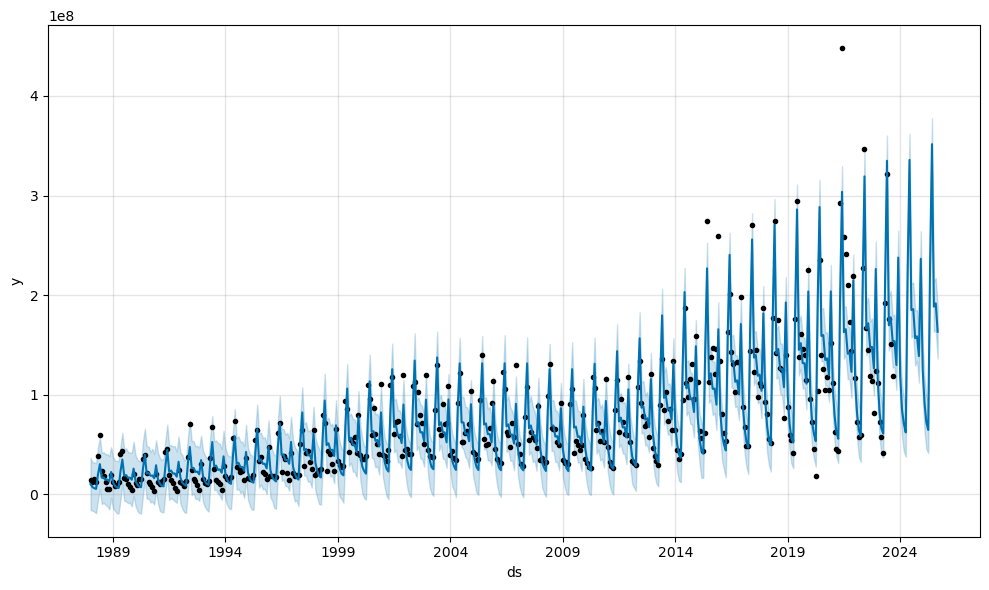

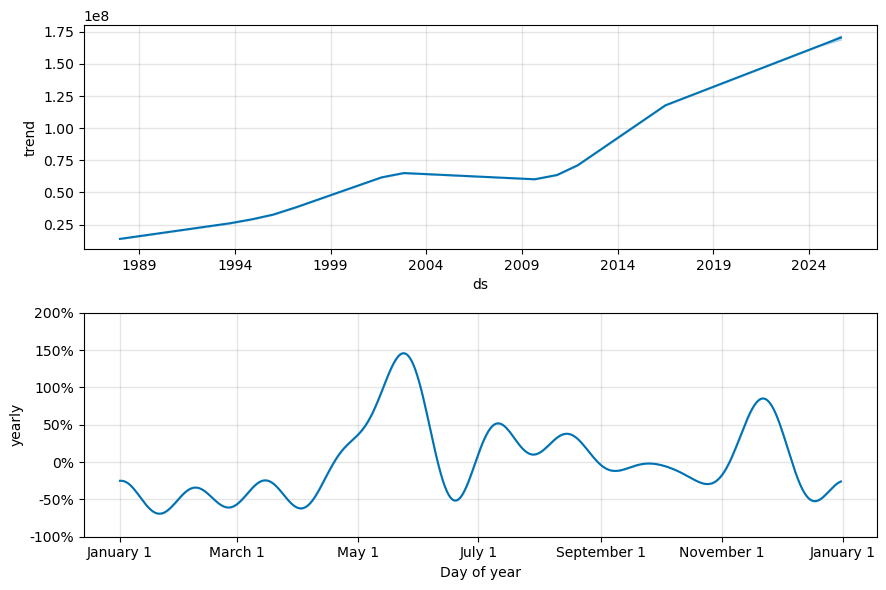

In [136]:
# predict 2018, 2019

prediction_range = 24
prediction_frequency = "MS"
future = m.make_future_dataframe(periods = 24, freq=prediction_frequency)
forecast = m.predict(future)
fig = m.plot(forecast)
m.plot_components(forecast)

# dd/mm/YY H:M:S
now = datetime.now()
dt_string = now.strftime("%Y-%m-%d %H:%M")
documentation["model_prediction_date:"] =  dt_string
documentation["Prediction range(num periods):"] = prediction_range
documentation["Prediction frequency:"]= prediction_frequency
documentation

In [137]:
forecast = m.predict(future)
predictions = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
predictions

,ds,yhat,yhat_lower,yhat_upper
0,1988-01-01,"10,356,626.90","-15,940,338.75","36,760,586.37"
1,1988-02-01,"7,373,835.69","-18,626,447.85","33,739,647.73"
2,1988-03-01,"6,248,409.96","-18,385,992.42","32,051,871.85"
3,1988-04-01,"5,525,417.17","-20,308,523.71","31,817,492.58"
4,1988-05-01,"19,979,874.14","-5,610,732.51","45,801,036.45"
...,...,...,...,...
448,2025-05-01,"229,671,604.40","203,012,988.56","256,037,850.84"
449,2025-06-01,"351,529,731.10","325,887,260.07","377,951,698.81"
450,2025-07-01,"188,421,374.99","162,126,906.37","214,227,164.25"
451,2025-08-01,"191,784,705.50","163,455,817.79","217,818,973.63"


#### Next steps:
* run on non log values
    * calc test / train metrics mannually
* run on noninflation adjusted vals
* Keep agg on months 

In [138]:
mape_idx = mapes.index(min(mapes))
print(mape_idx)
rmse_idx = rmses.index(min(rmses))
print(rmse_idx)

30
30


In [139]:
pd.DataFrame.from_dict(best_params, orient = 'index', columns = ['model_grouped_data'] )

,model_grouped_data
changepoint_prior_scale,0.10
seasonality_prior_scale,1.01
seasonality_mode,multiplicative
yearly_seasonality,True
rmse,"26,305,292.84"
mape,0.18


In [140]:
documentation

{'description': 'Tuned Prophet Model, with CV, using non-indexed values, non-log values, and filtered commodities for Homarus Americanus Commodities only',
 'train_data_source': 'us data: unindexed no log, americanus only',
 'train_start_year': 1988,
 'train_end_year': 2017,
 'test_data_source': 'us data: unindexed no log, americanus only',
 'test_start_year': 2018,
 'test_end_year': 2019,
 'model_params': {'changepoint_prior_scale': 0.101,
  'seasonality_prior_scale': 1.01,
  'seasonality_mode': 'multiplicative',
  'yearly_seasonality': True,
  'rmse': 26305292.84164052,
  'mape': 0.17541140467660435},
 'model_fit_date': '2024-01-08 12:23',
 '.fit()': 'us_data',
 'cv_param_cutoffs': DatetimeIndex(['2018-01-01', '2019-01-01'], dtype='datetime64[ns]', freq=None),
 'cv_param_initial': '10593 days',
 'cv_param_period': '365 days',
 'cv_param_horizon': '365 days',
 'cv_param_parallel': 'processes',
 'model_prediction_date:': '2024-01-08 12:23',
 'Prediction range(num periods):': 24,
 'Pred

In [141]:
# Model Eval Metrics
# split y actuals and predictions for train range
y_actual_train = df_year_filter(model_data_grouped, 1988, 2017)['y']
y_pred_train = df_year_filter(predictions, 1988, 2017)['yhat']

# RMSE - PROPHET - 1988 to 2017 TRAIN RANGE

mse_train = mean_squared_error(y_actual_train, y_pred_train, squared=True)
rmse_train =  mean_squared_error(y_actual_train, y_pred_train, squared=False)
mape_train = mean_absolute_percentage_error(y_actual_train, y_pred_train)
# print(f'Train Prophet MSE value is {mse_train: ,.2f}, years 1988 to 2017')
# print(f'Train Prophet RMSE value is {rmse_train : ,.2f}, years 1988 to 2017')
# print(f'Train Prophet MAPE value is {mape_train: ,.5f}, years 1988 to 2017')

# RMSE - PROPHET - 2018 to 2019 TEST RANGE
# split y actuals and predictions for TEST range
y_actual_test = df_year_filter(model_data_grouped, 2018, 2019)['y']
y_pred_test = df_year_filter(predictions, 2018, 2019)['yhat']


mse_test = mean_squared_error(y_actual_test, y_pred_test, squared=True)
rmse_test =  mean_squared_error(y_actual_test, y_pred_test, squared=False)
mape_test = mean_absolute_percentage_error(y_actual_test, y_pred_test)
# print(f'TEST Prophet MSE value is {mse_test: ,.2f}, years 2018 to 2019')
# print(f'TEST Prophet RMSE value is {rmse_test : ,.2f}, years 2018 to 2019')
# print(f'TEST Prophet MAPE value is {mape_test: ,.5f}, years 2018 to 2019')
best_prophet_vals = [mse_train, mse_test, rmse_train, rmse_test, mape_train, mape_test]

In [142]:
results = pd.DataFrame(data={'Prophet-Best':best_prophet_vals}, index = ['mse_train', 'mse_test', 'rmse_train', 'rmse_test', 'mape_train', 'mape_test'])

In [143]:
results

,Prophet-Best
mse_train,"1,415,017,803,445,176.25"
mse_test,"1,182,226,568,181,031.25"
rmse_train,"37,616,722.39"
rmse_test,"34,383,521.75"
mape_train,0.37
mape_test,0.17


In [144]:
documentation['results'] = results.to_dict()

In [145]:
documentation

{'description': 'Tuned Prophet Model, with CV, using non-indexed values, non-log values, and filtered commodities for Homarus Americanus Commodities only',
 'train_data_source': 'us data: unindexed no log, americanus only',
 'train_start_year': 1988,
 'train_end_year': 2017,
 'test_data_source': 'us data: unindexed no log, americanus only',
 'test_start_year': 2018,
 'test_end_year': 2019,
 'model_params': {'changepoint_prior_scale': 0.101,
  'seasonality_prior_scale': 1.01,
  'seasonality_mode': 'multiplicative',
  'yearly_seasonality': True,
  'rmse': 26305292.84164052,
  'mape': 0.17541140467660435},
 'model_fit_date': '2024-01-08 12:23',
 '.fit()': 'us_data',
 'cv_param_cutoffs': DatetimeIndex(['2018-01-01', '2019-01-01'], dtype='datetime64[ns]', freq=None),
 'cv_param_initial': '10593 days',
 'cv_param_period': '365 days',
 'cv_param_horizon': '365 days',
 'cv_param_parallel': 'processes',
 'model_prediction_date:': '2024-01-08 12:23',
 'Prediction range(num periods):': 24,
 'Pred

# Results

In [39]:
# def mean_absolute_percentage_error(y_true, y_pred):
#     '''take in true(actual) and predicted values to calculate the MAPE score. 
#     MAPE = mean absolute percentage error'''
#     y_true, y_pred = np.array(y_true), np.array(y_pred)
#     result = np.mean(np.abs((y_true - y_pred) / y_true))
#     return result

# Bin

In [82]:
tuning_attempts['smaller_CPS'] = best_params
tuning_attempts

,attempt1,initial=10yrs,initial=15yrs,smaller_CPS
changepoint_prior_scale,5,5,5,5
seasonality_prior_scale,25,25,25,15.00
seasonality_mode,multiplicative,multiplicative,multiplicative,multiplicative
yearly_seasonality,True,True,True,True
rmse,"84,155,734.63","84,155,734.63","84,155,734.63","83,961,852.17"


In [81]:
# attempt1_results = pd.DataFrame.from_dict(best_params, orient='index', columns = ['attempt1'])
tuning_attempts

,attempt1,initial=10yrs,initial=15yrs
changepoint_prior_scale,5,5,5
seasonality_prior_scale,25,25,25
seasonality_mode,multiplicative,multiplicative,multiplicative
yearly_seasonality,True,True,True
rmse,"84,155,734.63","84,155,734.63","84,155,734.63"
